# Importing of packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import simpy as si
import scipy as sy
import pandas as pd
import pickle
import searoute as sr
import seaborn as sns



%run Fundamentals/funcs.ipynb
fuel_color_map = {'Diesel': 'grey', 'Ammonia': 'skyblue'}

In [4]:
freeboard_table = pd.read_excel("Freeboard table.xlsx").dropna()

def get_freeboard(L, T, cb=0, df=freeboard_table):
    D = T / 0.85
    F = D - T
    table_value = np.interp(L, df['Length of Ship'], df['Freeboard increase']) / 1000
    if cb > 0.68:
        table_value = (cb + 0.68) / 1.36 * table_value
    return round(D + table_value, 3)

# Hull generation

In [5]:
df = generate_hulls(Ls=50,Bs=25,Ts=25)
df['D'] = df.apply(lambda row: get_freeboard(row['Lpp'], row['T'], row['Cb']), axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6859 entries, 0 to 6858
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lpp                   6859 non-null   float64
 1   B                     6859 non-null   float64
 2   T                     6859 non-null   float64
 3   Speed                 6859 non-null   float64
 4   Lwl                   6859 non-null   float64
 5   Fn                    6859 non-null   float64
 6   Cb                    6859 non-null   float64
 7   Dp                    6859 non-null   float64
 8   Volum_disp            6859 non-null   float64
 9   Weigh_disp            6859 non-null   float64
 10  Cm                    6859 non-null   float64
 11  Cw                    6859 non-null   float64
 12  Cp                    6859 non-null   float64
 13  Cpv                   6859 non-null   float64
 14  KB                    6859 non-null   float64
 15  BM                   

In [13]:
prop_list = []
for idx, row in df.iterrows():
    speed = row['Speed']
    if speed >= 24:
        Z_range = [5, 6, 7]
    elif speed >= 20:
        Z_range = [4, 5, 6]
    else:
        Z_range = [4, 5]
    ship_prop = get_opt_prop(row['RT'] * 1e3, row['Speed'], row['t'], row['w'], row['Dp'], 0.55 * row['T'],Z=Z_range)
    prop_list.append(ship_prop)
    

Valid propeller found for RT=36234.1891167741, Vs=12.0, t=0.1412680439525495, w=0.16091878787660174, D=2.1722916666666667, h0=1.2145833333333333
AE_A0=0.6666666666666665, P_D=1.1, J=0.7425812852925937, Z=5.0, N0=0.6473095419588114
Valid propeller found for RT=37577.85142460749, Vs=12.0, t=0.16906561131744788, w=0.1937249287032743, D=2.1722916666666667, h0=1.2145833333333333
AE_A0=0.6666666666666665, P_D=1.0, J=0.6655576891240566, Z=5.0, N0=0.6292713304272268
Valid propeller found for RT=47913.38293780023, Vs=12.0, t=0.19979356788695105, w=0.2299440492658315, D=2.1722916666666667, h0=1.2145833333333333
AE_A0=0.6666666666666665, P_D=1.0, J=0.5949068274803834, Z=5.0, N0=0.580274755432028
Valid propeller found for RT=47688.61484855156, Vs=12.0, t=0.2260011414654038, w=0.2609574655228243, D=2.1722916666666667, h0=1.2145833333333333
AE_A0=0.6666666666666665, P_D=0.8999999999999999, J=0.5340166094293247, Z=5.0, N0=0.5654743000304508
Valid propeller found for RT=52751.520519455495, Vs=12.0, t=

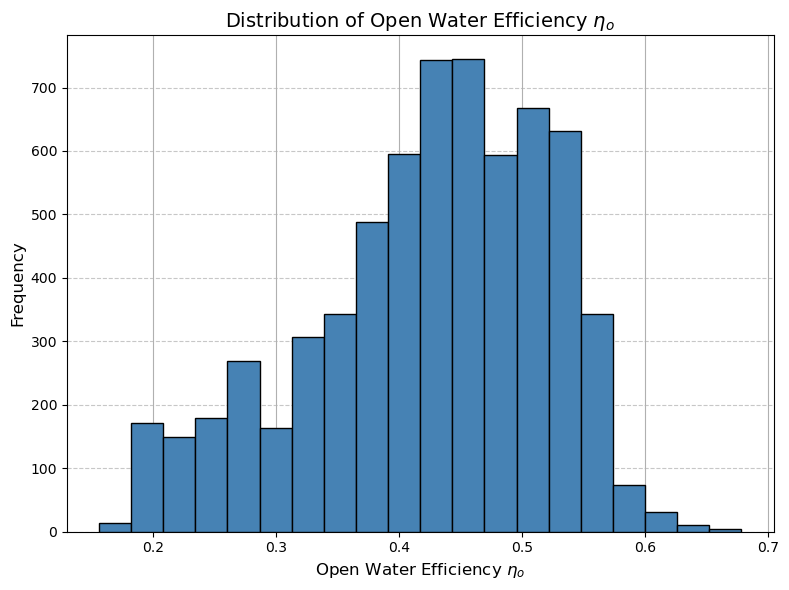

In [20]:
prop_list
df_props = pd.DataFrame(prop_list)
df_props = df_props[df_props['N0'] >= 0.1]

plt.figure(figsize=(8, 6))
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)  # grid behind bars

df_props['N0'].hist(
    bins=20,
    edgecolor='black',
    color='steelblue',
    alpha=1,
    zorder=3  # bars on top of grid
)

plt.title("Distribution of Open Water Efficiency $\eta_o$", fontsize=14)
plt.xlabel("Open Water Efficiency $\eta_o$", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [411]:
df['Est_vol'] , df['Est_sur'] = zip(*df.apply(lambda x: get_hull_volume_surface(x['Lpp'],x['B'],x['T'],x['Cb']), axis=1))

38.97959183673469 7.125 2.208333333333333 0.596232919495643 0
43.46938775510204 7.125 2.208333333333333 0.6247865905688333 0
47.95918367346938 9.166666666666666 2.208333333333333 0.6499028875682515 0
52.44897959183673 9.166666666666666 2.208333333333333 0.6719218984766472 0
Rear station mismatch at x=0.98, Cm=0.111. Area bounds: [313.03, 0.23]
38.97959183673469 7.125 3.4166666666666665 0.596232919495643 0
Rear station mismatch at x=0.98, Cm=0.121. Area bounds: [312.89, 0.09]
43.46938775510204 7.125 3.4166666666666665 0.6247865905688333 0
47.95918367346938 7.125 3.4166666666666665 0.6499028875682515 0
47.95918367346938 9.166666666666666 3.4166666666666665 0.6499028875682515 0
52.44897959183673 7.125 3.4166666666666665 0.6719218984766472 0
52.44897959183673 9.166666666666666 3.4166666666666665 0.6719218984766472 0
56.93877551020408 7.125 3.4166666666666665 0.691245681884157 0
56.93877551020408 9.166666666666666 3.4166666666666665 0.691245681884157 0
56.93877551020408 11.208333333333332 3

TypeError: remove: path should be string, bytes or os.PathLike, not NoneType

Exception ignored in: 'scipy._lib.messagestream.MessageStream.__dealloc__'
Traceback (most recent call last):
  File "messagestream.pyx", line 91, in scipy._lib.messagestream.MessageStream.close
TypeError: remove: path should be string, bytes or os.PathLike, not NoneType


: 

In [7]:
%matplotlib inline
plt.show()

6859 6859


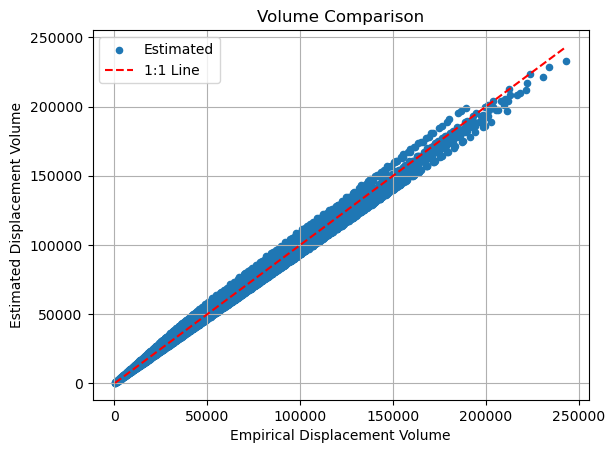

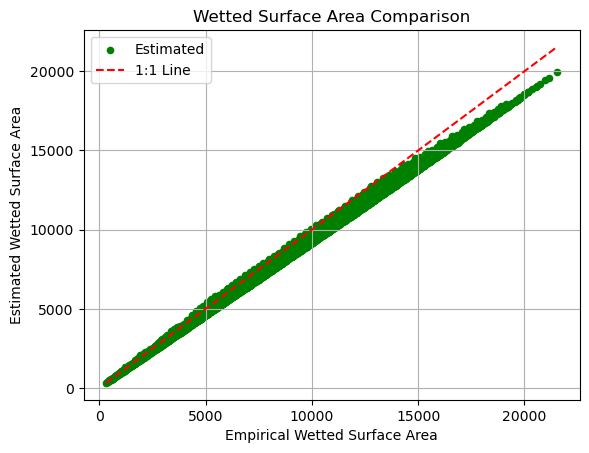

In [9]:
# --- Volume Comparison ---
print(len(df['Volum_disp']), len(df['Est_vol']))

# Define common min and max for plotting the 1:1 reference line
vol_min = min(df['Volum_disp'].min(), df['Est_vol'].min())
vol_max = max(df['Volum_disp'].max(), df['Est_vol'].max())

plt.scatter(df['Volum_disp'], df['Est_vol'], s=20, label='Estimated')
plt.plot([vol_min, vol_max], [vol_min, vol_max], 'r--', label='1:1 Line')
plt.xlabel("Empirical Displacement Volume")
plt.ylabel("Estimated Displacement Volume")
plt.title("Volume Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Wetted Surface Area Comparison ---
surf_min = min(df['Wet surface'].min(), df['Est_sur'].min())
surf_max = max(df['Wet surface'].max(), df['Est_sur'].max())

plt.scatter(df['Wet surface'], df['Est_sur'], s=20, label='Estimated',color='green')
plt.plot([surf_min, surf_max], [surf_min, surf_max], 'r--', label='1:1 Line')
plt.xlabel("Empirical Wetted Surface Area")
plt.ylabel("Estimated Wetted Surface Area")
plt.title("Wetted Surface Area Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
df_volume = df[['Volum_disp', 'Est_vol']]
df_volume['∆ Volume'] = df_volume['Volum_disp'] - df_volume['Est_vol']
df_volume['∆ Volume %'] = df_volume['∆ Volume']/df_volume['Volum_disp'] * 100

df_surface = df[['Wet surface', 'Est_sur']]
df_surface['∆ Surface'] = df_surface['Wet surface'] - df_surface['Est_sur']
df_surface['∆ Surface %'] = df_surface['∆ Surface']/df_surface['Wet surface'] * 100

C:\Users\Morten\AppData\Local\Temp\ipykernel_24356\2120072619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volume['∆ Volume'] = df_volume['Volum_disp'] - df_volume['Est_vol']
C:\Users\Morten\AppData\Local\Temp\ipykernel_24356\2120072619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volume['∆ Volume %'] = df_volume['∆ Volume']/df_volume['Volum_disp'] * 100
C:\Users\Morten\AppData\Local\Temp\ipykernel_24356\2120072619.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [11]:
df_volume.describe()

Volum_disp        Est_vol      ∆ Volume   ∆ Volume %
count    6859.000000    6859.000000   6859.000000  6859.000000
mean    62685.674533   62652.344394     33.330138    -1.236778
std     41558.038304   40746.110706   3593.460949     6.522319
min       365.681285     430.420965 -10939.932262   -20.369107
25%     29657.600355   30336.122429  -1771.251133    -5.479977
50%     56209.354543   56630.738764    165.276774     0.578550
75%     88161.902315   87672.980165   2061.902142     3.711670
max    243088.701804  233078.732690  14492.629635     6.849949

In [12]:
df_surface.describe()

Wet surface       Est_sur    ∆ Surface  ∆ Surface %
count   6859.000000   6859.000000  6859.000000  6859.000000
mean    9287.242444   8703.653987   583.588456     5.959548
std     4137.656457   3831.088105   356.775674     2.386553
min      329.090289    333.937837  -376.582774    -8.254596
25%     6066.244333   5757.911170   302.687307     5.000456
50%     9275.522065   8699.137940   571.919902     6.813837
75%    12386.091620  11577.230306   849.996108     7.633963
max    21536.582296  19971.709886  1564.872411     8.647585

In [13]:
df['D'] = df.apply(lambda row: get_freeboard(row['Lpp'], row['T'], row['Cb']), axis=1)

In [20]:
print("🔎 Volume Comparison:")
print(df_volume[['Volum_disp',	'Est_vol',	'∆ Volume',	'∆ Volume %']].describe())

print("\n🔎 Surface Comparison:")
print(df_surface[['Wet surface','Est_sur',	'∆ Surface', '∆ Surface %']].describe())


🔎 Volume Comparison:
          Volum_disp        Est_vol      ∆ Volume   ∆ Volume %
count    6859.000000    6859.000000   6859.000000  6859.000000
mean    62685.674533   62652.344394     33.330138    -1.236778
std     41558.038304   40746.110706   3593.460949     6.522319
min       365.681285     430.420965 -10939.932262   -20.369107
25%     29657.600355   30336.122429  -1771.251133    -5.479977
50%     56209.354543   56630.738764    165.276774     0.578550
75%     88161.902315   87672.980165   2061.902142     3.711670
max    243088.701804  233078.732690  14492.629635     6.849949

🔎 Surface Comparison:
        Wet surface       Est_sur    ∆ Surface  ∆ Surface %
count   6859.000000   6859.000000  6859.000000  6859.000000
mean    9287.242444   8703.653987   583.588456     5.959548
std     4137.656457   3831.088105   356.775674     2.386553
min      329.090289    333.937837  -376.582774    -8.254596
25%     6066.244333   5757.911170   302.687307     5.000456
50%     9275.522065   8699.13

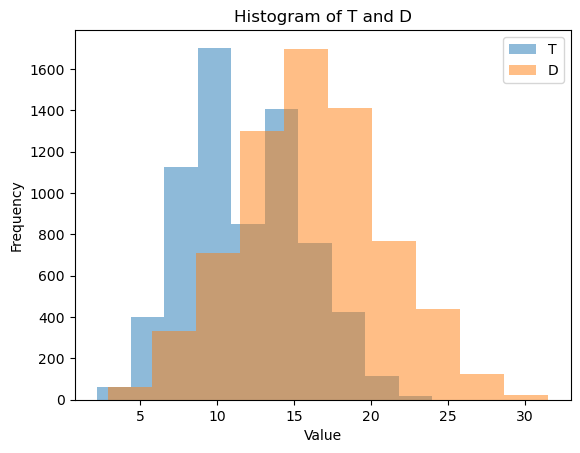

In [21]:
plt.hist(df['T'], bins=10, alpha=0.5, label='T')
plt.hist(df['D'], bins=10, alpha=0.5, label='D')
plt.legend(loc='upper right')
plt.title('Histogram of T and D')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

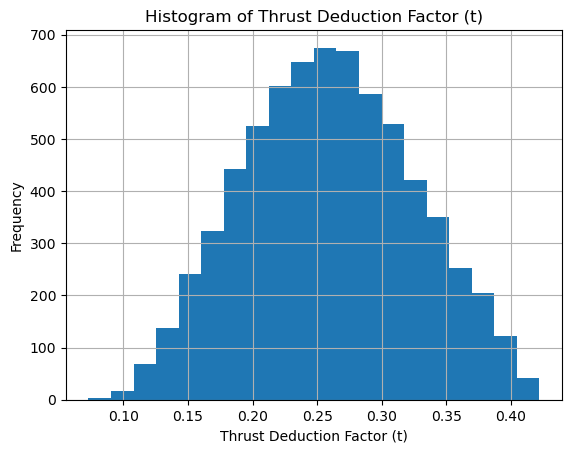

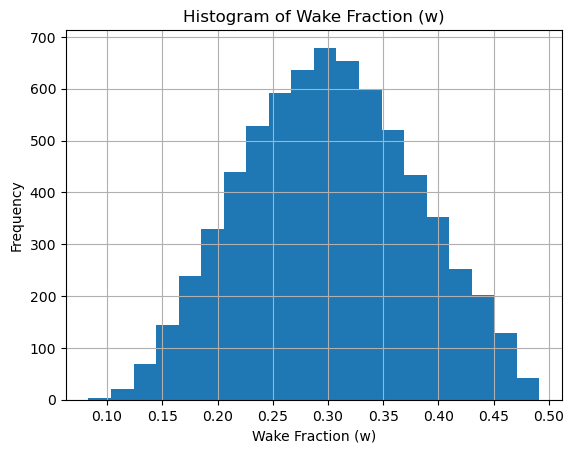

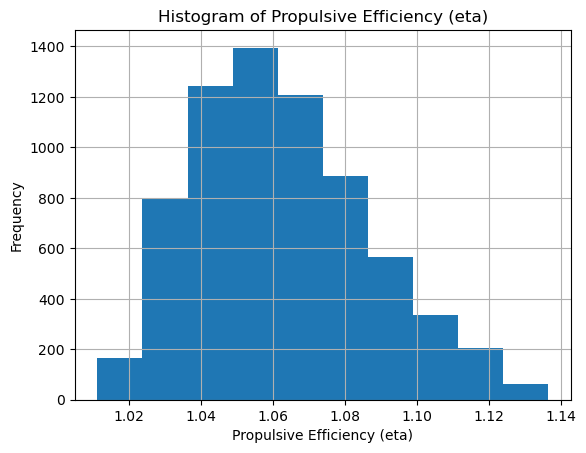

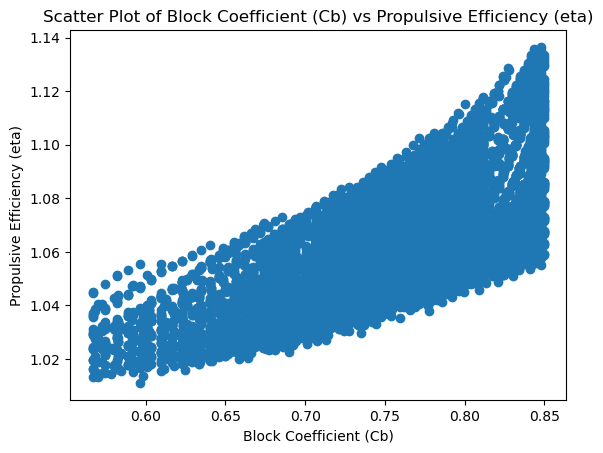

In [22]:
df_fil = df

df_fil['t'].hist(bins=20)
plt.title('Histogram of Thrust Deduction Factor (t)')
plt.xlabel('Thrust Deduction Factor (t)')
plt.ylabel('Frequency')
plt.show()

df_fil['w'].hist(bins=20)
plt.title('Histogram of Wake Fraction (w)')
plt.xlabel('Wake Fraction (w)')
plt.ylabel('Frequency')
plt.show()

df['eta'].hist()
plt.title('Histogram of Propulsive Efficiency (eta)')
plt.xlabel('Propulsive Efficiency (eta)')
plt.ylabel('Frequency')
plt.show()


plt.scatter(df_fil['Cb'], df_fil['eta'])
plt.title('Scatter Plot of Block Coefficient (Cb) vs Propulsive Efficiency (eta)')
plt.xlabel('Block Coefficient (Cb)')
plt.ylabel('Propulsive Efficiency (eta)')
plt.show()


In [ ]:
fuels = {'Ammonia': [432, 1.2, 0.68], 'Disel': [35.6, 1.2, 0.7], 'Lub Oil': [1.5, 4, 0.7]}
fuels = {'Disel': [200, 1.2, 0.7], 'Lub Oil': [1.5, 4, 0.7]}

In [ ]:
plt.show()

Displacement: 32125 | Total Deadweight: 23266
Main Engine Power: 10349 |9253|1096
Crew Number: 24 | GV 68906
0.724


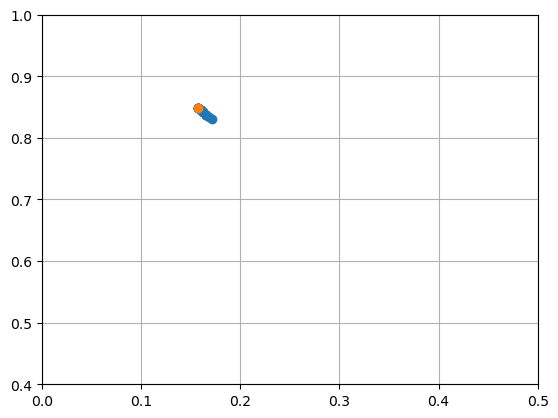

5277 1.073


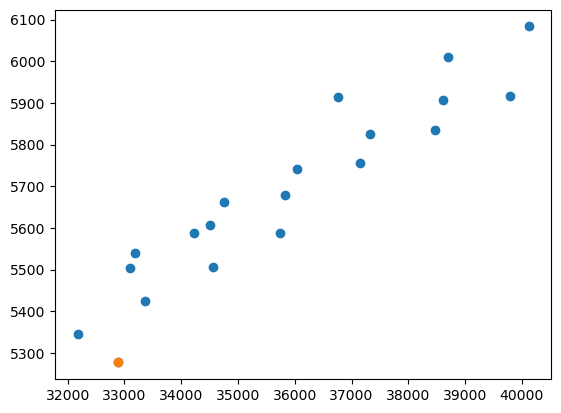

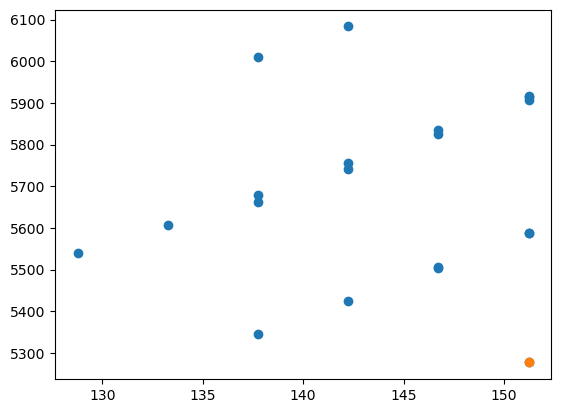

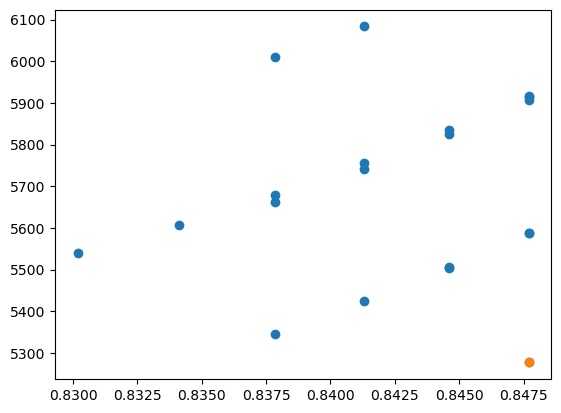

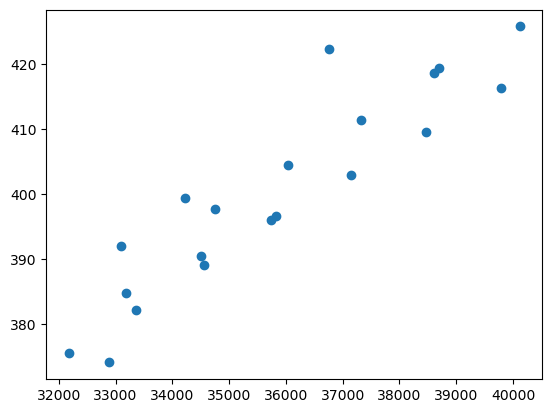

In [ ]:
vessel = get_Ship('Ammonia', 30000, 12, 5000, fuels, df_ship_compare, df_crew)
df_speed = df[(df['Cb']> 0.65) & (df['Speed'] == vessel.mission.service_speed) 
              & (df['Weigh_disp']> vessel.displacment) 
              & (df['Weigh_disp'] < vessel.displacment*1.25)]

min_pe_row = df_speed.loc[df_speed['Pe'].idxmin()]
#print(vessel.lightweight['Hull Structure'],vessel.total_lightweight)
print(f"Displacement: {round(vessel.displacment)} | Total Deadweight: {round(vessel.total_deadweight)}\nMain Engine Power: {round(vessel.mac.ser_tot_engine_power)} |{round(vessel.mac.ser_main_engine_power)}|{round(vessel.mac.ser_aux_engine_power)}\nCrew Number: {vessel.mission.crew_number} | GV {round(vessel.GV)}")
print(round(vessel.total_deadweight/vessel.displacment,3))
plt.scatter(df_speed['Fn'],df_speed['Cb'])
plt.scatter(min_pe_row['Fn'],min_pe_row['Cb'])
plt.xlim(0,0.5)
plt.ylim(0.4,1)
plt.grid()
plt.show()
print(round(min_pe_row['Pe']),round(min_pe_row['eta'],3))
plt.scatter(df_speed['Weigh_disp'],df_speed['Pe'])
plt.scatter(min_pe_row['Weigh_disp'],min_pe_row['Pe'])
plt.show()
plt.scatter(df_speed['Lpp'],df_speed['Pe'])
plt.scatter(min_pe_row['Lpp'],min_pe_row['Pe'])
plt.show()
plt.scatter(df_speed['Cb'],df_speed['Pe'])
plt.scatter(min_pe_row['Cb'],min_pe_row['Pe'])
plt.show()
plt.scatter(df_speed['Weigh_disp'],df_speed['RT'])

In [ ]:
df_speed.loc[:, 'N0'] = df_speed.apply(lambda row: get_opt_prop(
    row['RT']*1e3,
    row['Speed'],
    row['t'],
    row['w'],
    row['Dp'],
    0.55 * row['T']
)['N0'], axis=1)

C:\Users\Morten\AppData\Local\Temp\ipykernel_22880\3097634178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speed.loc[:, 'N0'] = df_speed.apply(lambda row: get_opt_prop(


In [ ]:
df_speed = df_speed[df_speed['N0'] > 0.1].copy()

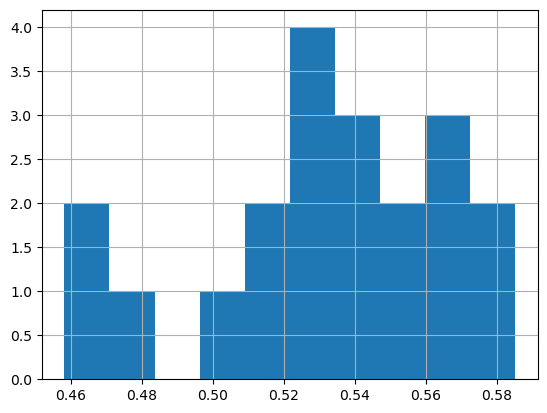

In [ ]:
df_speed['N0'].hist()
df_speed['Pe1'] = df_speed['RT'] * df_speed['Speed'] * 0.5144/( df_speed['eta'] * df_speed['N0'] * 0.96 ) * 1.25/0.85

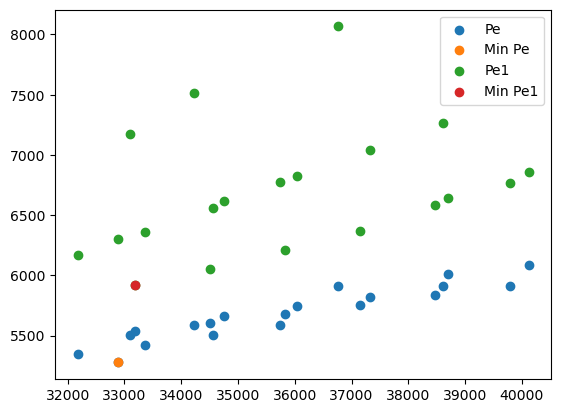

In [ ]:
min_pe_row = df_speed.loc[df_speed['Pe'].idxmin()]
plt.scatter(df_speed['Weigh_disp'],df_speed['Pe'],label='Pe')
plt.scatter(min_pe_row['Weigh_disp'],min_pe_row['Pe'],label='Min Pe')

min_pe_row1 = df_speed.loc[df_speed['Pe1'].idxmin()]
plt.scatter(df_speed['Weigh_disp'],df_speed['Pe1'],label='Pe1')
plt.scatter(min_pe_row1['Weigh_disp'],min_pe_row1['Pe1'],label='Min Pe1')
plt.legend()

plt.show()

In [ ]:
df_speed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 271 to 304
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lpp                   20 non-null     float64
 1   B                     20 non-null     float64
 2   T                     20 non-null     float64
 3   Speed                 20 non-null     float64
 4   Lwl                   20 non-null     float64
 5   Fn                    20 non-null     float64
 6   Cb                    20 non-null     float64
 7   Dp                    20 non-null     float64
 8   Volum_disp            20 non-null     float64
 9   Weigh_disp            20 non-null     float64
 10  Cm                    20 non-null     float64
 11  Cw                    20 non-null     float64
 12  Cp                    20 non-null     float64
 13  Cpv                   20 non-null     float64
 14  KB                    20 non-null     float64
 15  BM                    

In [ ]:
def get_stable_ships(df,req_vol,vessel,start=1,end=20,space=20):
    freeboard = np.linspace(start,end,space)
    df_comply_stab = pd.DataFrame()
    for index, row in df.iterrows():
        for i in freeboard:
            vessel.get_transverse_center_of_gravity(row['T'] + i)
            stab = row['KM'] - vessel.KG
            if stab > 1 and row['T'] + i >= row['D']:
                hull_volume = get_hull_volume(row['B'], row['T'], row['Lpp'], row['Cb'], freeboard=i)
                if hull_volume > req_vol:
                    #print(index, hull_volume, row['Pe1'], stab, i)
                    row_with_data = row.to_frame().T
                    row_with_data['Freeboard'] = i
                    row_with_data['Total hull volume'] = hull_volume
                    row_with_data['GM'] = stab
                    df_comply_stab = pd.concat([df_comply_stab, row_with_data], ignore_index=True)
    return df_comply_stab

In [ ]:
req_vol = vessel.GV - vessel.system_sum['Total furnished spaces'] - vessel.system_sum['Total interior spaces']
df_comply_stab = get_stable_ships(df_speed,req_vol,vessel)

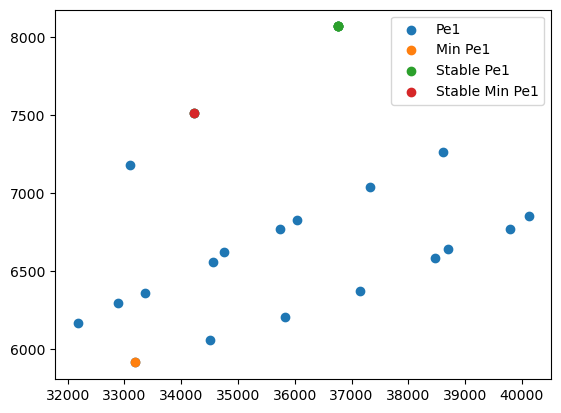

Lpp                       151.224490
B                          27.541667
T                           9.458333
Speed                      12.000000
Lwl                       154.248980
Fn                          0.157913
Cb                          0.847701
Dp                          5.036042
Volum_disp              33394.085712
Weigh_disp              34228.937855
Cm                          0.997211
Cw                          0.936046
Cp                          0.850072
Cpv                         0.905619
KB                          5.026729
BM                          6.948318
KM                         11.975046
Deck Area                3898.606336
Wet surface              6239.608589
RT                        399.363319
w                           0.365446
t                           0.313782
eta                         1.081418
Pe                       5587.231545
Dobbel Bottom Height        1.377083
D                          13.360000
N0                          0.464882
P

In [ ]:
min_pe_row1 = df_speed.loc[df_speed['Pe1'].idxmin()]
plt.scatter(df_speed['Weigh_disp'],df_speed['Pe1'],label='Pe1')
plt.scatter(min_pe_row1['Weigh_disp'],min_pe_row1['Pe1'],label='Min Pe1')

min_pe_row1 = df_comply_stab.loc[df_comply_stab['Pe1'].idxmin()]
min_pe_rowf = df_comply_stab.loc[df_comply_stab['Freeboard'].idxmin()]
plt.scatter(df_comply_stab['Weigh_disp'],df_comply_stab['Pe1'],label='Stable Pe1')
plt.scatter(min_pe_row1['Weigh_disp'],min_pe_row1['Pe1'],label='Stable Min Pe1')
#plt.scatter(min_pe_rowf['Weigh_disp'],min_pe_rowf['Pe1'])
plt.legend()
plt.show()

#plt.scatter(df_comply_stab['Weigh_disp'],df_comply_stab['Freeboard'])
#plt.scatter(min_pe_row1['Weigh_disp'],min_pe_row1['Freeboard'])
#plt.scatter(min_pe_rowf['Weigh_disp'],min_pe_rowf['Freeboard'])
hu =df_comply_stab.loc[df_comply_stab['Pe1'].idxmin()]
hu

In [ ]:
print(f"Main Engine Power (before update): {round(vessel.mac.ser_main_engine_power, 2)} kW")
print(f"Building Cost (before update): ${round(vessel.bulding_cost/1e6, 2)} million")
vessel.get_transverse_center_of_gravity(hu['T']+hu['Freeboard'])
print(f"GM (before update): {round(hu['KM']-vessel.KG, 8)} m\n")

vessel.update_power(round(hu['Pe1'], 2), round(hu['T'] + hu['Freeboard'], 2))

print(f"Main Engine Power (after update): {round(vessel.mac.ser_main_engine_power, 2)} kW")
print(f"Building Cost (after update): ${round(vessel.bulding_cost/1e6, 2)} million")
print(f"GM (after update): {round(hu['KM']-vessel.KG, 8)} m")


Main Engine Power (before update): 7511.63 kW
Building Cost (before update): $532.46 million
GM (before update): 1.070587 m

Main Engine Power (after update): 7511.63 kW
Building Cost (after update): $532.46 million
GM (after update): 1.0696024 m


In [43]:
def generate_ship(cargo_cap, speed, range, fuels, tolerance=1e-2, max_iterations=10,fuel = 'Diesel',count =None):
    vessel = get_Ship('Ammonia', cargo_cap, speed, range, fuels, df_ship_compare, df_crew,fuel=fuel)

    df_speed = df[(df['Cb'] > 0.55) & 
                  (df['Speed'] == vessel.mission.service_speed) & 
                  (df['Weigh_disp'] > vessel.displacment) & 
                  (df['Weigh_disp'] < vessel.displacment * 1.25)].copy()
    
    if len(df_speed) < 5:
        df_speed = df[(df['Cb'] > 0.55) & 
                (df['Speed'] == vessel.mission.service_speed) & 
                (df['Weigh_disp'] > vessel.displacment) & 
                (df['Weigh_disp'] < vessel.displacment * 1.5)].copy()
    
    main_fuel = list(f.keys())[0]
    int_pow = round(vessel.mac.ser_main_engine_power)
    if count is None:
        print(f"Generating ship with cap={cargo_cap}, speed={speed}, range={range}, fuel = {main_fuel}, int_power = {int_pow}")
    else:
        print(f"Generating ship_{count} with cap={cargo_cap}, speed={speed}, range={range}, fuel = {main_fuel}, int_power={int_pow}, nuumber of ships = {len(df_speed)}")

    i = 0.1  
    max_i = 0.5
    while df_speed.empty and i <= max_i:
        if i == 0.05:
            print(f'No ship found, expanding search range by {i*100:.1f}%')
        df_speed = df[(df['Cb'] > 0.55) & 
            (df['Speed'] == vessel.mission.service_speed) & 
            (df['Weigh_disp'] > vessel.displacment) & 
            (df['Weigh_disp'] < vessel.displacment * 1.1+i)].copy()
        i += 0.1

    if df_speed.empty:
        print('No suitable ship found after maximum expansion.')
        return None, vessel

         
    if speed >= 24:
        Z_range = [5, 6, 7]
    elif speed >= 20:
        Z_range = [4, 5, 6]
    else:
        Z_range = [4, 5]

   

    df_prop_results = df_speed.apply(lambda row: pd.Series(get_opt_prop(row['RT'] * 1e3, row['Speed'], row['t'], row['w'], row['Dp'], 0.55 * row['T'],Z=Z_range)), axis=1)


    df_speed = pd.concat([df_speed, df_prop_results], axis=1)
    df_speed['Pe1'] = df_speed['RT'] * df_speed['Speed'] * 0.5144 / (df_speed['eta'] * df_speed['N0'] * 0.96) * 1.25 / 0.85

    req_vol = vessel.GV - vessel.system_sum['Total furnished spaces'] - vessel.system_sum['Total interior spaces']
    df_comply_stab = get_stable_ships(df_speed, req_vol,vessel)
    
    i = 0.1
    while df_comply_stab.empty and i <= max_i:
        #if i == 0.1:
       
        df_speed = df[(df['Cb'] > 0.55) & 
            (df['Speed'] == vessel.mission.service_speed) & 
            (df['Weigh_disp'] > vessel.displacment) & 
            (df['Weigh_disp'] < vessel.displacment * 1.1+i)].copy()
        
        
        

        df_prop_results = df_speed.apply(lambda row: pd.Series(get_opt_prop(row['RT'] * 1e3, row['Speed'], row['t'], row['w'], row['Dp'], 0.55 * row['T'], Z=Z_range)), axis=1)

        # Merge it back into df_speed
        df_speed = pd.concat([df_speed, df_prop_results], axis=1)

        
        df_speed['Pe1'] = df_speed['RT'] * df_speed['Speed'] * 0.5144 / (df_speed['eta'] * df_speed['N0'] * 0.96) * 1.25 / 0.85
        df_comply_stab = get_stable_ships(df_speed, req_vol,vessel)
        print(f'No stable ship found, expanding search range by {i*100:.1f}%, size of stable ships now: {len(df_comply_stab)}')
        i += 0.1



    iteration = 0
    while iteration < max_iterations:
        req_vol = vessel.GV - vessel.system_sum['Total furnished spaces'] - vessel.system_sum['Total interior spaces']
        df_comply_stab = get_stable_ships(df_speed, req_vol,vessel)

        if df_comply_stab.empty:
            #raise ValueError("No stable ships found that satisfy volume and GM > 1m requirements.")
            print("No stable ships found that satisfy volume and GM > 1m requirements.")
            return None , vessel

        min_pe_row1 = df_comply_stab.loc[df_comply_stab['Pe1'].idxmin()]
        new_power = round(min_pe_row1['Pe1'], 2)

        if abs(vessel.mac.ser_main_engine_power - new_power) < tolerance:
            # Close enough, stop iterating
            break

        vessel.update_power(new_power, round(min_pe_row1['T'] + min_pe_row1['Freeboard'], 2))
        req_vol = vessel.GV - vessel.system_sum['Total furnished spaces'] - vessel.system_sum['Total interior spaces']
        iteration += 1
        print(f"Iteration {iteration}: Updated power to {new_power} kW, new volume {round(req_vol, 2)} m³")

    if iteration == max_iterations:
        print("Maximum iterations reached. Result may not be fully converged.")

    return min_pe_row1, vessel

#hu, ship1 = (generate_ship(6000,18,6000,fuels))
#print(ship1.mac.ser_main_engine_power)

In [44]:
fuela = {'Ammonia': [432, 1.2, 0.68], 'Disel': [35.6, 1.2, 0.7], 'Lub Oil': [1.5, 4, 0.7]}
fueld = {'Disel': [200, 1.2, 0.7], 'Lub Oil': [1.5, 4, 0.7]}
fuel_list = [fuela,fueld]

for f in fuel_list:
    main_fuel = list(f.keys())[0]
    print(main_fuel)

Ammonia
Disel


In [45]:
ranges = np.array([600, 1300,2000])
speeds = np.array([12, 13.5 ,15, 18, 20, 22, 25])
capacities = np.array([3000,5000,7500,10000,20000,30000,40000])

combis = np.array(np.meshgrid(ranges,speeds,capacities)).T.reshape(-1,3)
combis = pd.DataFrame(combis)
combis = combis.rename(columns={0: 'ranges', 1: 'speeds', 2: 'capacities'})

fuela = {'Ammonia': [432, 1.2, 0.68], 'Diesel': [35.6, 1.2, 0.7], 'Lub Oil': [1.5, 4, 0.7]}
fueld = {'Diesel': [200, 1.2, 0.7], 'Lub Oil': [1.5, 4, 0.7]}
fuel_list = [fueld,fuela]

In [46]:
combis

ranges  speeds  capacities
0     600.0    12.0      3000.0
1     600.0    13.5      3000.0
2     600.0    15.0      3000.0
3     600.0    18.0      3000.0
4     600.0    20.0      3000.0
..      ...     ...         ...
142  2000.0    15.0     40000.0
143  2000.0    18.0     40000.0
144  2000.0    20.0     40000.0
145  2000.0    22.0     40000.0
146  2000.0    25.0     40000.0

[147 rows x 3 columns]

In [25]:
%run Fundamentals/funcs.ipynb

In [ ]:
results = []
none_list = []

counting = 0
for i in ranges:
    for j in speeds:
        for k in capacities:
            for f in fuel_list:
                main_fuel = list(f.keys())[0]
                hull, ship = generate_ship(k, j, i, f,fuel=main_fuel,count=counting)
                int_power = round(ship.mac.ser_main_engine_power)
                counting += 1
                print(f"Generating ship with cap={k}, speed={j}, range={i}, fuel = {main_fuel}, int_power = {int_power}")
                

                if isinstance(ship, Ship) and isinstance(hull, pd.Series):
                    results.append({
                        "Range": i,
                        "Speed": j,
                        "Capacity": k,
                        "GV" : ship.GV,
                        "GT": ship.GT,
                        "Displacement": ship.displacment,
                        "Total Deadweight": ship.total_deadweight,
                        "Main Engine Power (kW)": ship.mac.ser_main_engine_power,
                        "Building Cost (MNOK)": ship.bulding_cost / 1e6,
                        "Fuel Weight (tons)": sum(ship.tan.weight),
    

                        # Hull-related values
                        "Lpp": hull["Lpp"],
                        "B": hull["B"],
                        "T": hull["T"],
                        "Cb": hull["Cb"],
                        "GM": hull["GM"],
                        "Hull Volume": hull["Total hull volume"],
                        'Blade number': hull['Z'],
                        'Main fuel' : main_fuel,

                        # Store both full ship and hull if needed
                        "ShipObj": ship,
                        "HullRow": hull
                    })
                else:
                    none_list.append({
                        "Range": i,
                        "Speed": j,
                        "Capacity": k,
                        "GV" : ship.GV,
                        "GT": ship.GT,
                        "Displacement": ship.displacment,
                        "Total Deadweight": ship.total_deadweight,
                        "Main Engine Power (kW)": ship.mac.ser_main_engine_power,
                        "Building Cost (MNOK)": ship.bulding_cost / 1e6,
                        "Fuel Weight (tons)": sum(ship.tan.weight),
                        "ShipObj": ship

                    })

Diesel
Generating ship_0 with cap=3000, speed=12.0, range=600, fuel = Diesel, int_power=2389, nuumber of ships = 9


KeyboardInterrupt: 

In [ ]:
df_summary = pd.DataFrame([{k: v for k, v in r.items() if k not in ["ShipObj", "HullRow"]}for r in results])
none_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ["ShipObj"]}for r in none_list])

In [ ]:
df_summary

Range  Speed  Capacity             GV            GT  Displacement  \
0      600   12.0      3000    8967.802132   2502.498548   3862.766938   
1      600   12.0      3000    9023.394093   2518.496051   3956.465558   
2      600   12.0      5000   13620.369955   3850.257638   6043.491796   
3      600   12.0      5000   13695.009281   3872.007047   6168.667212   
4      600   12.0      7500   19233.162954   5494.549500   8689.600297   
..     ...    ...       ...            ...           ...           ...   
258   2000   25.0     20000   89920.558253  26893.186976  33120.053893   
259   2000   25.0     30000  116332.267265  35052.541226  37970.971189   
260   2000   25.0     30000  120508.971824  36347.962793  44722.600613   
261   2000   25.0     40000  143860.434423  43612.560602  47730.491766   
262   2000   25.0     40000  148415.090168  45033.525686  55349.467704   

     Total Deadweight  Main Engine Power (kW)  Building Cost (MNOK)  \
0         2129.134716                 1828.70             74.319989   
1         2215.070518                 1828.70             74.564135   
2         3514.971369                 2422.14            114.394235   
3         3630.108936                 2422.14            114.712370   
4         5246.924081                 3261.74            162.442464   
..                ...                     ...                   ...   
258      22979.828977                83735.10            504.014643   
259      25469.204197               102387.27            674.484001   
260      31886.058003               102719.31            687.015776   
261      32984.112820               116958.62            843.219070   
262      40268.046393               116958.62            856.123013   

     Fuel Weight (tons)         Lpp          B         T        Cb        GM  \
0             27.430306   83.877551  13.250000  4.625000  0.768971  1.686676   
1             63.236890   83.877551  13.250000  4.625000  0.768971  1.720840   
2             36.751372   92.857143  15.291667  5.833333  0.785665  1.193791   
3             84.725359   92.857143  15.291667  5.833333  0.785665  1.230909   
4             48.555196   97.346939  19.375000  5.833333  0.792925  2.770865   
..                  ...         ...        ...       ...       ...       ...   
258         3843.320500  155.714286  29.583333  8.250000  0.574427  2.194249   
259         2036.556951  182.653061  31.625000  8.250000  0.616350  2.073016   
260         4710.073376  187.142857  31.625000  8.250000  0.622678  2.650823   
261         2324.997481  200.612245  33.666667  9.458333  0.640568  1.734275   
262         5359.969804  200.612245  33.666667  9.458333  0.640568  1.779724   

       Hull Volume  Blade number Main fuel  
0      5785.899255           5.0    Diesel  
1      5785.899255           5.0   Ammonia  
2      9991.959198           5.0    Diesel  
3      9991.959198           5.0   Ammonia  
4     14984.451208           5.0    Diesel  
..             ...           ...       ...  
258   86749.129588           5.0   Ammonia  
259  114743.804481           5.0    Diesel  
260  117624.622342           5.0   Ammonia  
261  140143.138425           5.0    Diesel  
262  146108.061093           5.0   Ammonia  

[263 rows x 18 columns]

In [ ]:
# Save results
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save none_list if you want
with open('none_list.pkl', 'wb') as f:
    pickle.dump(none_list, f)

In [37]:
# Load results
with open('results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

# Load none_list
with open('none_list.pkl', 'rb') as f:
    loaded_none_list = pickle.load(f)

df_summary = pd.DataFrame([{k: v for k, v in r.items() if k not in ["ShipObj", "HullRow"]}for r in loaded_results])
none_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ["ShipObj"]}for r in loaded_none_list])

In [38]:
j = 0
for i in loaded_results:
    df_summary.loc[df_summary.index[j], 'Wet surface'] = i['HullRow']['Wet surface']
    df_summary.loc[df_summary.index[j], 'N0'] = i['HullRow']['N0']
    j += 1


df_summary.iloc[0]

Range                             600
Speed                            12.0
Capacity                         3000
GV                        8967.802132
GT                        2502.498548
Displacement              3862.766938
Total Deadweight          2129.134716
Main Engine Power (kW)         1828.7
Building Cost (MNOK)        74.319989
Fuel Weight (tons)          27.430306
Lpp                         83.877551
B                               13.25
T                               4.625
Cb                           0.768971
GM                           1.686676
Hull Volume               5785.899255
Blade number                      5.0
Main fuel                      Diesel
Wet surface               1590.368347
N0                           0.558986
Name: 0, dtype: object

In [39]:
df_summary

Range  Speed  Capacity             GV            GT  Displacement  \
0      600   12.0      3000    8967.802132   2502.498548   3862.766938   
1      600   12.0      3000    9023.394093   2518.496051   3956.465558   
2      600   12.0      5000   13620.369955   3850.257638   6043.491796   
3      600   12.0      5000   13695.009281   3872.007047   6168.667212   
4      600   12.0      7500   19233.162954   5494.549500   8689.600297   
..     ...    ...       ...            ...           ...           ...   
258   2000   25.0     20000   89920.558253  26893.186976  33120.053893   
259   2000   25.0     30000  116332.267265  35052.541226  37970.971189   
260   2000   25.0     30000  120508.971824  36347.962793  44722.600613   
261   2000   25.0     40000  143860.434423  43612.560602  47730.491766   
262   2000   25.0     40000  148415.090168  45033.525686  55349.467704   

     Total Deadweight  Main Engine Power (kW)  Building Cost (MNOK)  \
0         2129.134716                 1828.70             74.319989   
1         2215.070518                 1828.70             74.564135   
2         3514.971369                 2422.14            114.394235   
3         3630.108936                 2422.14            114.712370   
4         5246.924081                 3261.74            162.442464   
..                ...                     ...                   ...   
258      22979.828977                83735.10            504.014643   
259      25469.204197               102387.27            674.484001   
260      31886.058003               102719.31            687.015776   
261      32984.112820               116958.62            843.219070   
262      40268.046393               116958.62            856.123013   

     Fuel Weight (tons)         Lpp          B         T        Cb        GM  \
0             27.430306   83.877551  13.250000  4.625000  0.768971  1.686676   
1             63.236890   83.877551  13.250000  4.625000  0.768971  1.720840   
2             36.751372   92.857143  15.291667  5.833333  0.785665  1.193791   
3             84.725359   92.857143  15.291667  5.833333  0.785665  1.230909   
4             48.555196   97.346939  19.375000  5.833333  0.792925  2.770865   
..                  ...         ...        ...       ...       ...       ...   
258         3843.320500  155.714286  29.583333  8.250000  0.574427  2.194249   
259         2036.556951  182.653061  31.625000  8.250000  0.616350  2.073016   
260         4710.073376  187.142857  31.625000  8.250000  0.622678  2.650823   
261         2324.997481  200.612245  33.666667  9.458333  0.640568  1.734275   
262         5359.969804  200.612245  33.666667  9.458333  0.640568  1.779724   

       Hull Volume  Blade number Main fuel  Wet surface        N0  
0      5785.899255           5.0    Diesel  1590.368347  0.558986  
1      5785.899255           5.0   Ammonia  1590.368347  0.558986  
2      9991.959198           5.0    Diesel  2143.693674  0.561981  
3      9991.959198           5.0   Ammonia  2143.693674  0.561981  
4     14984.451208           5.0    Diesel  2570.079653  0.514823  
..             ...           ...       ...          ...       ...  
258   86749.129588           5.0   Ammonia  5084.404550  0.454357  
259  114743.804481           5.0    Diesel  6415.826169  0.426866  
260  117624.622342           5.0   Ammonia  6610.610073  0.424360  
261  140143.138425           5.0    Diesel  7923.600799  0.429910  
262  146108.061093           5.0   Ammonia  7923.600799  0.429910  

[263 rows x 20 columns]

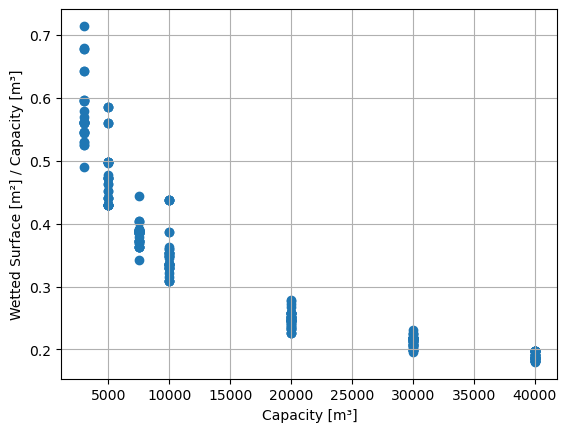

In [40]:
plt.scatter(df_summary['Capacity'],df_summary['Wet surface']/df_summary['Capacity'])
plt.xlabel('Capacity [m³]')
plt.ylabel('Wetted Surface [m²] / Capacity [m³]')
plt.grid(True)
plt.show()

In [41]:
none_df

Range  Speed  Capacity            GV            GT  Displacement  \
0     600   12.0     40000  87814.425800  26245.213119  37808.015383   
1     600   12.0     40000  88095.945502  26331.800447  38270.761415   
2     600   22.0      3000   9228.405019   2577.516897   3869.215539   
3     600   22.0      3000   9266.064511   2588.363061   3933.100253   
4     600   25.0      3000   9224.562735   2576.410370   3861.932209   
5     600   25.0      3000   9257.703088   2585.954805   3918.151076   
6     600   25.0      5000  14074.788007   3982.726397   6060.541668   
7     600   25.0      5000  14121.772368   3996.430288   6139.993395   
8     600   25.0      7500  19923.453812   5697.854614   8723.688851   
9     600   25.0      7500  19987.625775   5716.765267   8831.701111   
10    600   25.0     10000  25496.597267   7346.325506  11244.777671   
11   1300   12.0     40000  88071.226160  26324.197178  38269.933500   
12   1300   12.0     40000  88681.185513  26511.828348  39272.472881   
13   1300   22.0      3000   9265.760552   2588.275514   3940.024483   
14   1300   22.0      3000   9347.356119   2611.780067   4078.433750   
15   1300   25.0      3000   9257.435605   2585.877766   3924.244394   
16   1300   25.0      3000   9329.239703   2606.560886   4046.046043   
17   1300   25.0      5000  14120.085913   3995.938378   6145.502782   
18   1300   25.0      5000  14221.885362   4025.634689   6317.638211   
19   1300   25.0      7500  19984.029624   5715.705480   8836.157486   
20   1300   25.0      7500  20123.068877   5756.684477   9070.165507   
21   2000   12.0     40000  88328.026520  26403.187742  38731.831838   
22   2000   12.0     40000  89266.425524  26691.889796  40274.081608   
23   2000   22.0      3000   9303.116086   2599.035439   4010.831231   
24   2000   22.0      3000   9428.647727   2635.203213   4223.756852   
25   2000   25.0      3000   9290.308475   2595.346175   3986.554879   
26   2000   25.0      3000   9400.776318   2627.171732   4173.932960   
27   2000   25.0      5000  14165.383818   4009.151621   6230.461129   
28   2000   25.0      5000  14321.998356   4054.845211   6495.269513   
29   2000   25.0      7500  20044.605436   5733.557941   8948.621127   
30   2000   25.0      7500  20258.511979   5796.611606   9308.604936   

    Total Deadweight  Main Engine Power (kW)  Building Cost (MNOK)  \
0       27582.065072            10194.414036            674.216689   
1       28020.428937            10194.414036            675.111477   
2        2099.234928             2388.523472             75.463652   
3        2157.875799             2388.523472             75.628746   
4        2092.486736             2388.523472             75.446806   
5        2144.090703             2388.523472             75.592094   
6        3471.025209             3389.614737            116.328511   
7        3544.186150             3389.614737            116.528151   
8        5193.657547             4716.497191            165.262486   
9        5293.581885             4716.497191            165.523912   
10       6909.382557             5657.923548            211.160209   
11      28021.740989            10194.414036            675.032929   
12      28971.529363            10194.414036            676.969981   
13       2164.842343             2388.523472             75.627413   
14       2291.897564             2388.523472             75.984964   
15       2150.221262             2388.523472             75.590922   
16       2262.029856             2388.523472             75.905596   
17       3549.921287             3389.614737            116.520986   
18       3708.436659             3389.614737            116.953317   
19       5298.491352             4716.497191            165.509265   
20       5514.994084             4716.497191            166.075273   
21      28461.416906            10194.414036            675.848744   
22      29922.629789            10194.414036            678.826277   
23       2230.44975

In [47]:
#hull, ship = generate_ship(k, j, i, f,fuel=main_fuel,count=counting)
hull, ship = generate_ship(3000,25,600,fuela,fuel='Ammonia')

Generating ship with cap=3000, speed=25, range=600, fuel = Disel, int_power = 2389
No suitable ship found after maximum expansion.


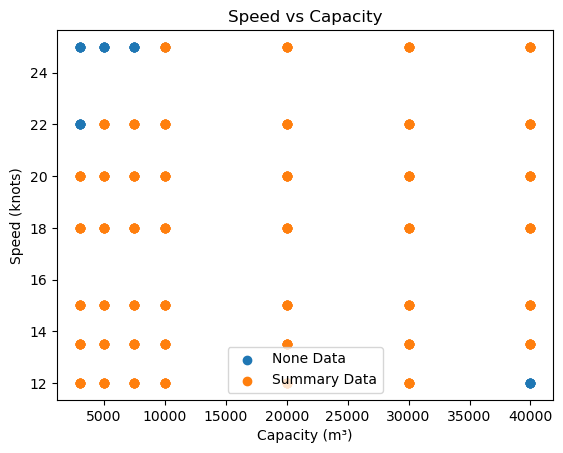

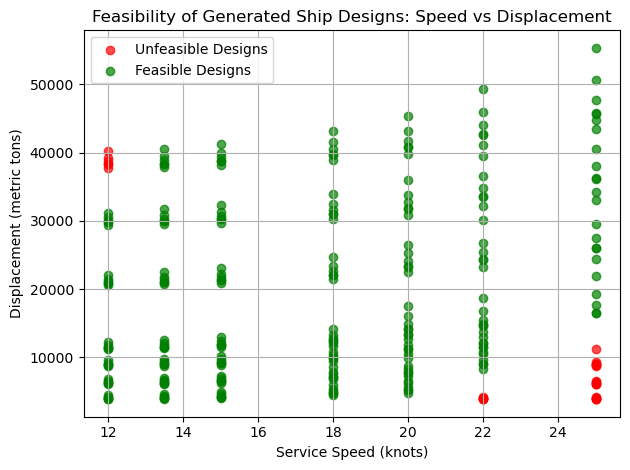

In [50]:
plt.scatter(none_df['Capacity'],none_df['Speed'], label='None Data')
plt.scatter(df_summary['Capacity'],df_summary['Speed'], label='Summary Data')
plt.title('Speed vs Capacity')
plt.ylabel('Speed (knots)')
plt.xlabel('Capacity (m³)')
plt.legend()
plt.show()

plt.scatter(none_df['Speed'], none_df['Displacement'], label='Unfeasible Designs', alpha=0.7, c='red')
plt.scatter(df_summary['Speed'], df_summary['Displacement'], label='Feasible Designs', alpha=0.7, c='green')
plt.title('Feasibility of Generated Ship Designs: Speed vs Displacement')
plt.xlabel('Service Speed (knots)')
plt.ylabel('Displacement (metric tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
df_summary['Fn'] = df_summary['Speed']*0.5144 /(np.sqrt(9.81*1.03*df_summary['Lpp']))

In [35]:
df_ship_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            944 non-null    int64         
 1   IMO/LR/IHS No.        944 non-null    int64         
 2   Built                 944 non-null    datetime64[ns]
 3   Deadweight            944 non-null    int64         
 4   Displacement          944 non-null    int64         
 5   GT                    944 non-null    int64         
 6   Ship Type             944 non-null    object        
 7   Length                944 non-null    float64       
 8   Length BP             944 non-null    float64       
 9   Breadth               944 non-null    float64       
 10  Depth                 944 non-null    float64       
 11  Draught               944 non-null    float64       
 12  Gas Capacity          944 non-null    int64         
 13  Service Speed       

In [34]:
%run Fundamentals/funcs.ipynb

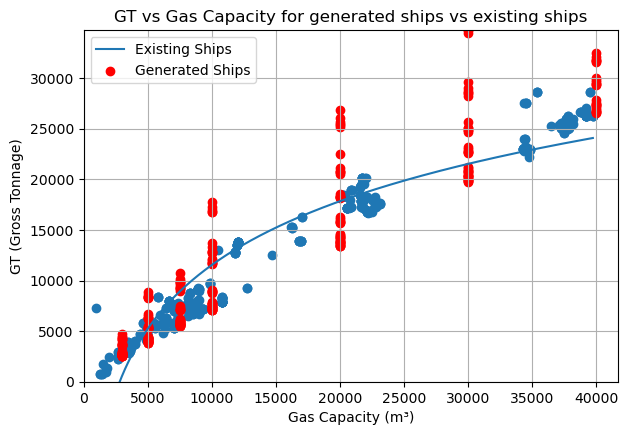

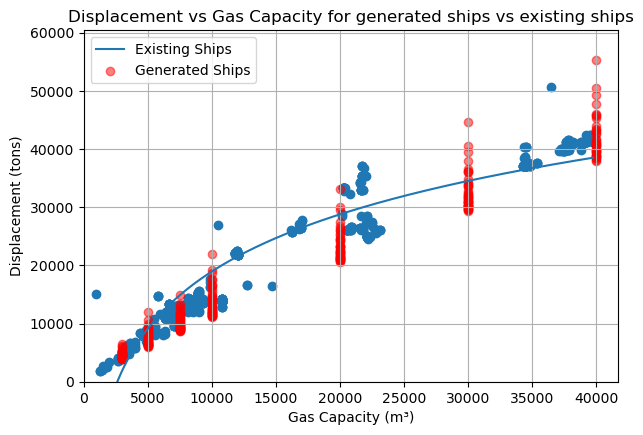

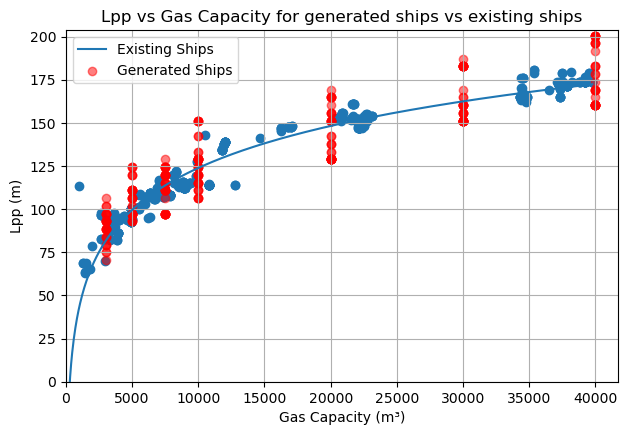

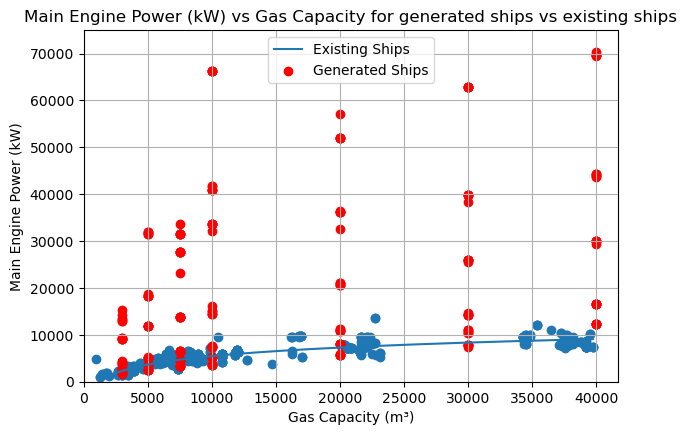

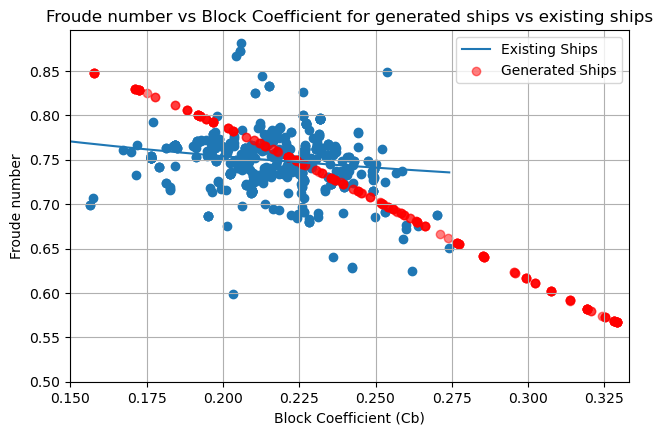

In [53]:
df_filtered = df_ship_compare[df_ship_compare['Gas Capacity'] <= 42000]


plot_model(df_filtered['Gas Capacity'], df_filtered['GT'],show=True,legend='Existing Ships')#,c=df_filtered['Service Speed'])
scatter = plt.scatter(df_summary['Capacity'], df_summary['GT'], label='Generated Ships',color='red')#c=df_summary['Speed'])
#plt.colorbar(scatter, label='Speed (knots)')
plt.xlabel('Gas Capacity (m³)')
plt.ylabel('GT (Gross Tonnage)')
plt.title('GT vs Gas Capacity for generated ships vs existing ships')
plt.legend()
plt.show()

plot_model(df_filtered['Gas Capacity'], df_filtered['Displacement'],show=True,legend='Existing Ships')
plt.scatter(df_summary['Capacity'], df_summary['Displacement'], label='Generated Ships', color='red',alpha=0.5)
plt.xlabel('Gas Capacity (m³)')
plt.ylabel('Displacement (tons)')
plt.title('Displacement vs Gas Capacity for generated ships vs existing ships')
plt.legend()
plt.show()

plot_model(df_filtered['Gas Capacity'], df_filtered['Length BP'],show=True,legend='Existing Ships')
plt.scatter(df_summary['Capacity'], df_summary['Lpp'], label='Generated Ships', color='red',alpha=0.5)
plt.xlabel('Gas Capacity (m³)')
plt.ylabel('Lpp (m)')
plt.title('Lpp vs Gas Capacity for generated ships vs existing ships')
plt.legend()
plt.show()


plot_model(df_filtered['Gas Capacity'], df_filtered['Total KW Main Eng'],show=True,legend='Existing Ships')
scatter = plt.scatter(df_summary['Capacity'], df_summary['Main Engine Power (kW)'], label='Generated Ships',color='red')# c=df_summary['Speed'])
#plt.colorbar(scatter, label='Speed (knots)', col)
plt.xlabel('Gas Capacity (m³)')
plt.ylabel('Main Engine Power (kW)')
plt.ylim(0,75000)
plt.title('Main Engine Power (kW) vs Gas Capacity for generated ships vs existing ships')
plt.legend()
plt.show()


plot_model(df_filtered['Fn'], df_filtered['CB'],show=True,legend='Existing Ships')
plt.scatter(df_summary['Fn'], df_summary['Cb'], label='Generated Ships', color='red',alpha=0.5)
plt.xlabel('Block Coefficient (Cb)')
plt.ylabel('Froude number')
plt.ylim(0.5)
plt.xlim(0.15,0.333)
plt.title('Froude number vs Block Coefficient for generated ships vs existing ships')
plt.legend()
plt.show()

C:\Users\Morten\AppData\Local\Temp\ipykernel_37404\1798855931.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Speed Bin'] = pd.cut(df_filtered['Service Speed'], bins=bins, labels=labels)


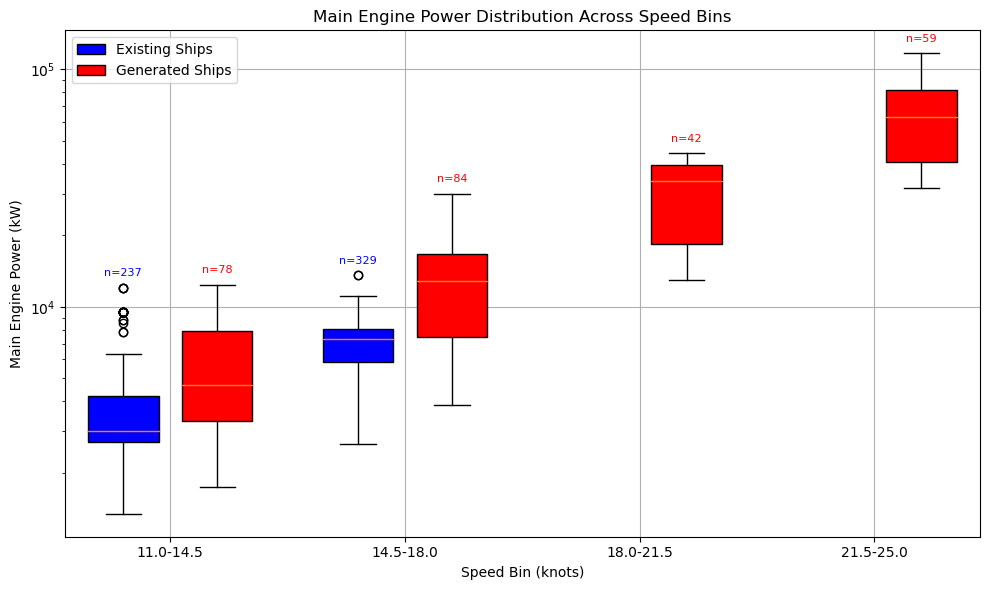

In [ ]:
# Define bins
size = 3.5
bins = np.arange(11, 27, size)  # 9-11, 11-13, ..., 25-27
labels = [f"{round(b,2)}-{round(b+size,2)}" for b in bins[:-1]]

# Categorize speed bins
df_filtered['Speed Bin'] = pd.cut(df_filtered['Service Speed'], bins=bins, labels=labels)
df_summary['Speed Bin'] = pd.cut(df_summary['Speed'], bins=bins, labels=labels)

# Drop '9-11' bin
#df_filtered = df_filtered[df_filtered['Speed Bin'] != '9-11']
#labels.pop(0)

# Prepare data
real_data = [df_filtered[df_filtered['Speed Bin'] == b]['Total KW Main Eng'].dropna() for b in labels]
gen_data = [df_summary[df_summary['Speed Bin'] == b]['Main Engine Power (kW)'].dropna() for b in labels]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
positions_real = np.arange(len(labels)) * 2.0
positions_gen = positions_real + 0.8

# Boxplots
bp1 = ax.boxplot(real_data, positions=positions_real, widths=0.6, patch_artist=True,
                 boxprops=dict(facecolor="blue"), labels=labels)
bp2 = ax.boxplot(gen_data, positions=positions_gen, widths=0.6, patch_artist=True,
                 boxprops=dict(facecolor="red"))

# Add counts above boxplots
for i, (real, gen) in enumerate(zip(real_data, gen_data)):
    if len(real) > 0:
        ax.text(positions_real[i], max(real) * 1.1, f"n={len(real)}",
                ha='center', va='bottom', fontsize=8, color='blue')

    if len(gen) > 0:
        ax.text(positions_gen[i], max(gen) * 1.1, f"n={len(gen)}",
                ha='center', va='bottom', fontsize=8, color='red')

# Labels and layout
ax.set_xticks(positions_real + 0.4)
ax.set_xticklabels(labels)
ax.set_xlabel('Speed Bin (knots)')
ax.set_ylabel('Main Engine Power (kW)')
ax.set_title('Main Engine Power Distribution Across Speed Bins')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Existing Ships', 'Generated Ships'])
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


In [167]:
fuels_sim_am = {
    'Main': {'Ammonia': 432, 'Diesel': 43},
    'Aux': {'Diesel': 200}
}

fuels_sim_di = {
    'Main': {'Diesel': 200},
    'Aux': {'Diesel': 200}
}

route_cache = {}

In [26]:
%run Fundamentals/funcs.ipynb

In [ ]:
#Memory and disk management
import glob
import os
os.makedirs("partials", exist_ok=True)
import gc

In [ ]:
AMMONIA_DENSITY_TON_PER_M3 = 0.68

def tons_to_m3(tons):
    return tons / AMMONIA_DENSITY_TON_PER_M3



time_log_prod = {}
ammount_fprod = {}

time_log_fa_s = {}
ammount_store = {}

time_log_bu_s = {}
ammount_bunke = {}

time_log_ship = {}
ammount_sship = {}

all_metrics = []
all_mode_logs = []

failed_bunkering_stats = []

concept = 182
sim_result1 = [loaded_results[concept],loaded_results[concept+1]]
sim_result2 = [loaded_results[concept]]
sim_result3 = [loaded_results[0], loaded_results[1],loaded_results[2], loaded_results[3], loaded_results[7], loaded_results[12]]
sim_result4 = [loaded_results[182], loaded_results[172], loaded_results[104], loaded_results[79], loaded_results[159], loaded_results[157]]
sim_result5 = [loaded_results[173]]
sim_result6 = [loaded_results[88]]

#for i in range(10):
        #sim_result.append(results[i*10])

days = 100
simultion_run = 0
simultion_end = 10
marked_states = [0.01,0.05,0.1]
pump_rate_m3ph_list = [250,500,750,1000]
marked_states = [0.1]
for m in marked_states:
    for pump_rate_m3ph in pump_rate_m3ph_list:
        for simultion_run in range(simultion_end):


            for idx, entry in enumerate(loaded_results):
                ship_obj = entry["ShipObj"]
                hull_data = entry["HullRow"]

                short_fuel = '' 
                main_fuel = entry["Main fuel"]
                if main_fuel == "Ammonia":
                    fuels_to_use = fuels_sim_am
                    short_fuel = 'A'
                else:
                    fuels_to_use = fuels_sim_di
                    short_fuel = 'D'
                
                print(f"Simulating ship {idx} with fuel {main_fuel} and pump rate {pump_rate_m3ph} m3/h")
                # Set up a fresh environment
                env = si.Environment()

                # Set up factory
                Hammerfest = Factory(env, fac_id=f"F_Hammerfest_{idx}", prod_rate_tph=40, store_cap_m3=40000, num_pumps=1, trans_cap_m3ph=600, pos=(23.63, 70.64))
                Narvik = Factory(env, fac_id=f"F_Narvik_{idx}", prod_rate_tph=51, store_cap_m3=30000, num_pumps=1, trans_cap_m3ph=600, pos=(17.40,68.44))
                Skipavika = Factory(env, fac_id=f"F_Skipavika_{idx}", prod_rate_tph=11, store_cap_m3=25000, num_pumps=1, trans_cap_m3ph=600, pos=(5.02,60.85))
                Suada = Factory(env, fac_id=f"F_Suada_{idx}", prod_rate_tph=23, store_cap_m3=25000, num_pumps=1, trans_cap_m3ph=600, pos=(6.38,59.65))
                #Herøya = Factory(env, fac_id=f"F{idx*2+1}_Herøya", prod_rate_tph=40, store_cap_m3=20000, num_pumps=1, trans_cap_m3ph=600, pos=(9.63,59.12))
                factories = [Suada,Skipavika,Narvik,Hammerfest]

                #Set up bunker
                
                Risavika = BunkerStation(env, bunk_id=f"B_Risavika_{idx}", num_pumps=1, pos=(5.59, 58.91),ammonia_rate=m,arrival_rate_day=4,ammonia_used_ton=300,storage_cap_m3=20000)
                Rotterdam = BunkerStation(env, bunk_id=f"B_Rotterdam_{idx}", num_pumps=1, pos=(4.04, 51.95),ammonia_rate=m,arrival_rate_day=25,storage_cap_m3=50000,ammonia_used_ton=500)
                #Frøya =  BunkerStation(env, bunk_id=f"B_Frøya_{idx}", num_pumps=1, pos=(8.78, 63.70),ammonia_rate=0.15,arrival_rate_day=12,storage_cap_m3=15000,ammonia_used_ton=80)
                
                bunkers = [Risavika,Rotterdam]
                
                
                #Set up ship
                ship = SimShip(env,
                            ship_id=f"Ship_{idx}_{pump_rate_m3ph}_{short_fuel}",
                            ship_design=ship_obj,
                            pump_rate_m3ph = pump_rate_m3ph , #m3/h
                            start_pos=(5.59, 58.91),
                            factories=factories,
                            bunkers=bunkers,
                            fuels=fuels_to_use)
                
                
                #ship2 = SimShip(env,
                            #ship_id=f"Ship_{idx* 2 + 1}_{pump_rate_m3ph}_{short_fuel}",
                            #ship_design=ship_obj,
                            #pump_rate_m3ph =pump_rate_m3ph,
                            #start_pos=(4.04, 51.95),
                            #factories=factories,
                            #bunkers=bunkers,
                            #fuels=fuels_to_use)

                ships = [ship]
                # Run the simulation for set amount of days
                env.run(until=60 * 24 * days)

                # Store results
                all_mode_logs.append((ship.ship_id, ship.mode_log))
                failed_bunkering_stats.append(sum(b.failed_deliveries for b in bunkers))
                
                metrics = collect_sim_metrics(ships, entry)

                for i in range(len(ships)):
                    metrics[i]['Failed bunkering'] = (sum(b.failed_deliveries for b in bunkers)/len(ships))
                    metrics[i]['Pump rate (m3/h)'] = pump_rate_m3ph
                    metrics[i]['Simulation run'] = simultion_run
                all_metrics.extend(metrics)

            # Save results to CSV
            filename = f"partials/partial_m{int(m*100)}_p{pump_rate_m3ph}_r{simultion_run}.csv"
            df_sim_results = pd.DataFrame(all_metrics)
            df_sim_results.to_csv(filename, index=False)
            print(f"Saved partial: {filename}")
            
            # Clear for next marked state
            all_metrics = []
            all_mode_logs = []
            failed_bunkering_stats = []

            # Clear logs if needed
            time_log_prod.clear()
            ammount_fprod.clear()
            time_log_fa_s.clear()
            ammount_store.clear()
            time_log_bu_s.clear()
            ammount_bunke.clear()
            time_log_ship.clear()
            ammount_sship.clear()




            # Delete everything else
            del env, ship, ships, factories, bunkers
            del Hammerfest, Narvik, Skipavika, Suada
            del Risavika, Rotterdam
            gc.collect()



    pattern = f"partials/partial_m{int(m*100)}_p*_r*.csv"
    files = glob.glob(pattern)
    combined = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    combined.to_csv(f"simulation_results_m{int(m*100)}.csv", index=False)
    print(f"Combined and saved: simulation_results_m{int(m*100)}.csv")

Simulating ship 0 with fuel Diesel and pump rate 250 m3/h
Simulating ship 1 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 2 with fuel Diesel and pump rate 250 m3/h
Simulating ship 3 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 4 with fuel Diesel and pump rate 250 m3/h
Simulating ship 5 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 6 with fuel Diesel and pump rate 250 m3/h
Simulating ship 7 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 8 with fuel Diesel and pump rate 250 m3/h
Simulating ship 9 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 10 with fuel Diesel and pump rate 250 m3/h
Simulating ship 11 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 12 with fuel Diesel and pump rate 250 m3/h
Simulating ship 13 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 14 with fuel Diesel and pump rate 250 m3/h
Simulating ship 15 with fuel Ammonia and pump rate 250 m3/h
Simulating ship 16 with fuel Diesel and pump rate 250 m3/h

In [ ]:
df_sim_results


Ship ID  Range (nm)  Speed (knots)  Capacity (m3)           GT  \
0  Ship_0_500_A        1300           12.0           3000  2546.917868   

   Displacement (ton) Main fuel  Fuel Consumed (ton)  Diesel Burnt (ton)  \
0          4165.10261   Ammonia          1474.021057          273.495748   

   Ammonia Burnt (ton)  Cargo Delivered (ton)  Distance Travelled (nm)  \
0          1200.525309                40800.0             22281.664486   

   Bulding Cost (MNOK)  Main engine (kW)  CO2 Emissions (ton)  \
0            74.997543           1789.22           875.186393   

   CO2 ton/cargo ton      EEOI  Crew  Port Calls  Time in sailing (min)  \
0           0.021451  0.000039    15          41          112997.148787   

   Time in maneuvering (min)  Time in loading (min)  Time in waiting (min)  \
0                9662.851213                 6300.0                 7840.0   

   Time in unloading (min)  Failed bunkering  Pump rate (m3/h)  Simulation run  
0                   7200.0           45500.0               500               0

In [27]:
df_sim_results = pd.read_csv('simulation_results_m5.csv')
#df_sim_results.to_csv('sim_results_høy_uten_frøya.csv', index=False)

In [ ]:
for i in failed_bunkering_stats:
    if i > 0:
        print(i)

In [377]:
route_cache

{((5.59, 58.91), (6.38, 59.65)): 49.31191392935241,
 ((5.59, 58.91), (5.02, 60.85)): 182.60199753702426,
 ((5.59, 58.91), (17.4, 68.44)): 881.0501799194107,
 ((5.59, 58.91), (23.63, 70.64)): 978.2364923451046,
 ((6.38, 59.65), (5.02, 60.85)): 217.36777435346409,
 ((6.38, 59.65), (17.4, 68.44)): 915.8159567358506,
 ((6.38, 59.65), (23.63, 70.64)): 1013.0022691615445,
 ((6.38, 59.65), (5.59, 58.91)): 49.31191392935241,
 ((6.38, 59.65), (4.04, 51.95)): 512.6248829037859,
 ((4.04, 51.95), (6.38, 59.65)): 512.6248829037859,
 ((4.04, 51.95), (5.02, 60.85)): 582.8621795192388,
 ((4.04, 51.95), (17.4, 68.44)): 1281.3103619016256,
 ((4.04, 51.95), (23.63, 70.64)): 1378.4966743273194,
 ((5.02, 60.85), (6.38, 59.65)): 217.36777435346409,
 ((5.02, 60.85), (17.4, 68.44)): 728.1895713312255,
 ((5.02, 60.85), (23.63, 70.64)): 825.3758837569194,
 ((5.02, 60.85), (4.04, 51.95)): 582.8621795192389,
 ((5.02, 60.85), (5.59, 58.91)): 182.60199753702426,
 ((5.59, 58.91), (5.59, 58.91)): 0,
 ((5.59, 58.91), 

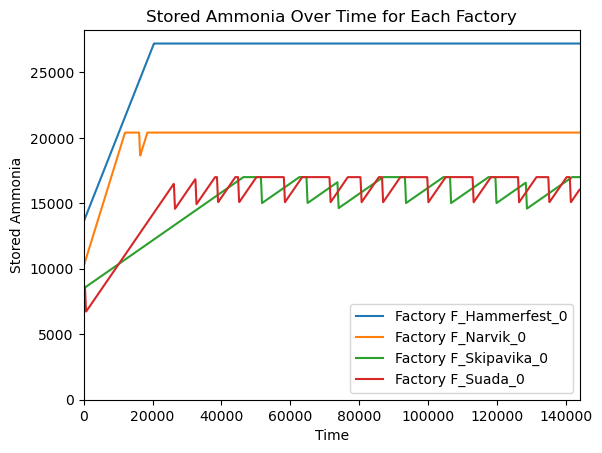

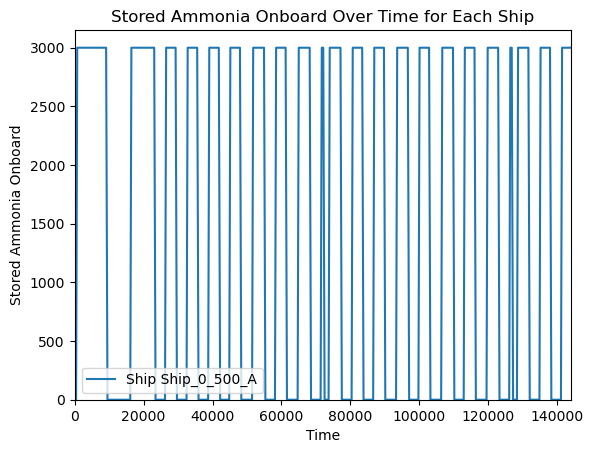

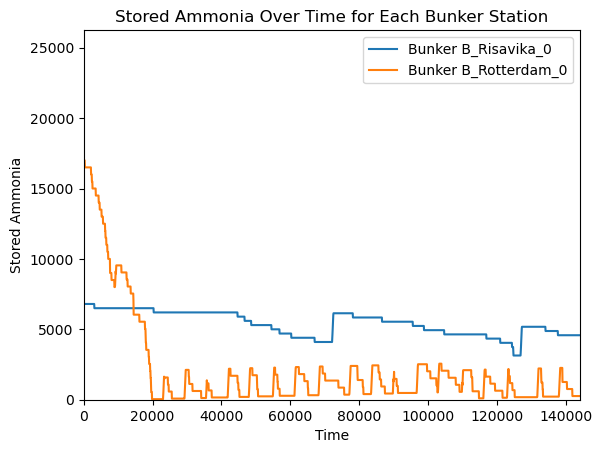

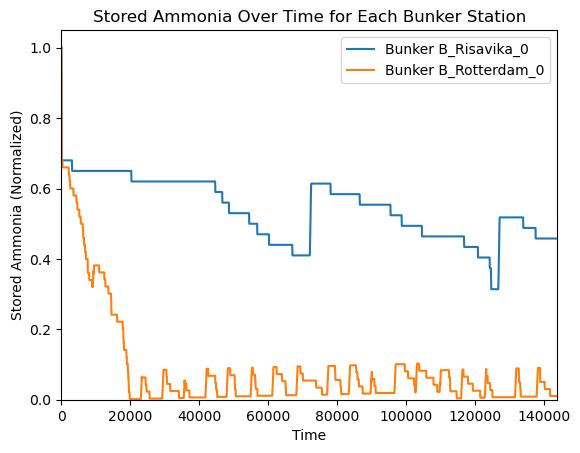

In [ ]:
# Plotting for each factory
for fac_id in time_log_fa_s:
    plt.plot(time_log_fa_s[fac_id], ammount_store[fac_id], label=f'Factory {fac_id}')
plt.xlabel('Time')
plt.ylabel('Stored Ammonia')
plt.title('Stored Ammonia Over Time for Each Factory')
plt.xlim(0, 60*24*days)
plt.ylim(0)
plt.legend() if len(ammount_bunke) < 10 else None
plt.show()

# Plotting for each ship
for ship_id in time_log_ship:
    plt.plot(time_log_ship[ship_id], ammount_sship[ship_id], label=f'Ship {ship_id}')
plt.xlabel('Time')
plt.ylabel('Stored Ammonia Onboard')
plt.title('Stored Ammonia Onboard Over Time for Each Ship')
plt.xlim(0, 60*24*days)
plt.ylim(0)
plt.legend() if len(ammount_bunke) < 10 else None
plt.show()

# Plotting for each bunker station  
for bunk_id in time_log_bu_s:
    plt.plot(time_log_bu_s[bunk_id], ammount_bunke[bunk_id], label=f'Bunker {bunk_id}')
plt.xlabel('Time')  
plt.ylabel('Stored Ammonia')
plt.title('Stored Ammonia Over Time for Each Bunker Station')
plt.xlim(0, 60*24*days)
plt.ylim(0)
plt.legend() if len(ammount_bunke) < 10 else None
plt.show()

# Plotting for each bunker station  
for bunk_id in time_log_bu_s:
    values = np.array(ammount_bunke[bunk_id])
    plt.plot(
        time_log_bu_s[bunk_id],
        values / max(values),
        label=f'Bunker {bunk_id}'
    )

plt.xlabel('Time')  
plt.ylabel('Stored Ammonia (Normalized)')
plt.title('Stored Ammonia Over Time for Each Bunker Station')
plt.xlim(0, 60 * 24 * days)
plt.ylim(0, 1.05)
if len(ammount_bunke) < 10: plt.legend()
plt.show()


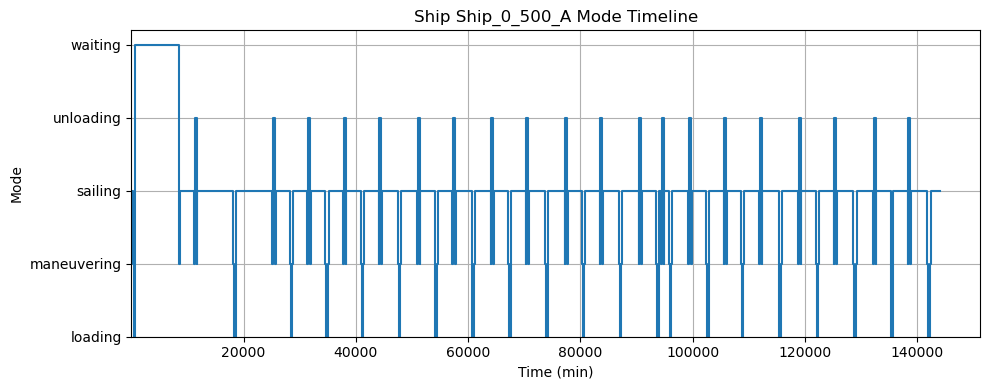

In [ ]:
# Choose one ship log to plot (e.g., the last one)
sim_case = 0
selected_ship_id, mode_log = all_mode_logs[sim_case]

times = [t for t, _ in mode_log]

modes = [m for _, m in mode_log]
unique_modes = sorted(set(modes)) 
mode_map = {mode: i for i, mode in enumerate(unique_modes)}
mode_values = [mode_map[m] for m in modes]

times.append(days*24*60)  # Add the end time of the simulation
mode_values.append(mode_map[modes[-1]])  # Repeat the last mode for the last time point

plt.figure(figsize=(10, 4))
plt.step(times, mode_values, where='post')
plt.yticks(list(mode_map.values()), list(mode_map.keys()))
plt.xlabel("Time (min)")
plt.ylabel("Mode")
plt.title(f"Ship {selected_ship_id} Mode Timeline")
plt.grid(True)
plt.tight_layout()
plt.xlim(1)
plt.ylim(0)
plt.show()


In [378]:
df_sim_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10520 entries, 0 to 10519
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ship ID                    10520 non-null  object 
 1   Range (nm)                 10520 non-null  int64  
 2   Speed (knots)              10520 non-null  float64
 3   Capacity (m3)              10520 non-null  int64  
 4   GT                         10520 non-null  float64
 5   Displacement (ton)         10520 non-null  float64
 6   Main fuel                  10520 non-null  object 
 7   Fuel Consumed (ton)        10520 non-null  float64
 8   Diesel Burnt (ton)         10520 non-null  float64
 9   Ammonia Burnt (ton)        10520 non-null  float64
 10  Cargo Delivered (ton)      10520 non-null  float64
 11  Distance Travelled (nm)    10520 non-null  float64
 12  Bulding Cost (MNOK)        10520 non-null  float64
 13  Main engine (kW)           10520 non-null  flo

In [28]:
# Constants
LHV_NH3_MJ_per_ton = 18.6 * 1000
LHV_Diesel_MJ_per_ton = 42.7 * 1000

df_energy = df_sim_results.copy()

# Create new columns in the df_sim_results DataFrame
df_energy["Energy Used (MJ)"] = df_energy.apply(
    lambda row: row["Ammonia Burnt (ton)"] * LHV_NH3_MJ_per_ton + row['Diesel Burnt (ton)'] * LHV_Diesel_MJ_per_ton,
    axis=1
)

df_energy = df_energy[['Ship ID','Main fuel','GT','Speed (knots)','Capacity (m3)','Pump rate (m3/h)','Energy Used (MJ)','Cargo Delivered (ton)']]

df_energy["Energy used per ton cargo (MJ/ton)"] = df_energy["Energy Used (MJ)"] / df_energy["Cargo Delivered (ton)"]
df_energy["Cargo Energy Content (MJ)"] = df_energy["Cargo Delivered (ton)"] * LHV_NH3_MJ_per_ton
df_energy["Shipping Energy Share"] = df_energy["Energy Used (MJ)"] / df_energy["Cargo Energy Content (MJ)"]
df_energy["Transport Energy Efficiency"] = 1 - df_energy["Shipping Energy Share"]


#df_energy['Transport Energy Efficiency'].hist()
#plt.show()
#df_energy['Energy used per ton cargo (MJ/ton)'].hist()
#plt.show()
df_sim_results['Transport Energy Efficiency'] = df_energy['Transport Energy Efficiency']



In [313]:
unserviced_factories = []

for fac_id, levels in ammount_store.items():
    max_level = max(levels)
    if all(level == max_level for level in levels[-10:]):  # last few entries constant at max
        unserviced_factories.append(fac_id)

print("Unserviced (or poorly serviced) factories:", unserviced_factories)


Unserviced (or poorly serviced) factories: ['F_Hammerfest_0', 'F_Narvik_0', 'F_Skipavika_0', 'F_Hammerfest_1', 'F_Narvik_1', 'F_Hammerfest_2', 'F_Narvik_2', 'F_Hammerfest_3', 'F_Narvik_3', 'F_Hammerfest_4', 'F_Narvik_4', 'F_Hammerfest_5', 'F_Narvik_5', 'F_Hammerfest_6', 'F_Narvik_6', 'F_Hammerfest_7', 'F_Narvik_7', 'F_Hammerfest_8', 'F_Narvik_8', 'F_Hammerfest_9', 'F_Narvik_9', 'F_Hammerfest_10', 'F_Narvik_10', 'F_Hammerfest_11', 'F_Narvik_11', 'F_Hammerfest_12', 'F_Narvik_12', 'F_Skipavika_12', 'F_Hammerfest_13', 'F_Narvik_13', 'F_Hammerfest_14', 'F_Narvik_14', 'F_Hammerfest_15', 'F_Narvik_15', 'F_Hammerfest_16', 'F_Narvik_16', 'F_Hammerfest_17', 'F_Narvik_17', 'F_Hammerfest_18', 'F_Narvik_18', 'F_Hammerfest_19', 'F_Narvik_19', 'F_Hammerfest_20', 'F_Narvik_20', 'F_Hammerfest_21', 'F_Narvik_21', 'F_Hammerfest_22', 'F_Narvik_22', 'F_Hammerfest_23', 'F_Narvik_23', 'F_Hammerfest_24', 'F_Narvik_24', 'F_Hammerfest_25', 'F_Narvik_25', 'F_Hammerfest_26', 'F_Narvik_26', 'F_Hammerfest_27', 'F_N

In [ ]:
def is_monotonic_increasing(data):
    return all(x <= y for x, y in zip(data, data[1:]))

unserviced_factories = []

for fac_id, levels in ammount_store.items():
    if is_monotonic_increasing(levels):
        unserviced_factories.append(fac_id)

print("Factories that are never drawn from:", unserviced_factories)


Factories that are never drawn from: []


In [ ]:
pd.set_option("display.max_columns", None)


In [172]:
df_sim_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10520 entries, 0 to 10519
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ship ID                      10520 non-null  object 
 1   Range (nm)                   10520 non-null  int64  
 2   Speed (knots)                10520 non-null  float64
 3   Capacity (m3)                10520 non-null  int64  
 4   GT                           10520 non-null  float64
 5   Displacement (ton)           10520 non-null  float64
 6   Main fuel                    10520 non-null  object 
 7   Fuel Consumed (ton)          10520 non-null  float64
 8   Diesel Burnt (ton)           10520 non-null  float64
 9   Ammonia Burnt (ton)          10520 non-null  float64
 10  Cargo Delivered (ton)        10520 non-null  float64
 11  Distance Travelled (nm)      10520 non-null  float64
 12  Bulding Cost (MNOK)          10520 non-null  float64
 13  Main engine (kW)

In [6]:
# Set a maximum number of columns to display (e.g., 100)
pd.set_option("display.max_columns", 100)


In [314]:
df_sim_results

Ship ID  Range (nm)  Speed (knots)  Capacity (m3)            GT  \
0       Ship_0_1000_D         600           12.0           3000   2502.498548   
1       Ship_1_1000_A         600           12.0           3000   2518.496051   
2       Ship_2_1000_D         600           12.0           5000   3850.257638   
3       Ship_3_1000_A         600           12.0           5000   3872.007047   
4       Ship_4_1000_D         600           12.0           7500   5494.549500   
...               ...         ...            ...            ...           ...   
10515  Ship_258_750_A        2000           25.0          20000  26893.186976   
10516  Ship_259_750_D        2000           25.0          30000  35052.541226   
10517  Ship_260_750_A        2000           25.0          30000  36347.962793   
10518  Ship_261_750_D        2000           25.0          40000  43612.560602   
10519  Ship_262_750_A        2000           25.0          40000  45033.525686   

       Displacement (ton) Main fuel  Fuel Consumed (ton)  Diesel Burnt (ton)  \
0             3862.766938    Diesel           736.803153          736.803153   
1             3956.465558   Ammonia          1501.890829          275.884393   
2             6043.491796    Diesel           878.863155          878.863155   
3             6168.667212   Ammonia          1738.850717          354.885876   
4             8689.600297    Diesel           826.508174          826.508174   
...                   ...       ...                  ...                 ...   
10515        33120.053893   Ammonia         10043.500642         1250.146398   
10516        37970.971189    Diesel          5570.008733         5570.008733   
10517        44722.600613   Ammonia         14753.794638         1699.867937   
10518        47730.491766    Diesel          6581.460224         6581.460224   
10519        55349.467704   Ammonia         14398.104165         1696.220164   

       Ammonia Burnt (ton)  Cargo Delivered (ton)  Distance Travelled (nm)  \
0                 0.000000                46920.0             22963.654184   
1              1226.006436                44880.0             21931.219909   
2                 0.000000                68000.0             19606.955701   
3              1383.964841                64600.0             18995.706990   
4                 0.000000                62492.0             12500.206421   
...                    ...                    ...                      ...   
10515          8793.354244                68000.0              7155.557502   
10516             0.000000                60220.8              7510.564468   
10517         13053.926701                73735.8              8791.874830   
10518             0.000000                54400.0              6636.399046   
10519         12701.884001                64039.0              7450.004303   

       Bulding Cost (MNOK)  Main engine (kW)  CO2 Emissions (ton)  \
0                74.319989           1828.70          2357.770091   
1                74.564135           1828.70           882.830057   
2               114.394235           2422.14          2812.362097   
3               114.712370           2422.14          1135.634802   
4               162.442464           3261.74          2644.826157   
...                    ...               ...                  ...   
10515           504.014643          83735.10          4000.468474   
10516           674.484001         102387.27         17824.027945   
10517           687.015776         102719.31          5439.577398   
10518           843.219070         116958.62         21060.672718   
10519           856.123013         116958.62          5427.904524   

       CO2 ton/cargo ton      EEOI  Crew  Port Calls  Time in sailing (min)  \
0               0.050251  0.000101    15          47          115353.999989   
1               0.019671  0.000040    15          45          112548.606802   
2               0.041358  0.000084    17          41           98982.353475  

In [29]:
days = 100
cost_df = pd.DataFrame()
cost_df["Ship ID"] = df_sim_results["Ship ID"]
cost_df['GT'] = df_sim_results["GT"]
cost_df['Speed'] = df_sim_results["Speed (knots)"]
cost_df['Capacity'] = df_sim_results["Capacity (m3)"]
cost_df['Range'] = df_sim_results["Range (nm)"]
cost_df['Pump rate (m3/h)'] = df_sim_results["Pump rate (m3/h)"]
cost_df['Crew'] = df_sim_results["Crew"]
cost_df['Cargo Delivered (ton)'] = df_sim_results["Cargo Delivered (ton)"]
cost_df['Main Fuel'] = df_sim_results["Main fuel"]
cost_df['CO2 per ton cargo (ton)'] = df_sim_results["CO2 Emissions (ton)"] / df_sim_results["Cargo Delivered (ton)"]
cost_df['EEOI'] = df_sim_results["EEOI"]
cost_df["Transport Energy Efficiency"] = df_sim_results["Transport Energy Efficiency"]
cost_df['Failed bunkering'] = df_sim_results["Failed bunkering"]
cost_df['Building Cost (MNOK)'] = df_sim_results["Bulding Cost (MNOK)"]

# Define constants
GT_cost_per_call = 5
crew_salary = 2500
ammonia_cost_per_ton = 12000
diesel_cost_per_ton = 5500


ad_coeff = np.array([710,710,930,930,1000,1000,1030,1030]) * 10
cap_ad = np.array([3000,5000,6000,8000,12000,15000,30000,40000])

# Calculate components (in MNOK)
cost_df["Admin Cost (MNOK)"] = np.interp(cost_df["Capacity"], cap_ad, ad_coeff)*365 / 1e6
cost_df["Crew Salary (MNOK)"] = (df_sim_results["Crew"] * crew_salary )*365 / 1e6
cost_df['Insurance (MNOK)'] = (df_sim_results['Bulding Cost (MNOK)'] * 0.008)
cost_df['Maintenance (MNOK)'] = (df_sim_results['Bulding Cost (MNOK)'] * 0.01)
cost_df['Drewry Annual Cost (MNOK)'] = cost_df["Admin Cost (MNOK)"] + cost_df["Crew Salary (MNOK)"] + cost_df['Insurance (MNOK)'] + cost_df['Maintenance (MNOK)']


cost_df["Port Call Cost (MNOK)"] = (df_sim_results["Port Calls"] * df_sim_results["GT"] * GT_cost_per_call) / 1e6 * (365/days)
cost_df["Ammonia Fuel Cost (MNOK)"] = (df_sim_results["Ammonia Burnt (ton)"] * ammonia_cost_per_ton) / 1e6 * (365/days)
cost_df["Diesel Fuel Cost (MNOK)"] = (df_sim_results["Diesel Burnt (ton)"] * diesel_cost_per_ton) / 1e6 * (365/days)



# Yearly extrapolation

cost_df["Yearly Running Cost (MNOK)"] = cost_df['Drewry Annual Cost (MNOK)'] + cost_df["Port Call Cost (MNOK)"] + cost_df["Ammonia Fuel Cost (MNOK)"] + cost_df["Diesel Fuel Cost (MNOK)"]


cost_df['Daily Running Cost (MNOK)'] = cost_df["Yearly Running Cost (MNOK)"]/365






#cost_df['Drewry Daily Cost'] = cost_df['Drewry Daily Cost'] * 1e3

# Assumptions
discount_rate = 0.1
lifetime_years = 25

# Present value of annuity factor
#annuity_factor = (1 - (1 + discount_rate)**-lifetime_years) / discount_rate

annuity_factor = (((1 + discount_rate)**lifetime_years) - 1) / (discount_rate * ((1 + discount_rate)**lifetime_years))

# NPV of operating cost
cost_df["NPV OPEX (MNOK)"] = cost_df["Yearly Running Cost (MNOK)"] * annuity_factor

# Total discounted cost
cost_df["Total Discounted Cost (MNOK)"] = cost_df["Building Cost (MNOK)"] + cost_df["NPV OPEX (MNOK)"] - cost_df['Building Cost (MNOK)']  * 0.1  

# Normalize cargo delivered to yearly amount
cost_df["Yearly Cargo Delivered (ton)"] = cost_df["Cargo Delivered (ton)"] * (365 / days)

# Normalize cargo
cost_df["Lifetime Delivered Cargo (ton)"] = cost_df["Yearly Cargo Delivered (ton)"] * lifetime_years

# Requied freight rate (RFR) in NOK/Ton

cost_df['RFR (NOK/Ton)'] = cost_df['Total Discounted Cost (MNOK)']*1e6 / (cost_df['Yearly Cargo Delivered (ton)'] * annuity_factor * 0.8)

cost_df['Transport cost precetage of total production cost'] = (cost_df['RFR (NOK/Ton)'] /ammonia_cost_per_ton) * 100


exchange_rate_nok_eur = 11.5
lhv_ammonia_mwh_per_ton = 5.167

cost_df["RFR (EUR/Ton)"] = cost_df["RFR (NOK/Ton)"] / exchange_rate_nok_eur
cost_df["Transport Cost (€/MWhNH3,LHV)"] = cost_df["RFR (EUR/Ton)"] / lhv_ammonia_mwh_per_ton







cost_df = cost_df.sort_values(by="RFR (NOK/Ton)", ascending=True)
cost_df

Ship ID            GT  Speed  Capacity  Range  Pump rate (m3/h)  \
8418     Ship_2_750_D   3850.257638   12.0      5000    600               750   
9996     Ship_2_750_D   3850.257638   12.0      5000    600               750   
6314     Ship_2_500_D   3850.257638   12.0      5000    600               500   
9470     Ship_2_750_D   3850.257638   12.0      5000    600               750   
2       Ship_2_1000_D   3850.257638   12.0      5000    600              1000   
...               ...           ...    ...       ...    ...               ...   
788   Ship_262_1000_A  45033.525686   25.0     40000   2000              1000   
3418   Ship_262_250_A  45033.525686   25.0     40000   2000               250   
9116   Ship_174_750_A  44169.830242   25.0     40000   1300               750   
9905   Ship_174_750_A  44169.830242   25.0     40000   1300               750   
9467   Ship_262_750_A  45033.525686   25.0     40000   2000               750   

      Crew  Cargo Delivered (ton) Main Fuel  CO2 per ton cargo (ton)  ...  \
8418    17                71400.0    Diesel                 0.040906  ...   
9996    17                71400.0    Diesel                 0.041147  ...   
6314    17                68000.0    Diesel                 0.040820  ...   
9470    17                68000.0    Diesel                 0.041135  ...   
2       17                68000.0    Diesel                 0.041358  ...   
...    ...                    ...       ...                      ...  ...   
788     26                54400.0   Ammonia                 0.094123  ...   
3418    26                54400.0   Ammonia                 0.096865  ...   
9116    26                57562.0   Ammonia                 0.097905  ...   
9905    26                54400.0   Ammonia                 0.100791  ...   
9467    26                54400.0   Ammonia                 0.101394  ...   

      Yearly Running Cost (MNOK)  Daily Running Cost (MNOK)  NPV OPEX (MNOK)  \
8418                   41.507400                   0.113719       376.764330   
9996                   41.615491                   0.114015       377.745477   
6314                   40.387523                   0.110651       366.599165   
9470                   40.592103                   0.111211       368.456141   
2                      40.687229                   0.111472       369.319609   
...                          ...                        ...              ...   
788                   598.368179                   1.639365      5431.411902   
3418                  619.138763                   1.696271      5619.947329   
9116                  672.693712                   1.842996      6106.067743   
9905                  650.166407                   1.781278      5901.586494   
9467                  654.154757                   1.792205      5937.788906   

      Total Discounted Cost (MNOK)  Yearly Cargo Delivered (ton)  \
8418                    479.719141                      260610.0   
9996                    480.700288                      260610.0   
6314                    469.553976                      248200.0   
9470                    471.410952                      248200.0   
2                       472.274420                      248200.0   
...                            ...                           ...   
788                    6201.922614                      198560.0   
3418                   6390.458040                      198560.0   
9116                   6869.534445                      210101.3   
9905                   6665.053197                      198560.0   
9467                   6708.299618                      198560.0   

      Lifetime Delivered Cargo (ton)  RFR (NOK/Ton)  \
8418                       6515250.0     253.490527   
9996                       6515250.0     254.008979   
6314                       6205000.0     260.525062   
9470                       6205000.0     261.555378   
2                          6205000.0     262.034460   
...     

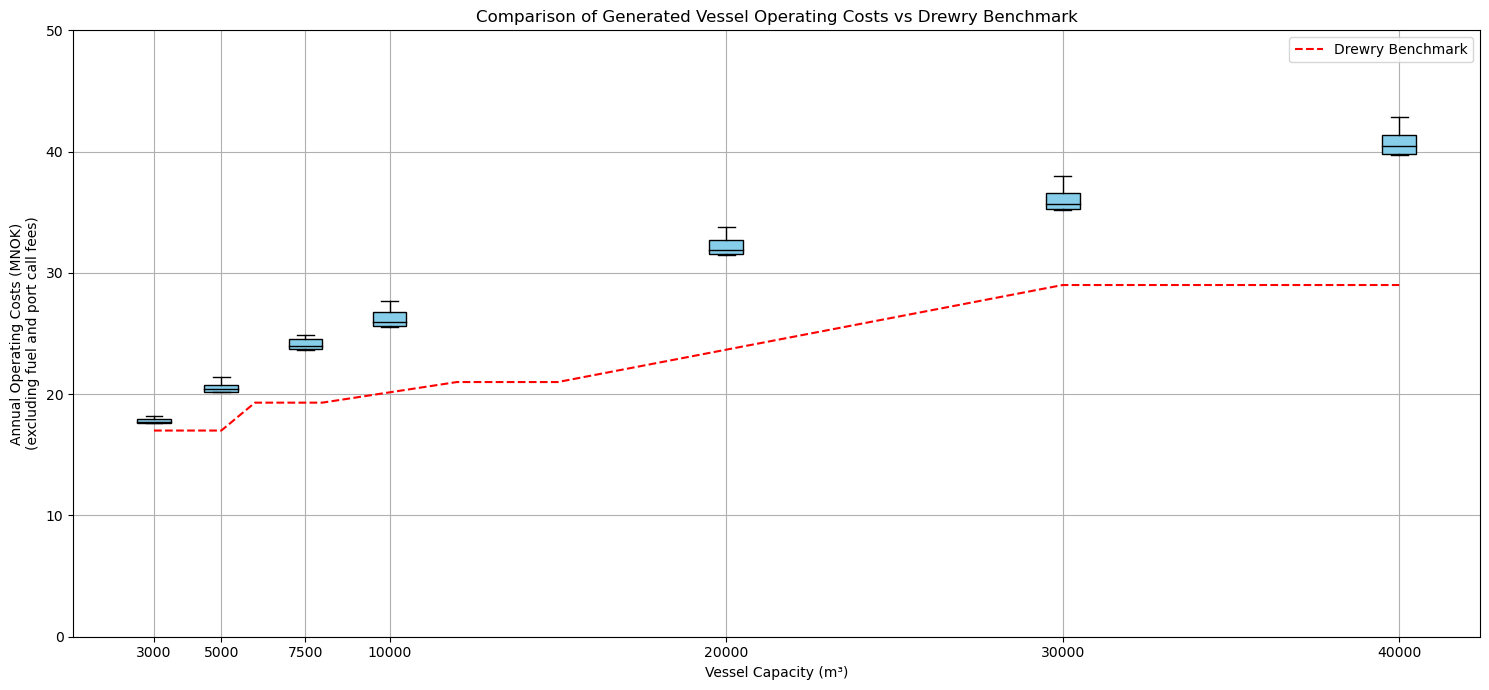

In [54]:
# Recreate the plot using only matplotlib (no seaborn)
plt.figure(figsize=(15, 7))

# Create unique capacities and prepare data
unique_capacities = sorted(cost_df['Capacity'].unique())
positions = range(len(unique_capacities))

# Prepare data for boxplot using matplotlib
data_to_plot = [cost_df[cost_df['Capacity'] == cap]['Drewry Annual Cost (MNOK)'].values for cap in unique_capacities]

# Draw boxplot
plt.boxplot(data_to_plot, positions=unique_capacities, widths=1000, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none'))

# Plot Drewry benchmark line (scaled appropriately)
plt.plot(cap_ad, drewry_cost, 'r--', label='Drewry Benchmark')

# Final plot setup
plt.legend()
plt.title('Comparison of Generated Vessel Operating Costs vs Drewry Benchmark')
plt.xlabel('Vessel Capacity (m³)')
plt.ylabel('Annual Operating Costs (MNOK)\n(excluding fuel and port call fees)')
plt.grid(True)
plt.tight_layout()
plt.ylim(0,50)
plt.show()


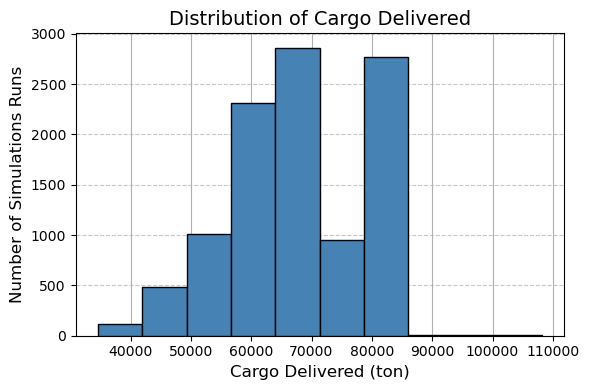

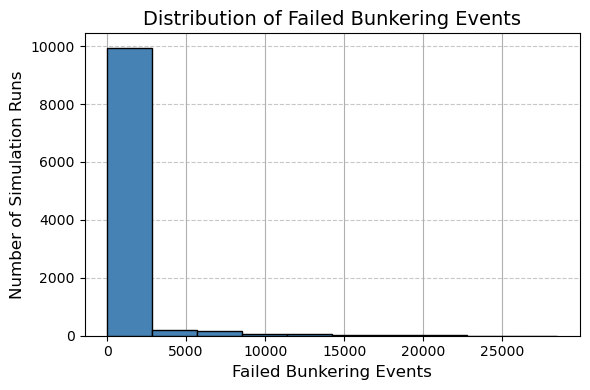

In [71]:
plt.figure(figsize=(6, 4))
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)  # grid behind bars

cost_df['Cargo Delivered (ton)'].hist(
    bins=10,
    edgecolor='black',
    color='steelblue',
    alpha=1,
    zorder=3  # bars drawn on top of the grid
)

plt.title("Distribution of Cargo Delivered", fontsize=14)
plt.xlabel("Cargo Delivered (ton)", fontsize=12)
plt.ylabel("Number of Simulations Runs", fontsize=12)
plt.tight_layout()
plt.show()




plt.figure(figsize=(6, 4))
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)  # grid behind bars

cost_df['Failed bunkering'].hist(
    bins=10,
    edgecolor='black',
    color='steelblue',
    alpha=1,
    zorder=3  # bars on top of grid
)

plt.title("Distribution of Failed Bunkering Events", fontsize=14)
plt.xlabel("Failed Bunkering Events", fontsize=12)
plt.ylabel("Number of Simulation Runs", fontsize=12)
plt.tight_layout()
plt.show()


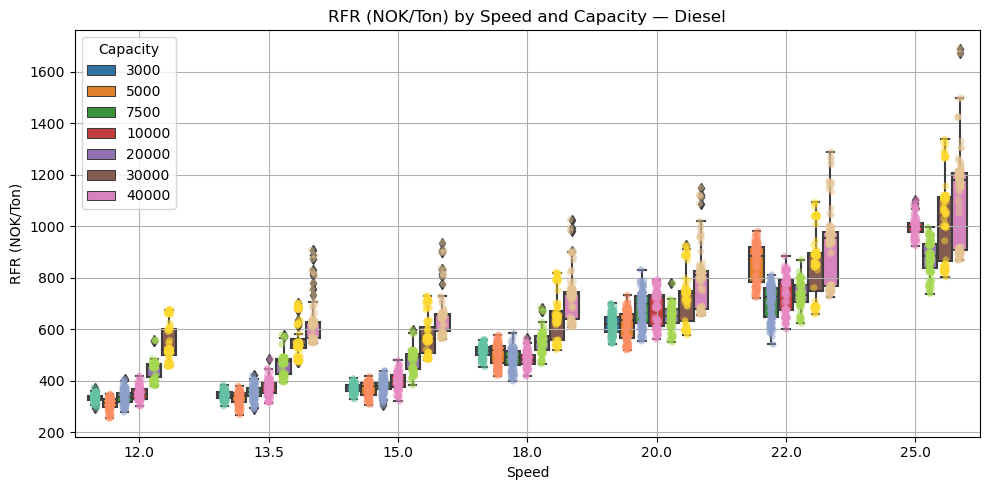

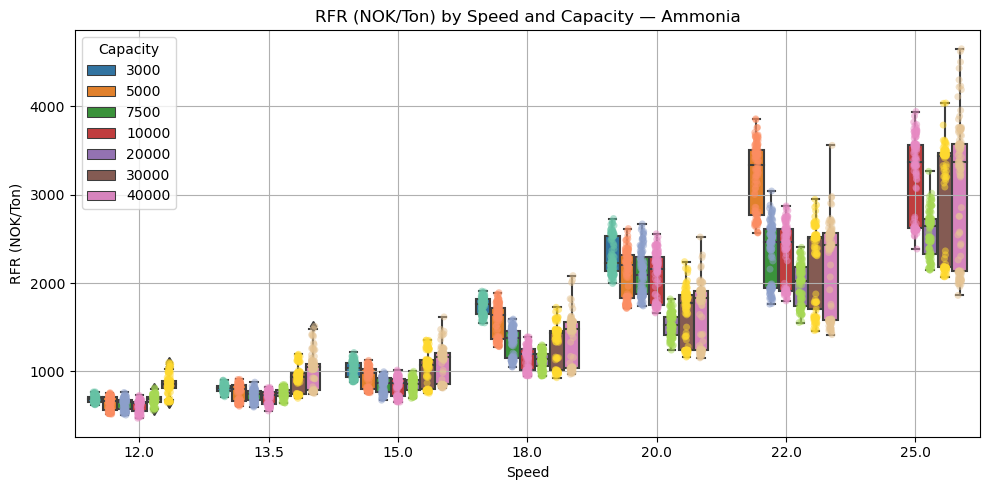

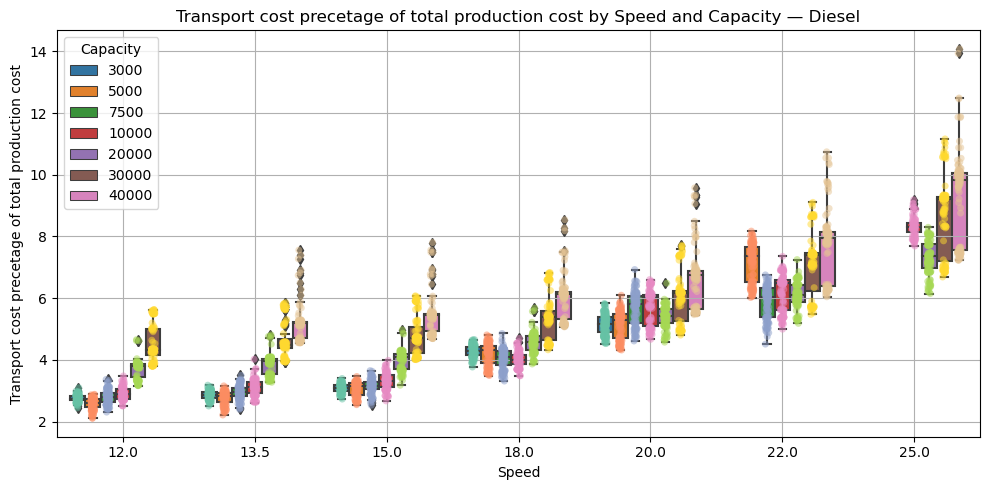

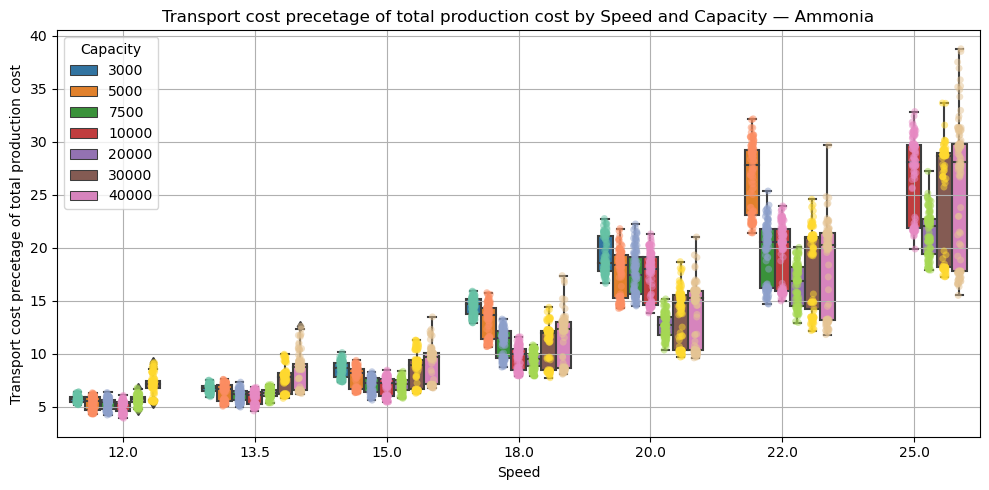

In [72]:
# Step 0: Define variables
x_col = "Speed"
y_col = "RFR (NOK/Ton)"
hue_col = "Capacity"
color_col = "Pump rate (m3/h)"

# Sort orderings once
x_order = sorted(cost_df[x_col].unique())
hue_order = sorted(cost_df[hue_col].unique())

# Step 1: Loop over each fuel type
for fuel_type in ["Diesel", "Ammonia"]:
    subset = cost_df[cost_df["Main Fuel"] == fuel_type].copy()
    # Step 2: Plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=subset, x=x_col, y=y_col, hue=hue_col, order=x_order, hue_order=hue_order)
    sns.stripplot(data=subset, x=x_col, y=y_col, hue=hue_col, order=x_order, hue_order=hue_order,
                palette="Set2", dodge=True, alpha=0.5, jitter=True,legend=False)

    # Step 3: Customization
    #plt.colorbar(scatter, label="Pump Rate (m³/h)")
    plt.xticks(ticks=range(len(x_order)), labels=x_order)
    plt.title(f"RFR (NOK/Ton) by Speed and Capacity — {fuel_type}")
    plt.ylabel("RFR (NOK/Ton)")
    plt.xlabel(x_col)
    plt.grid(True)
    plt.legend(title=hue_col)
    plt.tight_layout()
    plt.show()




y_col = 'Transport cost precetage of total production cost'
# Step 1: Loop over each fuel type
for fuel_type in ["Diesel", "Ammonia"]:
    subset = cost_df[cost_df["Main Fuel"] == fuel_type].copy()
    # Step 2: Plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=subset, x=x_col, y=y_col, hue=hue_col, order=x_order, hue_order=hue_order)
    sns.stripplot(data=subset, x=x_col, y=y_col, hue=hue_col, order=x_order, hue_order=hue_order,
                palette="Set2", dodge=True, alpha=0.5, jitter=True,legend=False)

    # Step 3: Customization
    #plt.colorbar(scatter, label="Pump Rate (m³/h)")
    plt.xticks(ticks=range(len(x_order)), labels=x_order)
    plt.title(f"Transport cost precetage of total production cost by Speed and Capacity — {fuel_type}")
    plt.ylabel("Transport cost precetage of total production cost")
    plt.xlabel(x_col)
    plt.grid(True)
    plt.legend(title=hue_col)
    plt.tight_layout()
    plt.show()


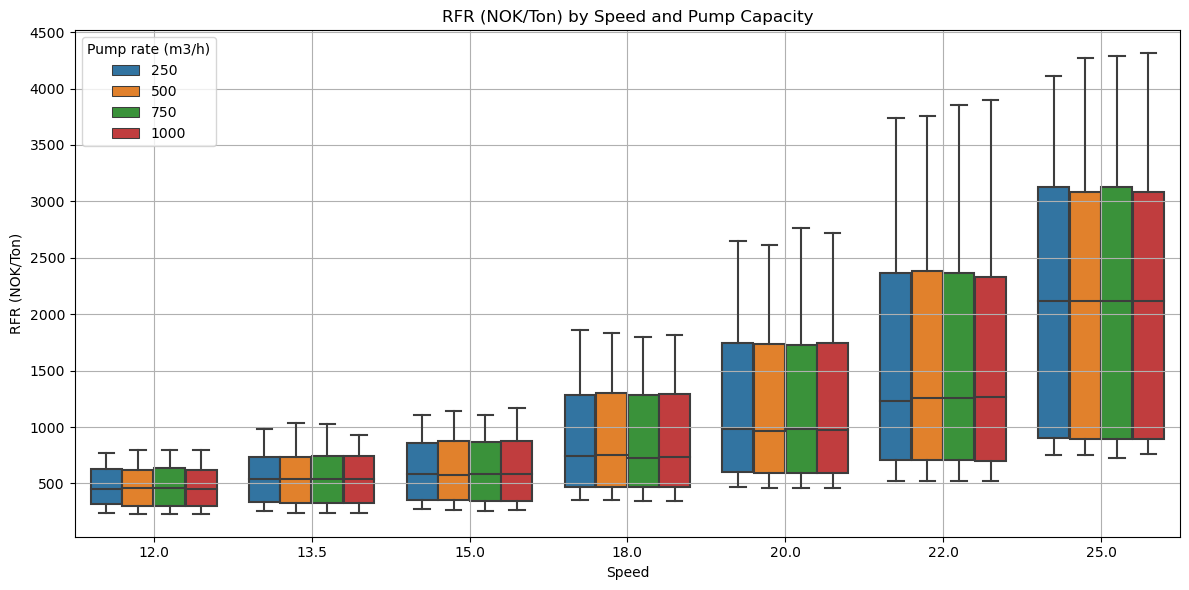

In [383]:
# Step 0: Define variables
x_col = "Speed"
y_col = "RFR (NOK/Ton)"
hue_col = "Pump rate (m3/h)"

# Sort orderings once
x_order = sorted(cost_df[x_col].unique())
hue_order = sorted(cost_df[hue_col].unique())


subset = cost_df[cost_df["Main Fuel"] == fuel_type].copy()
# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=cost_df, x=x_col, y=y_col, hue=hue_col, order=x_order, hue_order=hue_order)


# Step 3: Customization
#plt.colorbar(scatter, label="Pump Rate (m³/h)")
plt.xticks(ticks=range(len(x_order)), labels=x_order)
plt.title(f"RFR (NOK/Ton) by Speed and Pump Capacity")
plt.ylabel("RFR (NOK/Ton)")
plt.xlabel(x_col)
plt.grid(True)
plt.legend(title=hue_col)
plt.tight_layout()


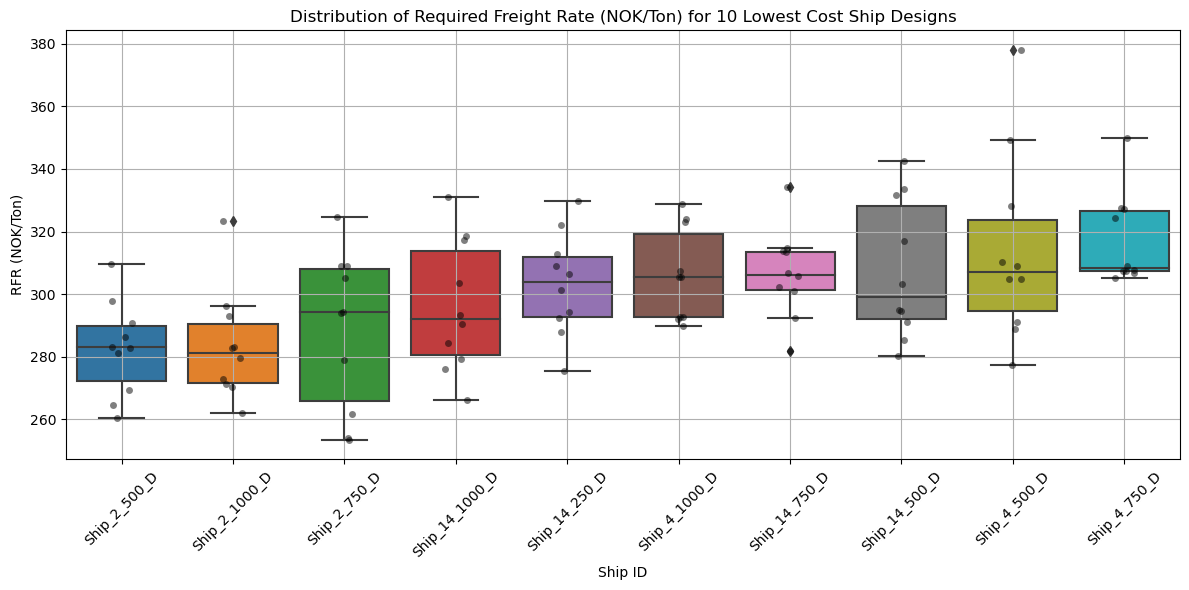

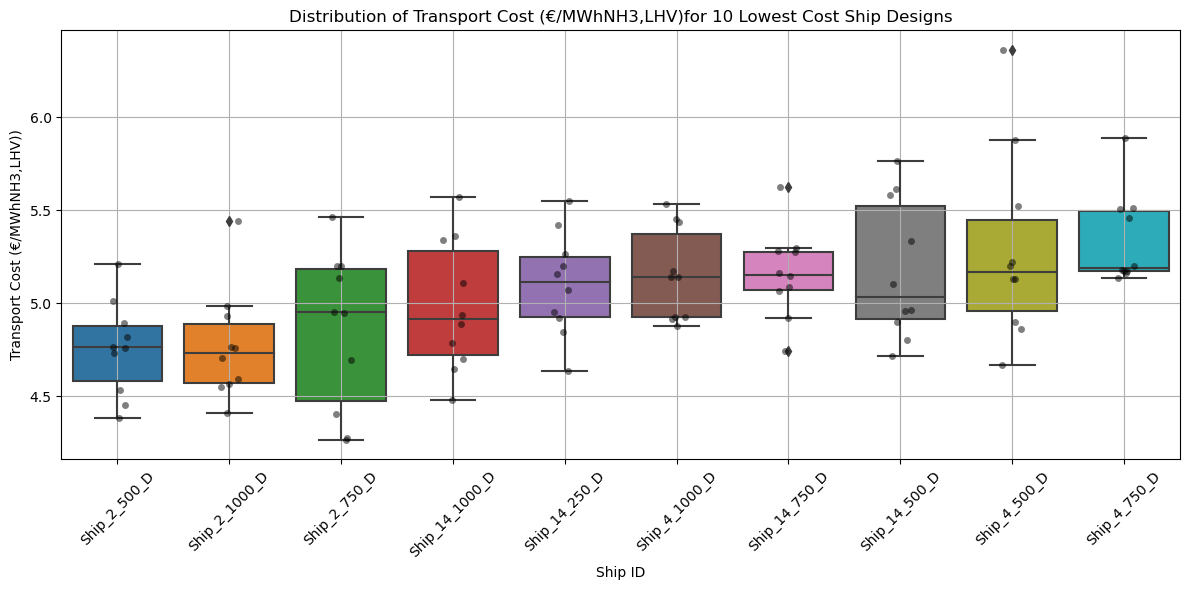

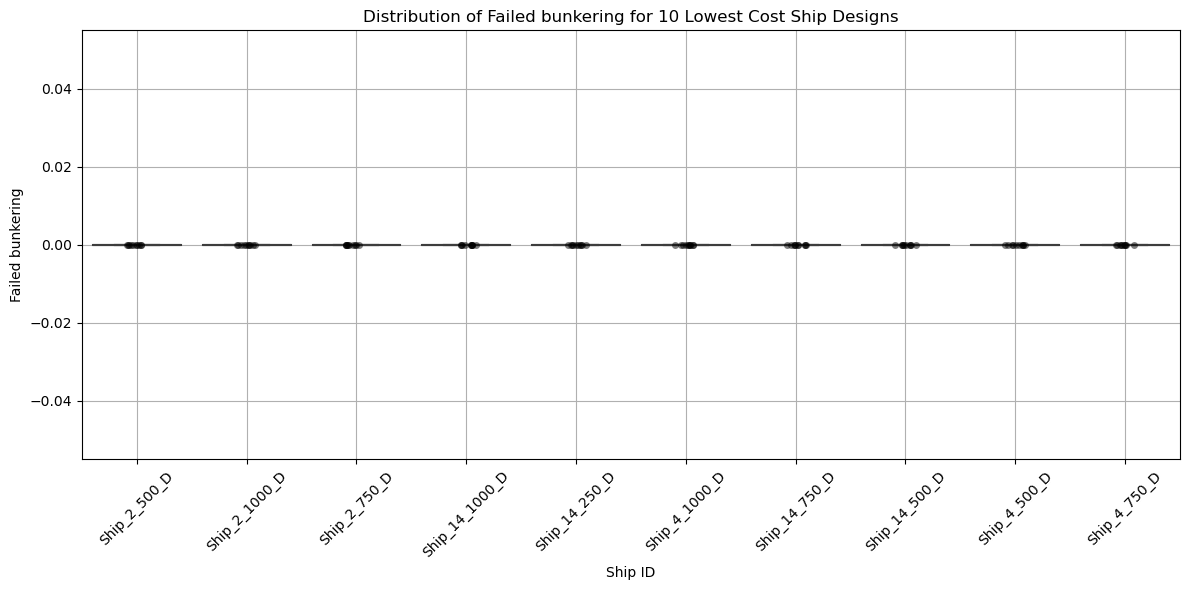

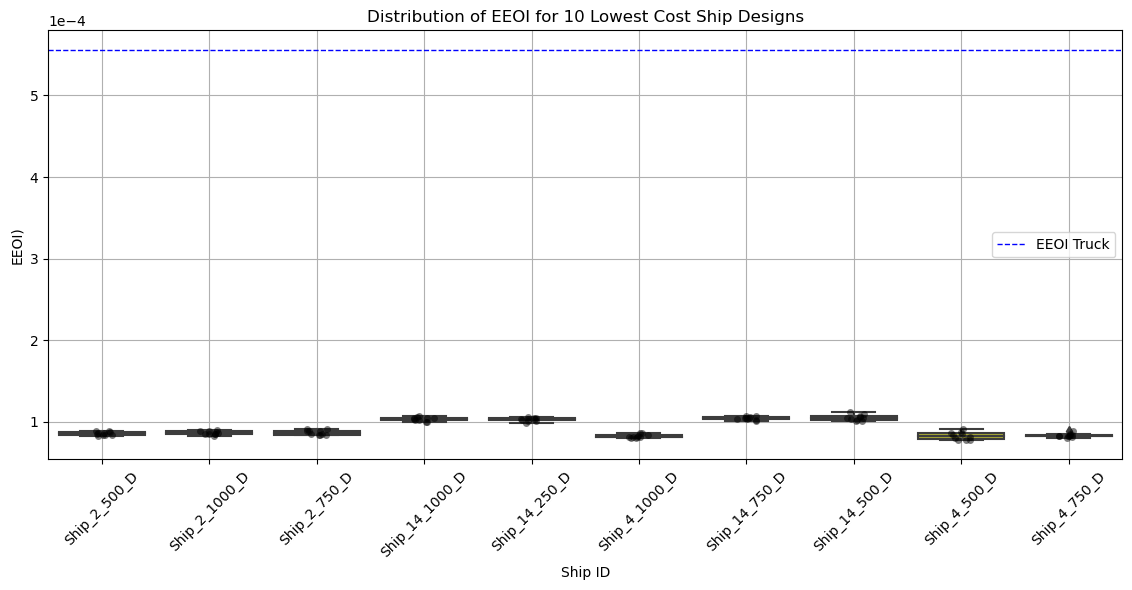

In [33]:
# Step 1: Filter groups with mean of zero failed bunkering
valid_ship_ids = (
    cost_df
    .groupby("Ship ID")["Failed bunkering"]
    .mean()
    .loc[lambda x: x <= 0]
    .index
)

# Step 2: Filter full dataset to only valid ships
cost_df_zero_failures = cost_df[cost_df["Ship ID"].isin(valid_ship_ids)]

# Step 3: Get top 10 groups with lowest mean RFR (from zero-failure dataset)
top10_rfr = (
    cost_df_zero_failures
    .groupby("Ship ID")["RFR (NOK/Ton)"]
    .mean()
    .sort_values()
    .head(10)
)

# Step 4: Filter to those groups
filtered_cost_df = cost_df_zero_failures[cost_df_zero_failures["Ship ID"].isin(top10_rfr.index)]

# Step 5: Extract unique ship numbers from ID
unique_ship_ids = filtered_cost_df['Ship ID'].apply(lambda x: int(x.split('_')[1])).unique().tolist()

# Step 6: Recalculate means in filtered set to ensure ordering is accurate
ordered_groups = (
    filtered_cost_df
    .groupby("Ship ID")["RFR (NOK/Ton)"]
    .mean()
    .sort_values()
    .index.tolist()
)



# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="RFR (NOK/Ton)", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="RFR (NOK/Ton)", order=ordered_groups,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Required Freight Rate (NOK/Ton) for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("RFR (NOK/Ton)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="Transport Cost (€/MWhNH3,LHV)", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="Transport Cost (€/MWhNH3,LHV)", order=ordered_groups,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Transport Cost (€/MWhNH3,LHV)for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("Transport Cost (€/MWhNH3,LHV))")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="Failed bunkering", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="Failed bunkering",order=ordered_groups ,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Failed bunkering for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("Failed bunkering")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="EEOI", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="EEOI",order=ordered_groups ,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of EEOI for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("EEOI)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.axhline(y=5.56e-4, color='blue', linestyle='--', linewidth=1,label='EEOI Truck')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='center right')
plt.show()



In [397]:
# Extract numeric Ship ID from 'Ship ID' column in filtered_cost_df
filtered_cost_df['Ship_Index'] = filtered_cost_df['Ship ID'].apply(lambda x: int(x.split('_')[1]))

# Compute median RFR and EEOI per ship index
df_medians = (
    filtered_cost_df
    .groupby('Ship_Index')[['RFR (NOK/Ton)', 'EEOI']]
    .median()
)

# Select relevant columns from df_summary
selected_df = df_summary.loc[unique_ship_ids, [
    'GT',
    'Displacement',
    'Capacity',
    'Speed',
    'Range',
    'Lpp',
    'B',
    'T',
    'Main Engine Power (kW)'
]].copy()

# Add Ship ID column
selected_df['Ship ID'] = selected_df.index

# Join with median RFR and EEOI
selected_df = selected_df.join(df_medians, on='Ship ID')

# Round numeric columns
int_cols = ['GT', 'Displacement', 'Capacity', 'Speed', 'Range', 'Main Engine Power (kW)', 'RFR (NOK/Ton)']
selected_df[int_cols] = selected_df[int_cols].round(0).astype('Int64')

# Round geometric dimensions to 1 decimal
selected_df['Lpp'] = selected_df['Lpp'].round(1)
selected_df['B'] = selected_df['B'].round(1)
selected_df['T'] = selected_df['T'].round(1)

# Format EEOI to scientific notation with 2 decimals
selected_df['EEOI'] = selected_df['EEOI'].apply(lambda x: f"{x:.2E}")

# Reorder final columns
selected_df = selected_df[[
    'Ship ID', 'GT', 'Displacement', 'Capacity', 'Speed', 'Range',
    'Lpp', 'B', 'T', 'Main Engine Power (kW)', 'RFR (NOK/Ton)', 'EEOI'
]].sort_values(by='Ship ID')

selected_df

C:\Users\Morten\AppData\Local\Temp\ipykernel_27688\1391709955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cost_df['Ship_Index'] = filtered_cost_df['Ship ID'].apply(lambda x: int(x.split('_')[1]))


Ship ID     GT  Displacement  Capacity  Speed  Range    Lpp     B    T  \
123      123  20830         30201     30000     15   1300  155.7  27.5  9.5   
135      135  15784         22100     20000     18   1300  137.8  25.5  8.2   
137      137  22682         30964     30000     18   1300  151.2  29.6  9.5   
149      149  18210         23271     20000     20   1300  151.2  25.5  8.2   
211      211  20911         30678     30000     15   2000  155.7  27.5  9.5   
225      225  22800         31647     30000     18   2000  151.2  29.6  9.5   

     Main Engine Power (kW)  RFR (NOK/Ton)      EEOI  
123                   14137            397  4.62E-05  
135                   20706            397  1.05E-04  
137                   25916            476  6.76E-05  
149                   36215            512  1.55E-04  
211                   14137            390  4.82E-05  
225                   25916            469  7.01E-05

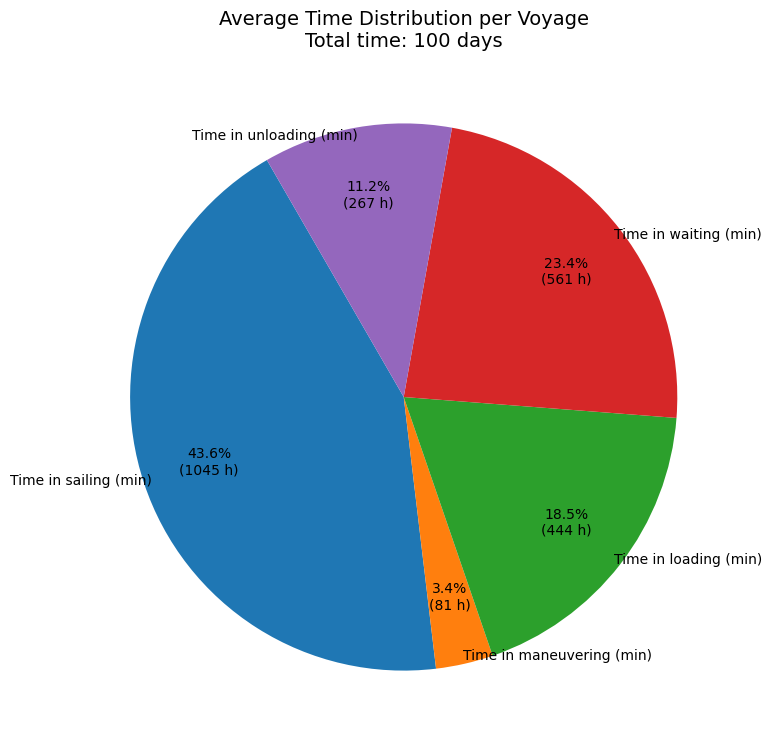

In [398]:
# Step 1: Extract list of Ship IDs from filtered_cost_df
filtered_ship_ids = filtered_cost_df['Ship ID'].unique()

# Step 2: Filter df_sim_results to only include these Ship IDs
df_sim_results_fil = df_sim_results[df_sim_results['Ship ID'].isin(filtered_ship_ids)].copy()

# Define the list of time columns
time_columns = [
    'Time in sailing (min)',
    'Time in maneuvering (min)',
    'Time in loading (min)',
    'Time in waiting (min)',
    'Time in unloading (min)'
]

# Compute the mean of those columns
mean_time_df = df_sim_results_fil[time_columns].mean().to_frame(name='Mean Time (min)')

# Optional: Round to 1 decimal
mean_time_df = mean_time_df.round(1)

# Get mean times and convert to hours
mean_times = df_sim_results_fil[time_columns].mean()
mean_hours = (mean_times / 60).round(0)  # Convert to hours for labels

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    mean_times,
    labels=[f"{label}" for label in mean_times.index],
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct * mean_times.sum() / 6000)} h)",  # Total / 60 min * 100
    startangle=120,
    labeldistance=0.97,  # Push labels slightly outward
    textprops={'fontsize': 10},
    pctdistance=0.75,
)

plt.title(f"Average Time Distribution per Voyage\nTotal time: {round(mean_times.sum()/(24*60))} days", fontsize=14)
plt.tight_layout()
plt.show()



In [399]:
# Generate describe table
desc = filtered_cost_df[['Transport Energy Efficiency', 'Transport Cost (€/MWhNH3,LHV)']].describe()

# Round everything to 2 decimals except count
desc_rounded = desc.copy()
desc_rounded.loc[desc.index != 'count'] = desc.loc[desc.index != 'count'].round(2)
desc_rounded.loc['count'] = desc.loc['count'].round(0).astype(int)

# Move 'count' to the bottom
desc_reordered = desc_rounded.drop(index='count')
desc_reordered.loc['count'] = desc_rounded.loc['count']

desc_reordered


Transport Energy Efficiency  Transport Cost (€/MWhNH3,LHV)
mean                          0.93                           7.67
std                           0.02                           0.88
min                           0.88                           6.11
25%                           0.92                           6.72
50%                           0.92                           7.89
75%                           0.95                           8.49
max                           0.95                           9.60
count                       100.00                         100.00

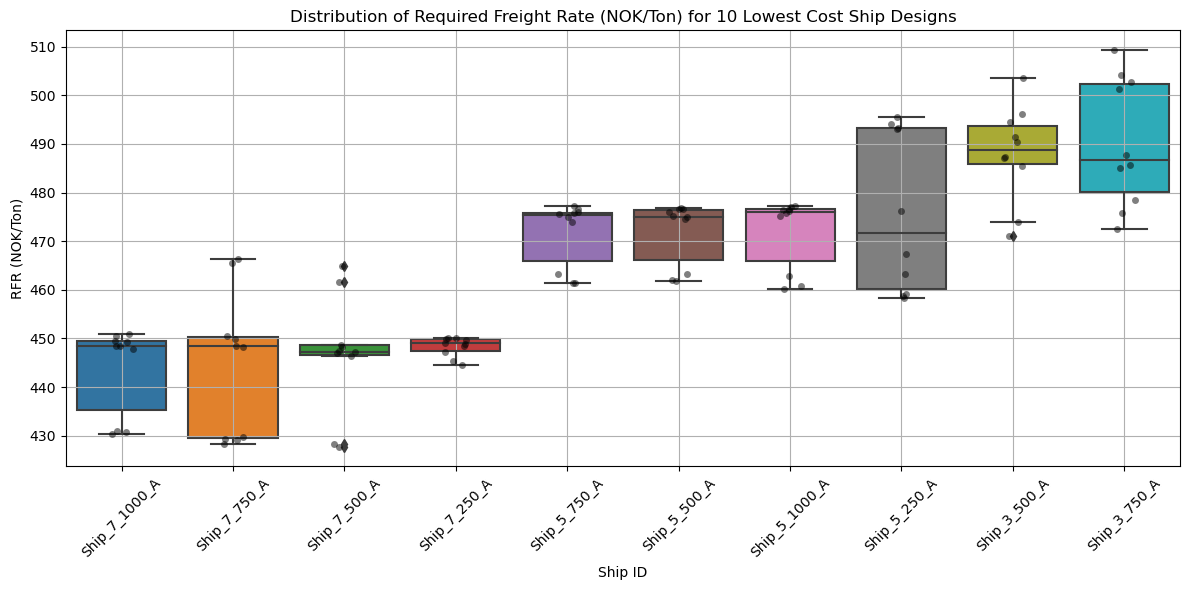

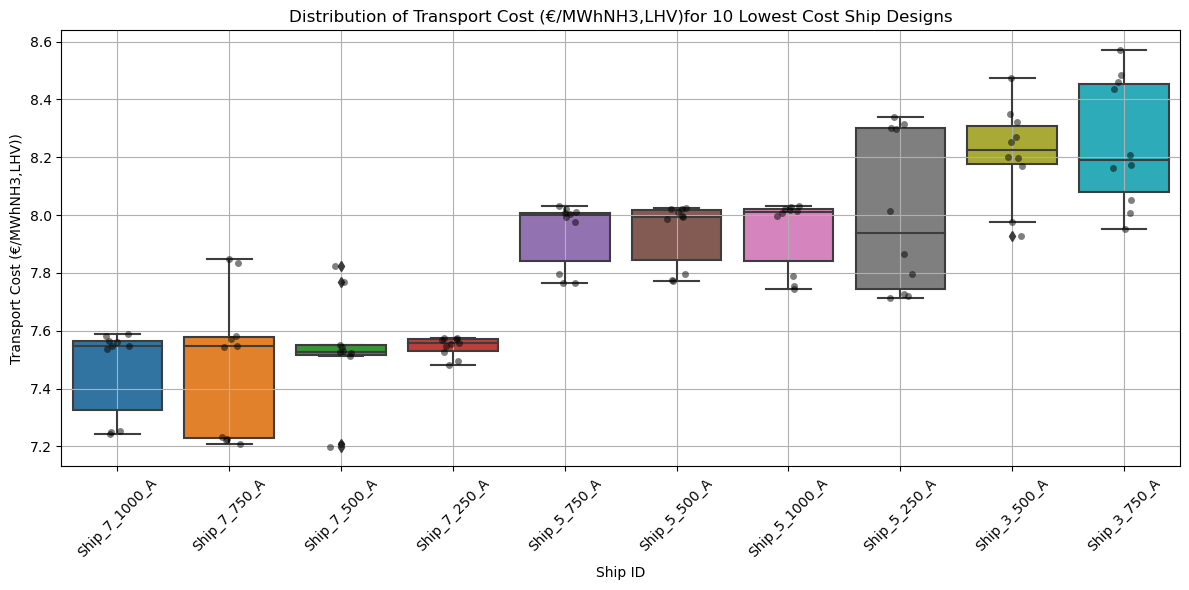

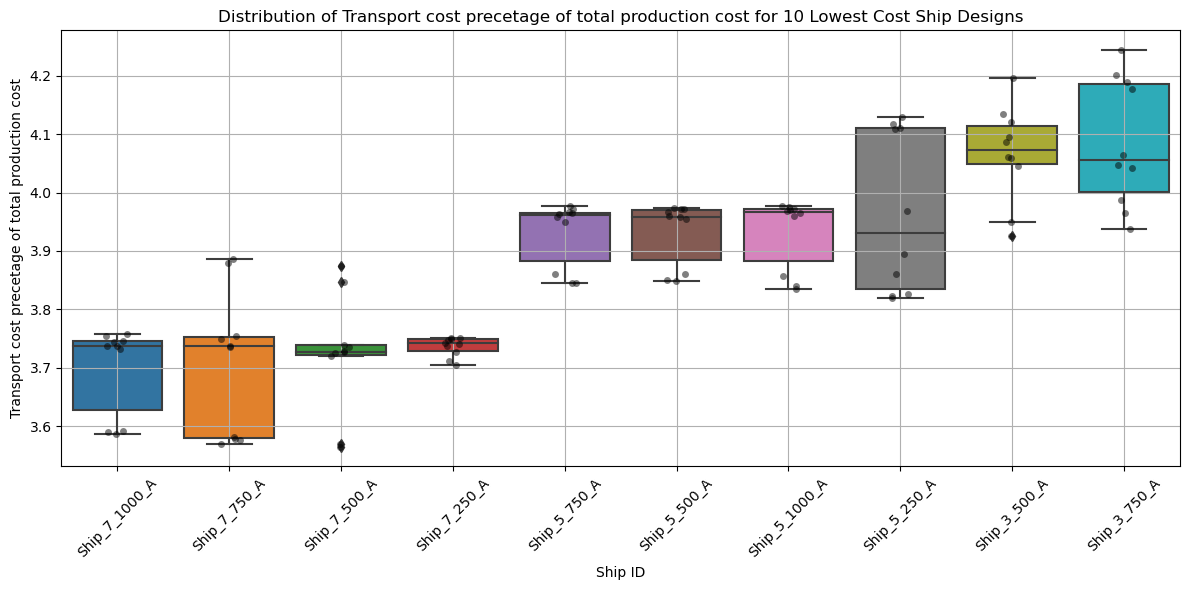

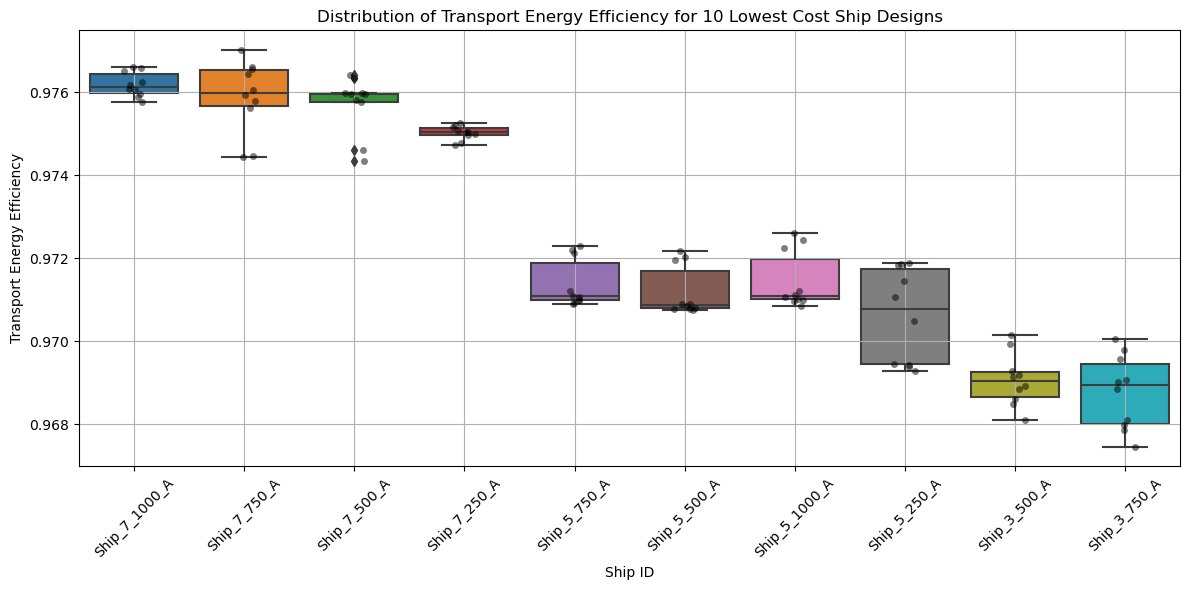

In [ ]:
filtered_cost_df = cost_df[cost_df["Main Fuel"] == "Ammonia"]
top10_rfr = filtered_cost_df.groupby("Ship ID")["RFR (NOK/Ton)"].mean().sort_values().head(10)



filtered_cost_df = cost_df[cost_df["Ship ID"].isin(top10_rfr.index) & (cost_df["Main Fuel"] == "Ammonia")]


# 4. Recalculate means in filtered set (because outliers or filtering may affect order)
ordered_groups = (
    filtered_cost_df
    .groupby("Ship ID")["RFR (NOK/Ton)"]
    .mean()
    .sort_values()
    .index.tolist()
)

# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="RFR (NOK/Ton)", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="RFR (NOK/Ton)", order=ordered_groups,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Required Freight Rate (NOK/Ton) for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("RFR (NOK/Ton)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="Transport Cost (€/MWhNH3,LHV)", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="Transport Cost (€/MWhNH3,LHV)", order=ordered_groups,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Transport Cost (€/MWhNH3,LHV)for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("Transport Cost (€/MWhNH3,LHV))")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="Transport cost precetage of total production cost", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="Transport cost precetage of total production cost",order=ordered_groups ,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Transport cost precetage of total production cost for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("Transport cost precetage of total production cost")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 5. Plot with corrected x-axis order
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_cost_df, x="Ship ID", y="Transport Energy Efficiency", order=ordered_groups)
sns.stripplot(data=filtered_cost_df, x="Ship ID", y="Transport Energy Efficiency",order=ordered_groups ,color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Transport Energy Efficiency for 10 Lowest Cost Ship Designs")
plt.xlabel("Ship ID")
plt.ylabel("Transport Energy Efficiency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [308]:
filtered_cost_df

Ship ID           GT  Speed  Capacity  Range  Pump rate (m3/h)  \
5613    Ship_90_500_A  3940.566283   12.0      5000   1300               500   
5350    Ship_90_500_A  3940.566283   12.0      5000   1300               500   
8855   Ship_176_750_A  2592.466898   12.0      3000   2000               750   
3948     Ship_3_250_A  3872.007047   12.0      5000    600               250   
2286  Ship_182_1000_A  7260.717028   12.0     10000   2000              1000   
...               ...          ...    ...       ...    ...               ...   
6315     Ship_3_500_A  3872.007047   12.0      5000    600               500   
4474     Ship_3_250_A  3872.007047   12.0      5000    600               250   
7630     Ship_3_500_A  3872.007047   12.0      5000    600               500   
9381   Ship_176_750_A  2592.466898   12.0      3000   2000               750   
182   Ship_182_1000_A  7260.717028   12.0     10000   2000              1000   

      Crew  Cargo Delivered (ton) Main Fuel  CO2 per ton cargo (ton)  \
5613    17                17000.0   Ammonia                 0.047284   
5350    17                17000.0   Ammonia                 0.048261   
8855    15                14280.0   Ammonia                 0.043900   
3948    17                13600.0   Ammonia                 0.056846   
2286    20                20400.0   Ammonia                 0.053019   
...    ...                    ...       ...                      ...   
6315    17                 6800.0   Ammonia                 0.109354   
4474    17                 6800.0   Ammonia                 0.109369   
7630    17                 6800.0   Ammonia                 0.111099   
9381    15                 4080.0   Ammonia                 0.129929   
182     20                 6800.0   Ammonia                 0.145092   

          EEOI  Transport Energy Efficiency  Failed bunkering  \
5613  0.000109                     0.946029               0.0   
5350  0.000094                     0.942255               0.0   
8855  0.000086                     0.938994               0.0   
3948  0.000143                     0.941246               0.0   
2286  0.000086                     0.941323               0.0   
...        ...                          ...               ...   
6315  0.000213                     0.899215               0.0   
4474  0.000213                     0.899158               0.0   
7630  0.000144                     0.892467               0.0   
9381  0.000253                     0.878424               0.0   
182   0.000283                     0.877843               0.0   

      Building Cost (MNOK)  Admin Cost (MNOK)  Crew Salary (MNOK)  \
5613            115.713777            2.59150             15.5125   
5350            115.713777            2.59150             15.5125   
8855             75.691195            2.59150             13.6875   
3948            114.712370            2.59150             15.5125   
2286            210.030605            3.52225             18.2500   
...                    ...                ...                 ...   
6315            114.712370            2.59150             15.5125   
4474            114.712370            2.59150             15.5125   
7630            114.712370            2.59150             15.5125   
9381             75.691195            2.59150             13.6875   
182             210.030605            3.52225             18.2500   

      Insurance (MNOK)  Maintenance (MNOK)  Drewry Annual Cost (MNOK)  \
5613          0.925710            1.157138                  20.186848   
5350          0.925710            1.157138                  20.186848   
8855          0.605530            0.756912                  17.641442   
3948          0.917699            1.147124                  20.168823   
2286          1.680245            2.100306                  25.552801   
...                ...                 ...                        ...   
6315          0.917699            1.147124                  20.1688

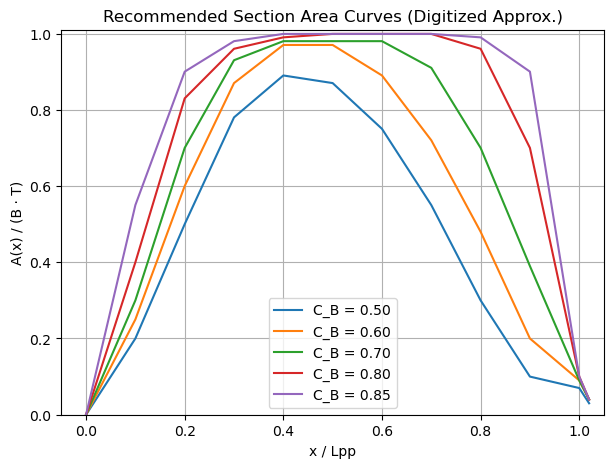

In [ ]:
# Manually digitized data from Figure 4.13.2 (approximate)
data_curves = {
    0.50: [
        (0.0, 0.00), (0.1, 0.20), (0.2, 0.50), (0.3, 0.78), (0.4, 0.89),
        (0.5, 0.87), (0.6, 0.75), (0.7, 0.55), (0.8, 0.30), (0.9, 0.10), (1.0, 0.07), (1.02, 0.03)
    ],
    0.60: [
        (0.0, 0.00), (0.1, 0.25), (0.2, 0.60), (0.3, 0.87), (0.4, 0.97),
        (0.5, 0.97), (0.6, 0.89), (0.7, 0.72), (0.8, 0.48), (0.9, 0.20), (1.0, 0.09), (1.02, 0.04)
    ],
    0.70: [
        (0.0, 0.00), (0.1, 0.30), (0.2, 0.70), (0.3, 0.93), (0.4, 0.98),
        (0.5, 0.98), (0.6, 0.98), (0.7, 0.91), (0.8, 0.70), (0.9, 0.39), (1.0, 0.09), (1.02, 0.04)
    ],
    0.80: [
        (0.0, 0.00), (0.1, 0.40), (0.2, 0.83), (0.3, 0.96), (0.4, 0.99),
        (0.5, 0.999), (0.6, 0.999), (0.7, 0.999), (0.8, 0.96), (0.9, 0.70), (1.0, 0.10), (1.02, 0.04)
    ],
    0.85: [
        (0.0, 0.00), (0.1, 0.55), (0.2, 0.90), (0.3, 0.98), (0.4, 0.999),
        (0.5, 0.999), (0.6, 0.999), (0.7, 0.999), (0.8, 0.99), (0.9, 0.90), (1.0, 0.10), (1.02, 0.04)
    ]
}
plt.figure(figsize=(7,5))

for CB, xy_pairs in data_curves.items():
    x_vals = [p[0] for p in xy_pairs]
    y_vals = [p[1] for p in xy_pairs]
    plt.plot(x_vals, y_vals, label=f"C_B = {CB:.2f}")

plt.xlabel("x / Lpp")
plt.ylabel("A(x) / (B · T)")
plt.title("Recommended Section Area Curves (Digitized Approx.)")
plt.legend()
plt.grid(True)
plt.ylim([0, 1.01])
plt.xlim([-0.05, 1.05])
plt.show()


In [22]:
def interp_in_x(xy_pairs, x):
    """
    Piecewise linear interpolation in the x-dimension for a single CB curve.
    xy_pairs is a sorted list of (x_i, y_i).
    """
    # Clamp x if outside the data range
    if x <= xy_pairs[0][0]:
        return xy_pairs[0][1]
    if x >= xy_pairs[-1][0]:
        return xy_pairs[-1][1]
    
    # Find the interval where x lies
    for i in range(len(xy_pairs) - 1):
        x1, y1 = xy_pairs[i]
        x2, y2 = xy_pairs[i+1]
        if x1 <= x <= x2:
            # Linear interpolation
            if abs(x2 - x1) < 1e-9:  # avoid division by zero
                return y1
            frac = (x - x1) / (x2 - x1)
            return (1 - frac)*y1 + frac*y2
    
    return 0.0  # fallback, should not happen if data is well-formed

def area_ratio(cb, x):
    """
    Returns A(x)/(B*T) for a *continuous* cb in [0.50..0.85] and x in [0..1].
    Uses piecewise linear interpolation in both CB and x.
    """
    # Sort the known CB keys
    cb_keys = sorted(data_curves.keys())  # [0.50, 0.60, 0.70, 0.80, 0.85]
    
    # Clamp cb to [min..max]
    if cb < cb_keys[0]:
        cb = cb_keys[0]
    if cb > cb_keys[-1]:
        cb = cb_keys[-1]
    
    # If cb is exactly one of the keys, just interpolate in x and return
    if cb in data_curves:
        return interp_in_x(data_curves[cb], x)
    
    # Otherwise, find the two bounding CBs
    for i in range(len(cb_keys) - 1):
        cb_low = cb_keys[i]
        cb_high = cb_keys[i+1]
        if cb_low <= cb <= cb_high:
            # Interpolate in x for each bounding CB
            val_low = interp_in_x(data_curves[cb_low], x)
            val_high = interp_in_x(data_curves[cb_high], x)
            # Now interpolate those two results in CB dimension
            f = (cb - cb_low) / (cb_high - cb_low)
            return (1 - f)*val_low + f*val_high
    
    # Fallback (should not happen)
    return 0.0


In [24]:
from scipy.optimize import brentq

def get_station_org(x, B, T, Cb):
    Cm = area_ratio(Cb, x)
    Am = B * T * Cm
    #print("Target Am:", Am)

    # Define function to solve for t
    def area_difference(t):
        eps = 1e-6  # Small offset to prevent division by zero
        xs = np.linspace(0, B, 1000)
        ys = (np.sin(xs * np.pi / B)) ** t * T + eps
        area = np.trapz(ys, xs)  # Compute the integral
        return area - Am  # Difference from target

    # Find t that makes the area match Am using brentq (bounded root-finding)
    t_solution = brentq(area_difference, 0.0001, 100)  # Ensuring positive t
    #print("Optimized t:", round(t_solution, 4))
    
    if t_solution < 1 or x < 0.9:
    # Plot the final curve
        xs = np.linspace(0, B/2, 1000)
        ys = (np.sin(xs * np.pi / B) ) ** t_solution * T
        ysp = T - ys
        ysp = np.flip(ysp)
        if x < 0.5:
            xs = -xs
        plt.plot(xs, ysp, label=f"x = {round(x,2)}, t = {round(t_solution, 4)}")
        plt.title(f'Station Curve for Cb = {round(Cb,2)}')
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.show()

        lolx = xs
        loly = ysp
        ys = lolx
        zs = loly
        # Print final area to verify
        return ysp , zs
    else:
        def area_difference(t):
            #eps = 1e-6  # Small offset to prevent division by zero
            xs = np.linspace(0, 1/t*np.log(T+1), 10)
            height = np.linspace(T, T, 10)
            ys = np.exp(xs * t) - 1
            area_under = np.trapz(ys, xs) 
            area_whole = np.trapz(height, xs)
            area = area_whole - area_under
            return area - Am/2  # Difference from target
        t_solution = brentq(area_difference, 0.01, 2, maxiter=1000)  # Ensuring positive t
        
        
        cross = 1/t_solution*np.log(T+1)

        xs = np.linspace(0, cross, 100)
        ysp = np.exp(xs * t_solution) - 1
        plt.plot(xs, ysp, label=f"x = {round(x,2)}, t = {round(t_solution, 4)}")
        plt.title(f'Station Curve for Cb = {round(Cb,2)}')
        plt.xlabel("x")
        plt.ylabel("y")

        lolx = xs
        loly = ysp
        ys = lolx
        zs = loly
        # Print final area to verify
        return ysp , zs


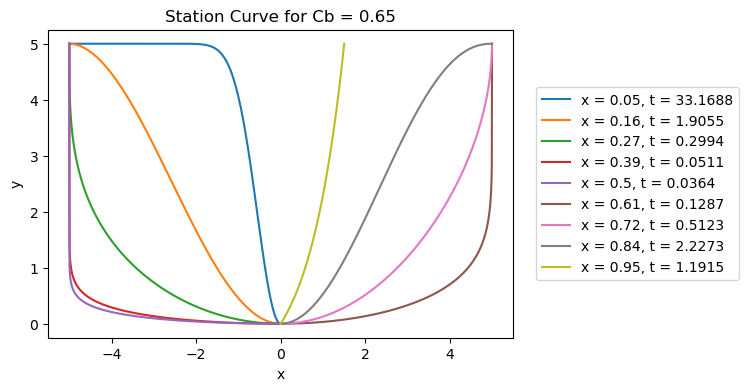

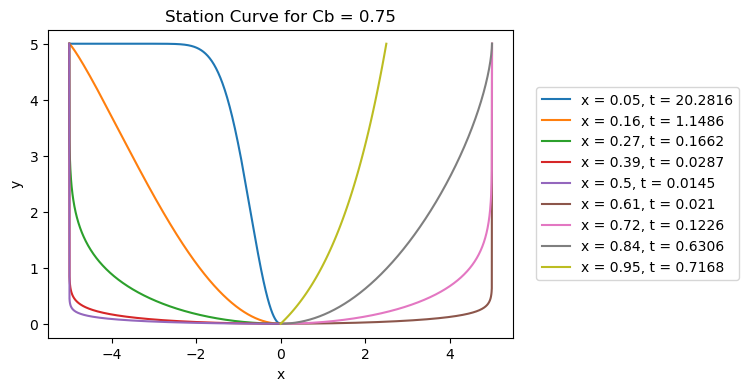

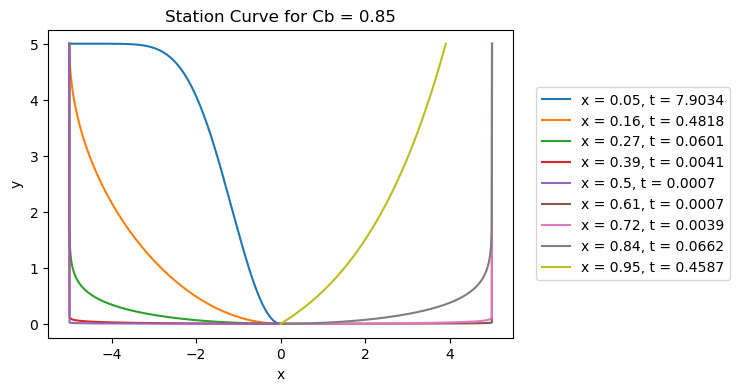

In [26]:
%matplotlib inline
plt.figure(figsize=(6,4))
x = np.linspace(0.05, 0.95, 9)
B = 10
T = 5
Cb = 0.65
for i in x:
    get_station_org(i, B, T, Cb)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.show()


%matplotlib inline
plt.figure(figsize=(6,4))
Cb = 0.75
for i in x:
    get_station_org(i, B, T, Cb)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.show()


%matplotlib inline
plt.figure(figsize=(6,4))
Cb = 0.85
for i in x:
    get_station_org(i, B, T, Cb)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.show()

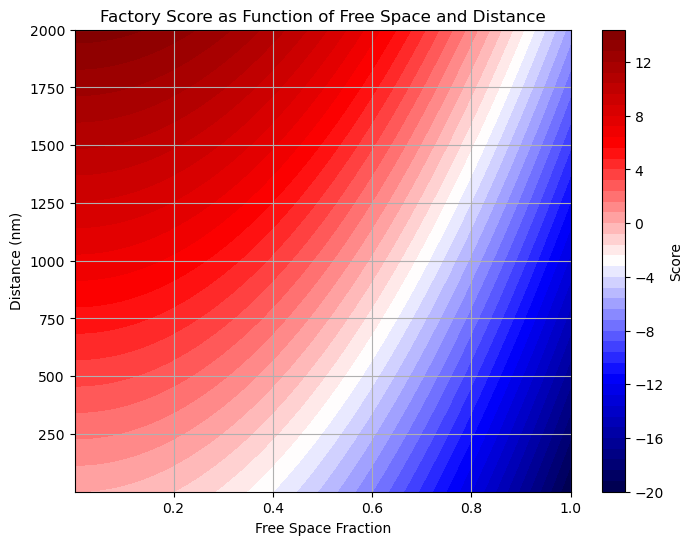

In [65]:
# Create a grid of free space fractions and distances
free_space_fractions = np.linspace(0.001, 1, 100)
distances = np.linspace(0.001, 2000, 100)
free_space_grid, distance_grid = np.meshgrid(free_space_fractions, distances)

# Compute scores for each combination
def compute_score(free_frac, distance, w_free=20, w_dist=0.007):
    return -(free_frac**2 * w_free - distance * w_dist)

score_grid = compute_score(free_space_grid, distance_grid)

# Plot the score surface
fig = plt.figure(figsize=(8, 6))
cp = plt.contourf(free_space_grid, distance_grid, score_grid, levels=50, cmap='seismic')
plt.colorbar(cp, label="Score")
plt.xlabel("Free Space Fraction")
plt.ylabel("Distance (nm)")
plt.title("Factory Score as Function of Free Space and Distance")
plt.grid(True)
plt.show()


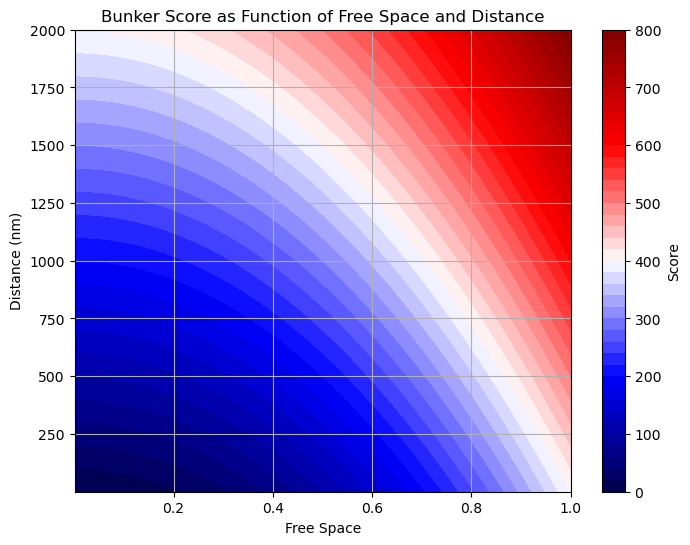

In [66]:
# Create a grid of free space fractions and distances
free_space_fractions = np.linspace(0.001, 1, 100)
distances = np.linspace(0.001, 2000, 100)
free_space_grid, distance_grid = np.meshgrid(free_space_fractions, distances)

# Compute scores for each combination
def compute_score(free_frac, distance, w_free=20, w_dist=0.2):
    return ((free_frac * w_free)**2 + distance * w_dist)

score_grid = compute_score(free_space_grid, distance_grid)

# Plot the score surface
fig = plt.figure(figsize=(8, 6))
cp = plt.contourf(free_space_grid, distance_grid, score_grid, levels=50, cmap='seismic')
plt.colorbar(cp, label="Score")
plt.xlabel("Free Space")
plt.ylabel("Distance (nm)")
plt.title("Bunker Score as Function of Free Space and Distance")
plt.grid(True)
plt.show()

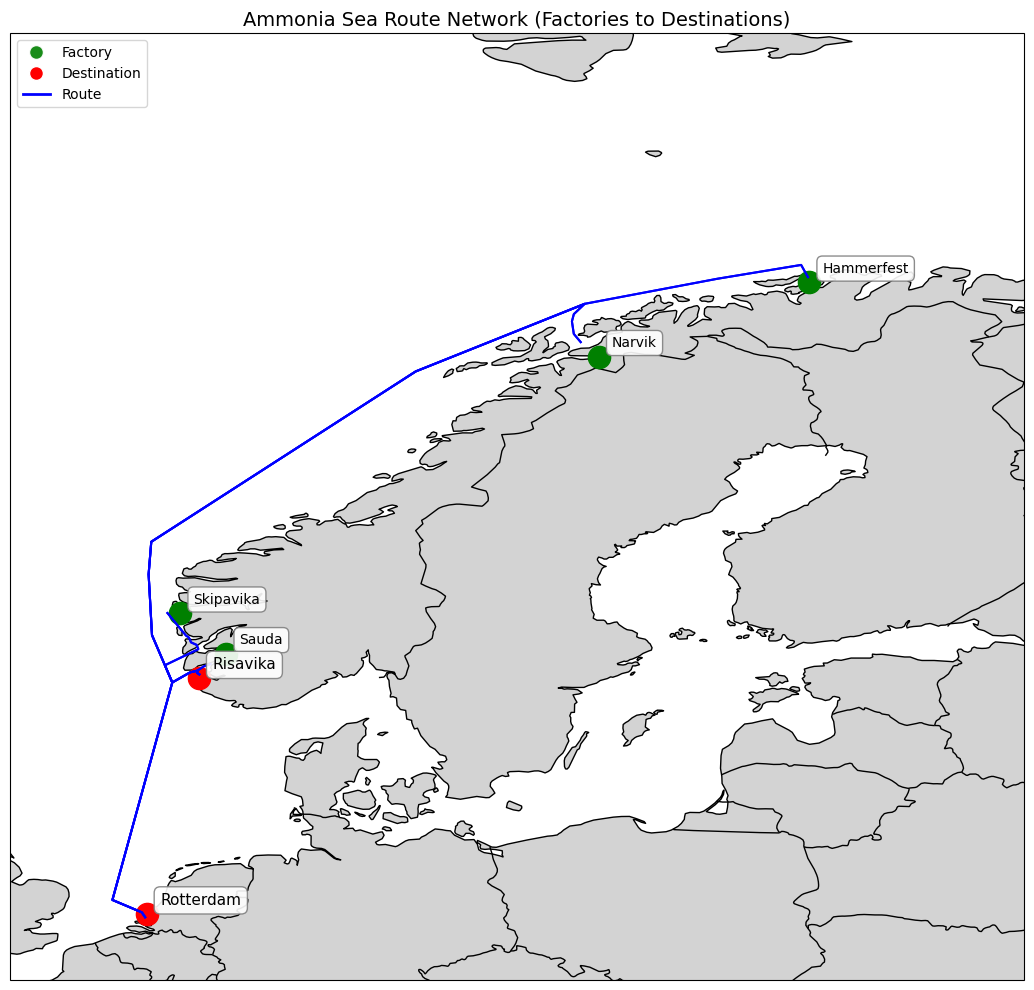

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import LineString

# Factories
factories = {
    #"Herøya": {"coords": (9.6342, 59.1201), "capacity_tph": 800000, "year": 2026},
    "Sauda": {"coords": (6.3893, 59.6526), "capacity_tph": 200000, "year": 2028},
    "Skipavika": {"coords": (5.0273, 60.8542), "capacity_tph": 100000, "year": 2026},
    #"Korgen": {"coords": (13.8243, 66.0743), "capacity_tph": 200000, "year": 2026},
    #"Glomfjord": {"coords": (13.9301, 66.8138), "capacity_tph": 30000, "year": 2025},
    "Narvik": {"coords": (17.4072, 68.4408), "capacity_tph": 450000, "year": 2030},
    "Hammerfest": {"coords": (23.6303, 70.6417), "capacity_tph": 1000000, "year": 2027}
}

# Destinations
destinations = {
    "Risavika": (5.5910, 58.9191),
    "Rotterdam": (4.0454, 51.9548),
    #'Oslo': (10.7528, 59.9139),
    #'Copenhagen': (12.5683, 55.6761),
    #'Frøya' : (8.7852, 63.7091),
}

all_nodes = {"Sauda": (6.3893, 59.6526), "Skipavika": (5.0273, 60.8542), "Narvik": (17.4072, 68.4408), "Hammerfest": (23.6303, 70.6417), "Risavika": (5.5910, 58.9191), "Rotterdam": (4.0454, 51.9548)}

for i in all_nodes:
    for j in all_nodes:
        if i != j:
            None
            #print(f"Distance {i} to {j}: {sr.searoute(all_nodes[i], all_nodes[j],units='nm').properties['length']} nautical miles")


# Setup map with Cartopy
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([0, 30, 50, 78], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

texts = []

# Plot factories and add label references to `texts`
for name, info in factories.items():
    lon, lat = info["coords"]
    ax.plot(lon, lat, 'go', markersize=16, transform=ccrs.PlateCarree())

    #label = f"{name}\n{info['capacity_tph']} ton/year\nOpens: {info['year']}"
    label = f"{name}"
    text = ax.text(
        lon + 0.4, lat + 0.4, label,
        fontsize=10, ha='left', va='center',
        transform=ccrs.PlateCarree(),
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9, edgecolor='gray')
    )
    texts.append(text)

# Plot destinations and add to texts for adjustment
for name, (lon, lat) in destinations.items():
    ax.plot(lon, lat, 'ro', markersize=16, transform=ccrs.PlateCarree())
    text = ax.text(
        lon + 0.4, lat + 0.4, name,
        fontsize=11, ha='left', va='center',
        transform=ccrs.PlateCarree(),
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9, edgecolor='gray')
    )
    texts.append(text)


# Plot sea routes
for fname, fdata in factories.items():
    for dname, dcoords in destinations.items():
        try:
            route = sr.searoute(fdata["coords"], dcoords, units="naut")
            #route.properties['length'] = route.properties['length'] * 0.539957  # Convert km to nautical miles
            line = LineString(route["geometry"]["coordinates"])
            #print(f"Route from {fname} to {dname}: {route.properties['length']} nautical miles")
            x, y = line.xy
            ax.plot(x, y, color='blue', linewidth=1.5, transform=ccrs.Geodetic())
        except Exception as e:
            print(f"Route failed from {fname} to {dname}: {e}")


from matplotlib.lines import Line2D

# Custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Factory',
           markerfacecolor='green', markersize=10,alpha=0.9),
    Line2D([0], [0], marker='o', color='w', label='Destination',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], color='blue', lw=2, label='Route')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper left')


plt.title("Ammonia Sea Route Network (Factories to Destinations)", fontsize=14)
plt.tight_layout()
plt.show()


In [79]:
df_port = pd.read_csv('Daily_Port_Activity_Data_and_Trade_Estimates.csv')
df_port['date'] = pd.to_datetime(df_port['date'])

In [80]:
df_rot = df_port[df_port['portname'] == 'Rotterdam'].reset_index(drop=True)

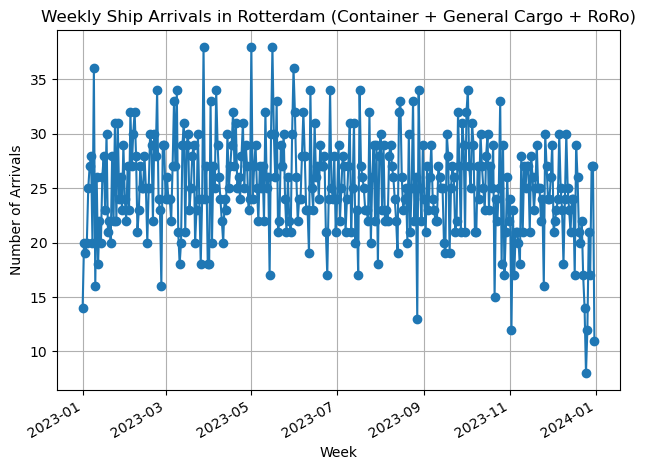

date
2023-01-01 00:00:00+00:00    14
2023-01-02 00:00:00+00:00    20
2023-01-03 00:00:00+00:00    19
2023-01-04 00:00:00+00:00    20
2023-01-05 00:00:00+00:00    25
                             ..
2023-12-27 00:00:00+00:00    21
2023-12-28 00:00:00+00:00    17
2023-12-29 00:00:00+00:00    27
2023-12-30 00:00:00+00:00    27
2023-12-31 00:00:00+00:00    11
Length: 365, dtype: int64

In [81]:
# Step 1: Create arrival rate series
arrival_rate_day_rot = (df_rot['portcalls_container'] + df_rot['portcalls_roro'])
arrival_rate_day_rot
#arrival_rate_day_rot.index = pd.to_datetime(df_rot['date'])
#arrival_rate_day_rot_2019 = arrival_rate_day_rot[arrival_rate_day_rot.index.year == 2019]

# Step 2: Make sure the index of the Series is datetime
arrival_rate_day_rot.index = pd.to_datetime(df_rot['date'])

# Step 3: Resample to weekly totals
arrival_rate_day_rot = arrival_rate_day_rot[arrival_rate_day_rot.index.year == 2023]
#arrival_rate_day_rot = arrival_rate_day_rot[arrival_rate_day_rot > 15]
arrival_rate_weekly_rot = arrival_rate_day_rot.resample('W').sum()

# Step 4: Filter out weeks with low traffic (optional)
arrival_rate_filtered = arrival_rate_weekly_rot[arrival_rate_weekly_rot > 100]

# Step 5: Plot
arrival_rate_day_rot.plot(marker='o', linestyle='-')
plt.title('Weekly Ship Arrivals in Rotterdam (Container + General Cargo + RoRo)')
plt.xlabel('Week')
plt.ylabel('Number of Arrivals')
plt.grid(True)
plt.tight_layout()
plt.show()
arrival_rate_day_rot


Proportion of grouped bins with expected < 5: 0.00%
Any grouped bin with expected < 1? No
Optimal λ (MLE): 25.2826
Chi-squared Test (combined bins): χ²=25.37, dof=17, p-value=0.115


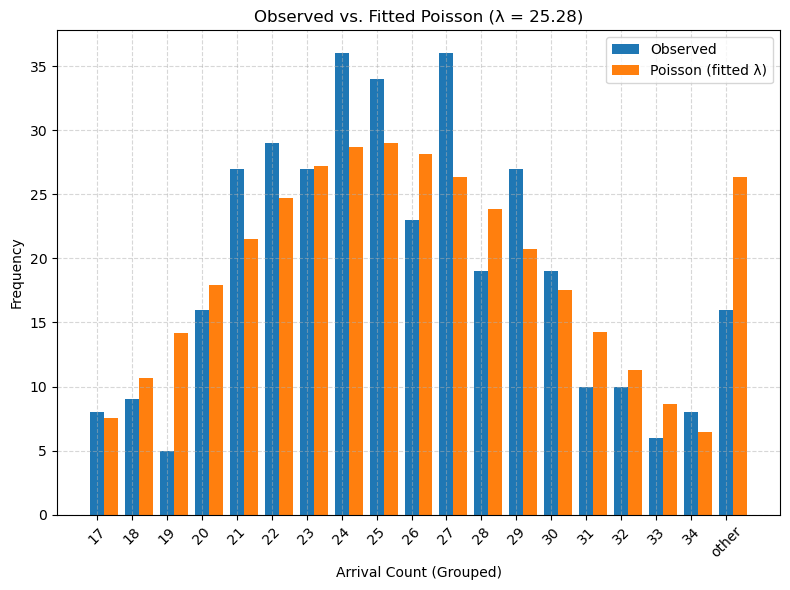

In [82]:
from scipy.stats import chisquare, poisson
from scipy.optimize import minimize_scalar


# Step 1: Filter data
arrival_rate_day_rot = df_rot['portcalls_container'] + df_rot['portcalls_roro']
arrival_rate_day_rot.index = pd.to_datetime(df_rot['date'])
arrival_rate_day_rot = arrival_rate_day_rot[arrival_rate_day_rot.index.year == 2023]
#arrival_rate_day_rot = arrival_rate_day_rot[arrival_rate_day_rot > 10]

# Step 2: Prepare observed frequencies
observed = arrival_rate_day_rot.value_counts().sort_index()
start, stop = 0, 80
x = np.arange(start, stop + 1)
observed = observed.reindex(x, fill_value=0)
total_observed = observed.sum()

# Step 3: Define objective function
def chi_squared_for_lambda(lam):
    expected_probs = poisson.pmf(x, lam)
    expected = pd.Series(expected_probs * total_observed, index=x)

    # Combine bins with expected < 5
    mask = expected >= 5
    obs_comb = observed[mask].copy()
    exp_comb = expected[mask].copy()
    if not mask.all():
        obs_comb.loc["other"] = observed[~mask].sum()
        exp_comb.loc["other"] = expected[~mask].sum()

    chi2, _ = chisquare(f_obs=obs_comb, f_exp=exp_comb)
    return chi2

# Step 4: Optimize λ
result = minimize_scalar(chi_squared_for_lambda, bounds=(1, 50), method='bounded')
optimal_lambda = result.x

# Step 5: Final expected values
expected_probs = poisson.pmf(x, optimal_lambda)
expected = pd.Series(expected_probs * total_observed, index=x)



# Step 6: Combine bins for test
mask = observed >= 5
obs_comb = observed[mask].copy()
exp_comb = expected[mask].copy()
if not mask.all():
    obs_comb.loc["other"] = observed[~mask].sum()
    exp_comb.loc["other"] = expected[~mask].sum()

# Step 6b: Check chi-squared assumptions after grouping
proportion_under_5 = (exp_comb < 5).sum() / len(exp_comb) * 100
any_under_1 = (exp_comb < 1).any()

print(f"Proportion of grouped bins with expected < 5: {proportion_under_5:.2f}%")
print(f"Any grouped bin with expected < 1? {'Yes' if any_under_1 else 'No'}")


chi2_stat, p_value = chisquare(f_obs=obs_comb, f_exp=exp_comb)
dof = len(obs_comb) - 1 - 1

# Step 7: Report
print(f"Optimal λ (MLE): {optimal_lambda:.4f}")
print(f"Chi-squared Test (combined bins): χ²={chi2_stat:.2f}, dof={dof}, p-value={p_value:.3f}")

# Step 8: Plot
plt.figure(figsize=(8, 6))
idx = np.arange(len(obs_comb))
plt.bar(idx, obs_comb.values, alpha=1, label='Observed', width=0.4)
plt.bar(idx + 0.4, exp_comb.values, alpha=1, label='Poisson (fitted λ)', width=0.4)
plt.xticks(idx, obs_comb.index, rotation=45)
plt.xlabel('Arrival Count (Grouped)')
plt.ylabel('Frequency')
plt.title(f'Observed vs. Fitted Poisson (λ = {optimal_lambda:.2f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [83]:
df_ris = pd.read_excel('Liste over ankoms-202504031140.xlsx',sheet_name='Liste over ankoms-202504031140')
df_ris['Dato'] = pd.to_datetime(df_ris['Dato'])
df_ris.sort_values(by='Dato', ascending=True, inplace=True)
df_ris.drop(columns=['Unnamed: 14', 'Unnamed: 15','Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'], inplace=True)
df_ris.set_index('Dato', inplace=True)

In [84]:
df_ris

MMSI      IMO          Skipsnavn  \
Dato                                                  
2024-01-01  219348000.0  9586617       BERGENSFJORD   
2024-01-01  258356000.0  9340738          FRAMFJORD   
2024-01-01  259112000.0  9642564  SAMSKIP KVITBJORN   
2024-01-02          NaN  9422213       TROMS CASTOR   
2024-01-02  219348000.0  9586617       BERGENSFJORD   
...                 ...      ...                ...   
2024-12-30  235097323.0  9647239      VOS FANTASTIC   
2024-12-31  257243000.0  9657648            NS ORLA   
2024-12-31  258467000.0  9439022       TROMS POLLUX   
2024-12-31  255805587.0  9326990         NCL AVEROY   
2024-12-31  257867000.0  9616175     SOLITAIRE TIDE   

                                  Skipstype                    Skipstype gen  \
Dato                                                                           
2024-01-01  Passenger/Ro-Ro Ship (Vehicles)                    Passasjerskip   
2024-01-01               General Cargo Ship                        Lasteskip   
2024-01-01                 Ro-Ro Cargo Ship                        Lasteskip   
2024-01-02             Platform Supply Ship  Offshorefartøy og spesialfartøy   
2024-01-02  Passenger/Ro-Ro Ship (Vehicles)                    Passasjerskip   
...                                     ...                              ...   
2024-12-30            Standby Safety Vessel  Offshorefartøy og spesialfartøy   
2024-12-31             Platform Supply Ship  Offshorefartøy og spesialfartøy   
2024-12-31             Platform Supply Ship  Offshorefartøy og spesialfartøy   
2024-12-31  Container Ship (Fully Cellular)                        Lasteskip   
2024-12-31             Platform Supply Ship  Offshorefartøy og spesialfartøy   

               BT           L          B     H      D HazMat  \
Dato                                                           
2024-01-01  32491  170.000000  27.500000  38.0  6.500    NEI   
2024-01-01   1683   67.099998  12.600000   NaN  5.300    NEI   
2024-01-01   9132  119.919998  20.799999   NaN  6.010     JA   
2024-01-02   4366   85.000000  20.000000   NaN  7.163    NEI   
2024-01-02  32491  170.000000  27.500000  38.0  6.500    NEI   
...           ...         ...        ...   ...    ...    ...   
2024-12-30   1325   50.000000  13.200000   NaN  3.750    NEI   
2024-12-31   5165   97.000000  20.000000   NaN  7.010     JA   
2024-12-31   4366   85.000000  20.000000   NaN  7.160    NEI   
2024-12-31   9990  134.440002  22.500000   NaN  8.700     JA   
2024-12-31   5370   91.599998  22.000000   NaN  7.200    NEI   

                                    Fra           Til  
Dato                                                   
2024-01-01                København, DK  Risavika, NO  
2024-01-01                 Laksevåg, NO  Risavika, NO  
2024-01-01                Rotterdam, NL  Risavika, NO  
2024-01-02                Stavanger, NO  Risavika, NO  
2024-01-02                   Bergen, NO  Risavika, NO  
...                                 ...           ...  
2024-12-30                Nordsjøen, XZ  Risavika, NO  
2024-12-31  Offshoreinst. Nordsjøen, XZ  Risavika, NO  
2024-12-31  Offshoreinst. Nordsjøen, XZ  Risavika, NO  
2024-12-31               Maasvlakte, NL  Risavika, NO  
2024-12-31                Stavanger, NO  Risavika, NO  

[3921 rows x 13 columns]

9 9
Optimal λ (MLE): 4.2932
Chi-squared Test (combined bins): χ²=4.86, p-value=0.847, DOF: 8


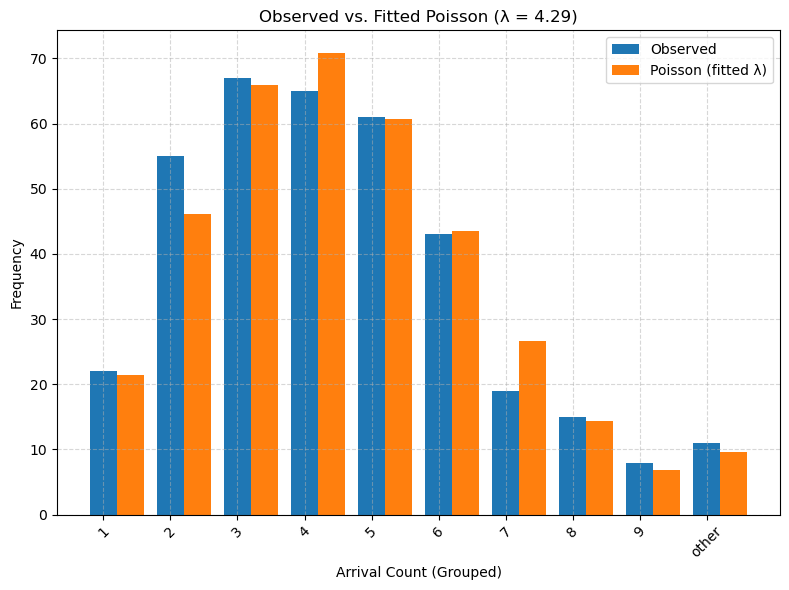

In [85]:


# Step 1: Prepare observed frequency distribution
# Full date range based on the dataset
full_dates = pd.date_range(start=df_ris.index.min(), end=df_ris.index.max(), freq='D')

# Count arrivals of offshore vessels to Risavika
offshore_counts = (
    df_ris[(df_ris['Til'] == 'Risavika, NO') & 
           (df_ris['Skipstype gen'].str.strip() == 'Offshorefartøy og spesialfartøy')]
    .groupby('Dato').size()
)

# Reindex to include all days with 0 arrivals for missing ones
offshore_counts_full = offshore_counts.reindex(full_dates, fill_value=0)

# Now build the observed frequency distribution
observed = offshore_counts_full.value_counts().sort_index()
observed

x = np.arange(0, observed.index.max() + 18)

# Extend observed with zeros to match x
observed = observed.reindex(x, fill_value=0)
total_observed = observed.sum()

# Step 2: Define objective function with bin combination
def chi_squared_for_lambda(lam):
    expected_probs = poisson.pmf(x, lam)
    expected = pd.Series(expected_probs * total_observed, index=x)

    # Combine bins with expected < 5
    mask = expected >= 5
    observed_comb = observed[mask].copy()
    expected_comb = expected[mask].copy()
    if not mask.all():
        observed_comb.loc["other"] = observed[~mask].sum()
        expected_comb.loc["other"] = expected[~mask].sum()

    chi2, _ = chisquare(f_obs=observed_comb, f_exp=expected_comb)
    return chi2

# Step 3: Optimize λ
result = minimize_scalar(chi_squared_for_lambda, bounds=(1, 10), method='bounded')
optimal_lambda = result.x
min_chi2 = result.fun

# Step 4: Generate expected values with optimal λ
expected_probs = poisson.pmf(x, optimal_lambda)
expected = pd.Series(expected_probs * total_observed, index=x)

# Step 5: Combine bins again for final test
mask = expected >= 5
observed_comb = observed[mask].copy()
expected_comb = expected[mask].copy()
print(len(observed_comb), len(expected_comb))
if not mask.all():
    observed_comb.loc["other"] = observed[~mask].sum()
    expected_comb.loc["other"] = expected[~mask].sum()

chi2_stat, p_value = chisquare(f_obs=observed_comb, f_exp=expected_comb)
dof = len(observed_comb) - 1 - 1
print(f"Optimal λ (MLE): {optimal_lambda:.4f}")
print(f"Chi-squared Test (combined bins): χ²={chi2_stat:.2f}, p-value={p_value:.3f}, DOF: {dof}")

# Step 6: Plot
plt.figure(figsize=(8, 6))
indices = np.arange(len(observed_comb))
plt.bar(indices, observed_comb.values, alpha=1, label='Observed', width=0.4)
plt.bar(indices + 0.4, expected_comb.values, alpha=1, label='Poisson (fitted λ)', width=0.4)
plt.xticks(indices, observed_comb.index, rotation=45)
plt.xlabel('Arrival Count (Grouped)')
plt.ylabel('Frequency')
plt.title(f'Observed vs. Fitted Poisson (λ = {optimal_lambda:.2f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [86]:
df_fuel = pd.read_excel('ShipFuelOilExport-2023.xlsx',sheet_name='Table')
df_fuel = df_fuel[['IMO Number','Ship Type','Ship Type Other','Gross Tonnage','Fuel Oil Type','Quantity of fuel (tons)']]

df_fuel = df_fuel[df_fuel['Fuel Oil Type'].isin([
    'Diesel/Gas Oil (MDO/MGO) - ISO 8217 Grades DMX through DMB',
       'Heavy Fuel Oil (HFO) - ISO 8217 Grades RME through RMK',
       'Light Fuel Oil (LFO) - ISO 8217 Grades RMA through RMD'

])]

df_fuel = df_fuel[df_fuel['Ship Type'] == 'Others']
df_fuel['Fuel Oil Type'] = df_fuel['Fuel Oil Type'].str.replace(r'\s*-\s*ISO 8217 Grades.*', '', regex=True
)

df_fuel = df_fuel[df_fuel['Ship Type Other'].map(df_fuel['Ship Type Other'].value_counts()) > 15]
df_fuel = df_fuel[df_fuel['Ship Type Other'] != 'Ship other than any ship type defined in reg. 2']
df_fuel = df_fuel[df_fuel['Ship Type Other'] != 'Research Vessel']




df_fuel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 3 to 1201
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   IMO Number               86 non-null     int64 
 1   Ship Type                86 non-null     object
 2   Ship Type Other          86 non-null     object
 3   Gross Tonnage            86 non-null     int64 
 4   Fuel Oil Type            86 non-null     object
 5   Quantity of fuel (tons)  86 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 4.7+ KB


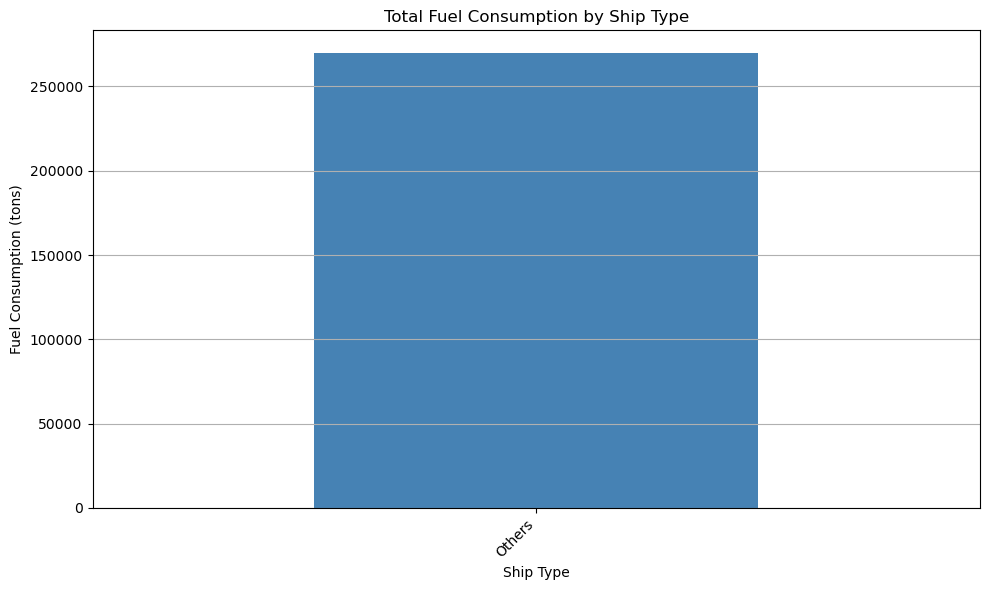

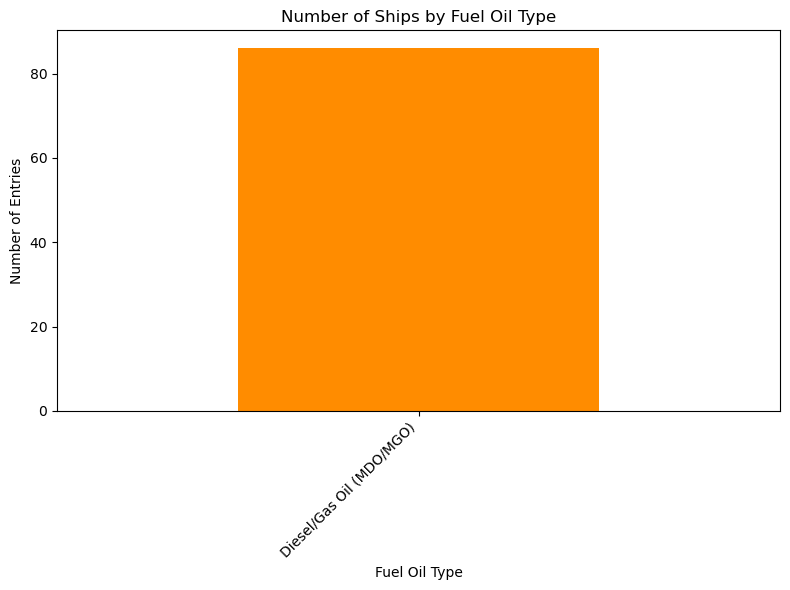

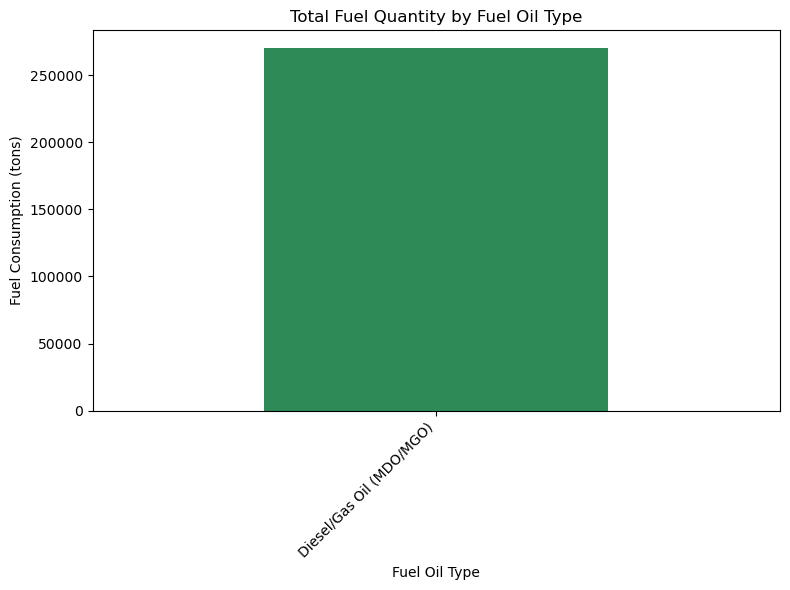

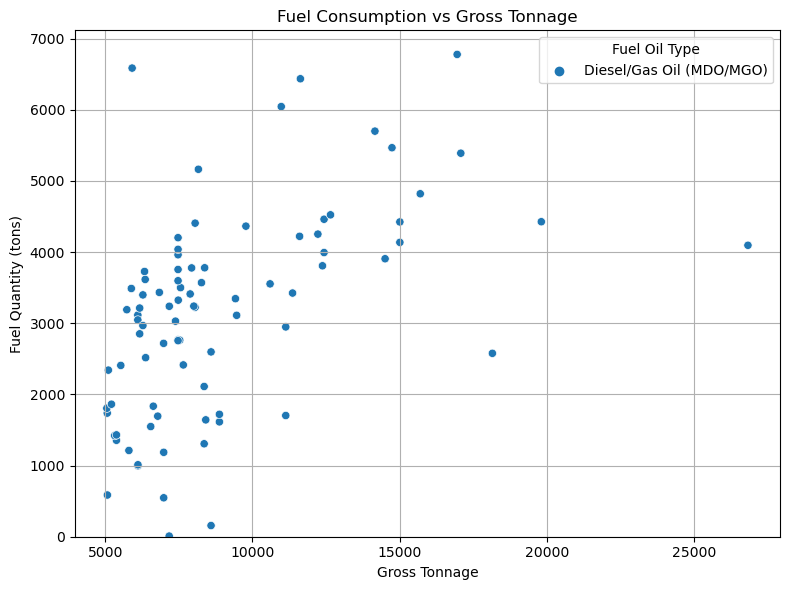

In [88]:
fuel_by_type = df_fuel.groupby('Ship Type')['Quantity of fuel (tons)'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
fuel_by_type.plot(kind='bar', color='steelblue')
plt.title('Total Fuel Consumption by Ship Type')
plt.ylabel('Fuel Consumption (tons)')
plt.xlabel('Ship Type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


fuel_type_counts = df_fuel['Fuel Oil Type'].value_counts()

plt.figure(figsize=(8, 6))
fuel_type_counts.plot(kind='bar', color='darkorange')
plt.title('Number of Ships by Fuel Oil Type')
plt.xlabel('Fuel Oil Type')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



fuel_qty_by_type = df_fuel.groupby('Fuel Oil Type')['Quantity of fuel (tons)'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
fuel_qty_by_type.plot(kind='bar', color='seagreen')
plt.title('Total Fuel Quantity by Fuel Oil Type')
plt.ylabel('Fuel Consumption (tons)')
plt.xlabel('Fuel Oil Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_fuel, x='Gross Tonnage', y='Quantity of fuel (tons)', hue='Fuel Oil Type')
plt.title('Fuel Consumption vs Gross Tonnage')
plt.xlabel('Gross Tonnage')
plt.ylabel('Fuel Quantity (tons)')
plt.legend(title='Fuel Oil Type')
plt.grid(True)
plt.tight_layout()
plt.ylim(0)
plt.show()




In [89]:
estimated_bunkerings_per_year = 25
energy_ratio = 42 / 18.6  

# Keep only ship types with more than 5 entries



df_fuel['Fuel per bunkering (ton)'] = df_fuel['Quantity of fuel (tons)'] / estimated_bunkerings_per_year
df_fuel['Estimated ammonia bunkering (ton)'] = df_fuel['Fuel per bunkering (ton)'] * energy_ratio


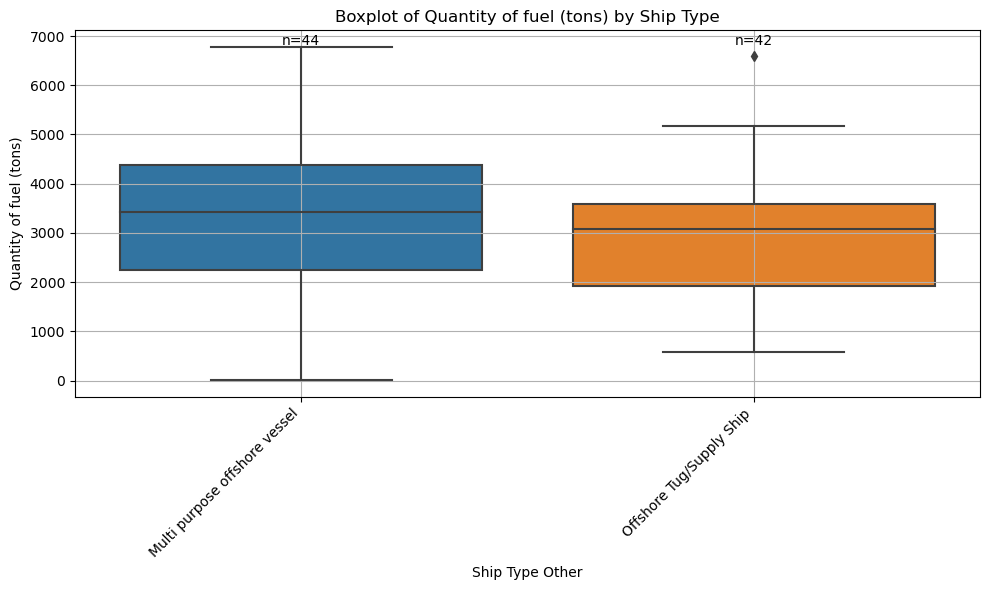

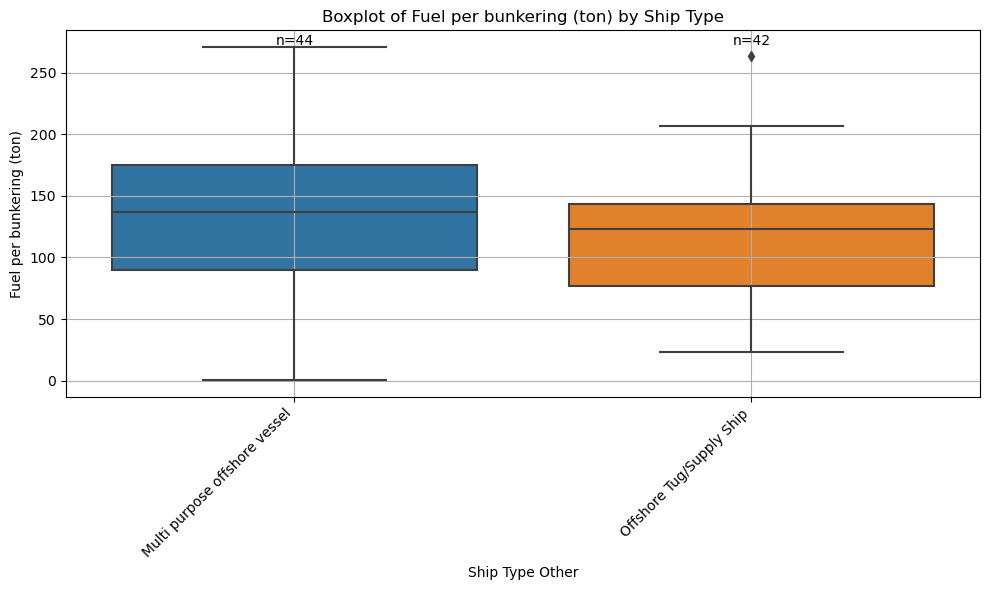

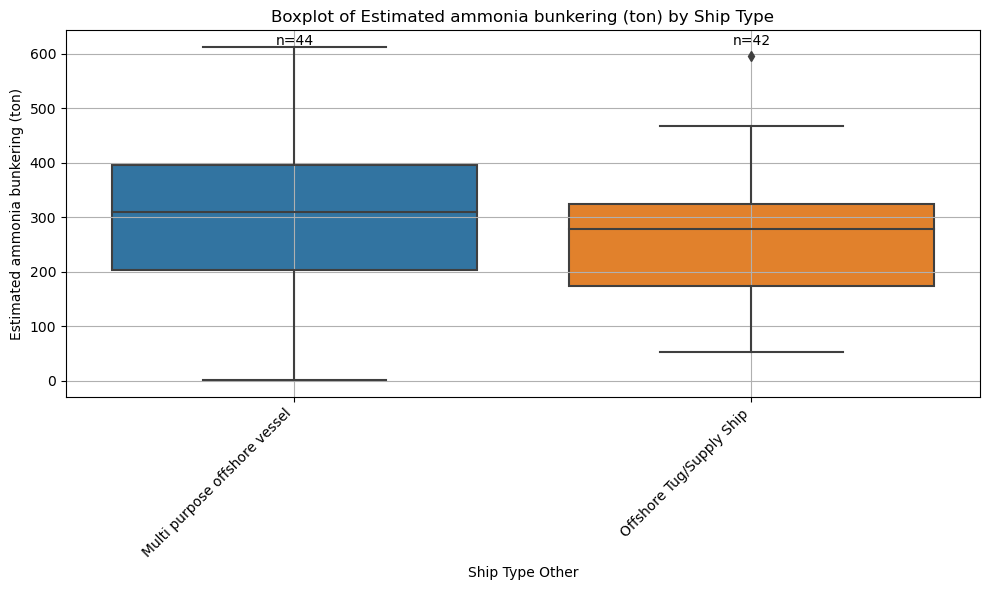

In [ ]:
numeric_columns = [
    'Quantity of fuel (tons)',
    'Fuel per bunkering (ton)',
    'Estimated ammonia bunkering (ton)'
]

# Plot boxplots with annotated counts for each ship type per variable
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=df_fuel, x='Ship Type Other', y=col)
    
    # Add counts per box
    ship_type_counts = df_fuel['Ship Type Other'].value_counts()
    for xtick in ax.get_xticks():
        ship_type = ax.get_xticklabels()[xtick].get_text()
        count = ship_type_counts.get(ship_type, 0)
        ax.text(xtick, ax.get_ylim()[1]*0.97, f'n={count}', 
                ha='center', va='center', fontsize=10, color='black')

    plt.title(f'Boxplot of {col} by Ship Type')
    plt.xticks(rotation=45,ha='right')
    plt.tight_layout()
    plt.grid()
    plt.show()

In [91]:
df_mrv = pd.read_excel("2023-v43-23042025-EU MRV Publication of information.xlsx",skiprows=2)

c:\Users\Morten\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [92]:
estimated_bunkerings_per_year = 25
df_mrv_test = df_mrv[['IMO Number', 'Ship type','Total fuel consumption [m tonnes]','Total CO₂ emissions [m tonnes]']]
df_mrv_test['Fuel use per bunkering (ton)'] = df_mrv_test['Total fuel consumption [m tonnes]'] / estimated_bunkerings_per_year
df_mrv_test['Ammonia est. per bunkering (ton)'] = df_mrv_test['Fuel use per bunkering (ton)'] * energy_ratio


df_mrv_test = df_mrv_test[df_mrv_test['Ship type'].isin(['Vehicle carrier','Container ship'])]

C:\Users\Morten\AppData\Local\Temp\ipykernel_37404\4231832923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mrv_test['Fuel use per bunkering (ton)'] = df_mrv_test['Total fuel consumption [m tonnes]'] / estimated_bunkerings_per_year
C:\Users\Morten\AppData\Local\Temp\ipykernel_37404\4231832923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mrv_test['Ammonia est. per bunkering (ton)'] = df_mrv_test['Fuel use per bunkering (ton)'] * energy_ratio


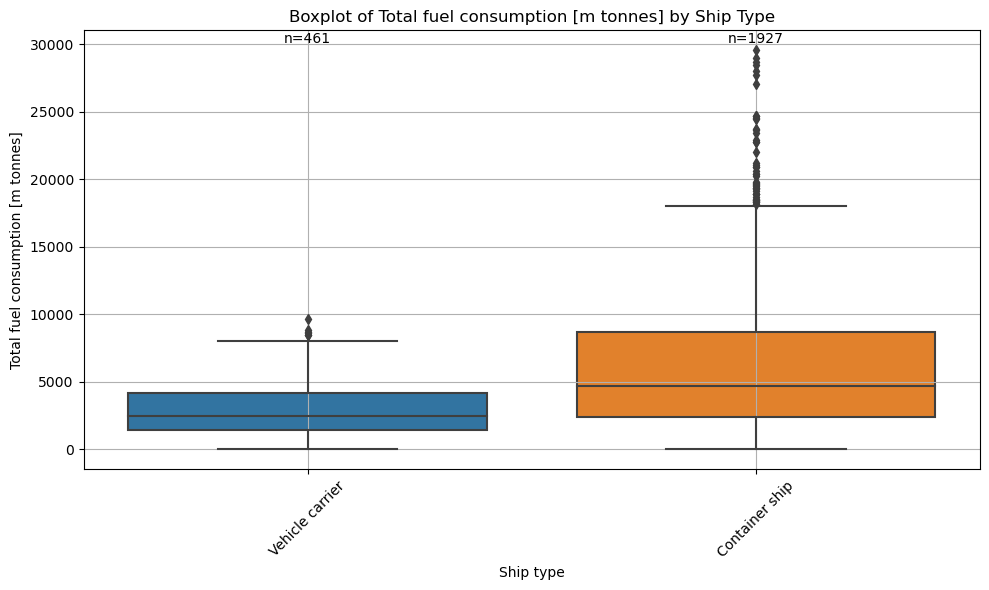

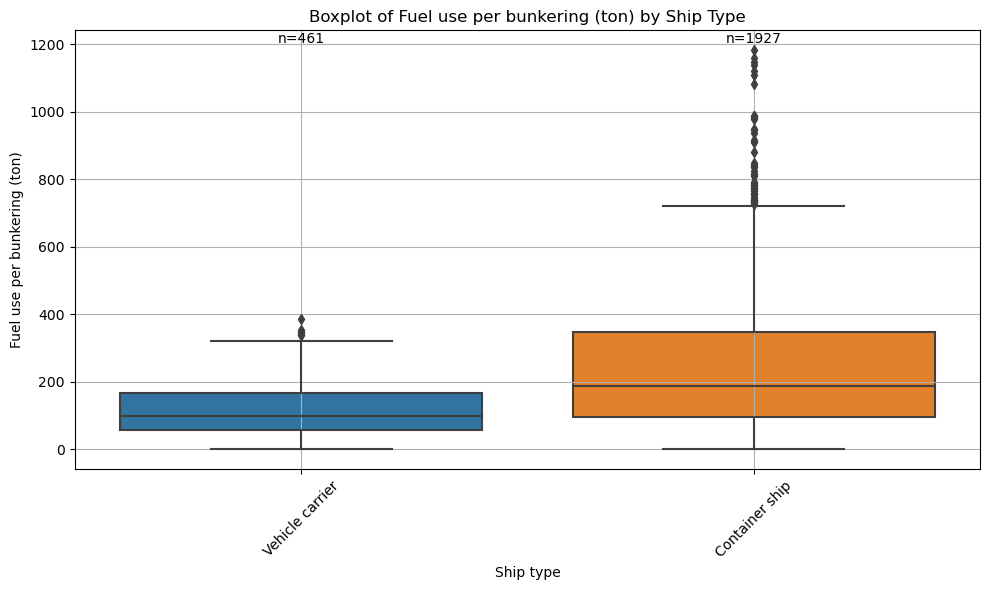

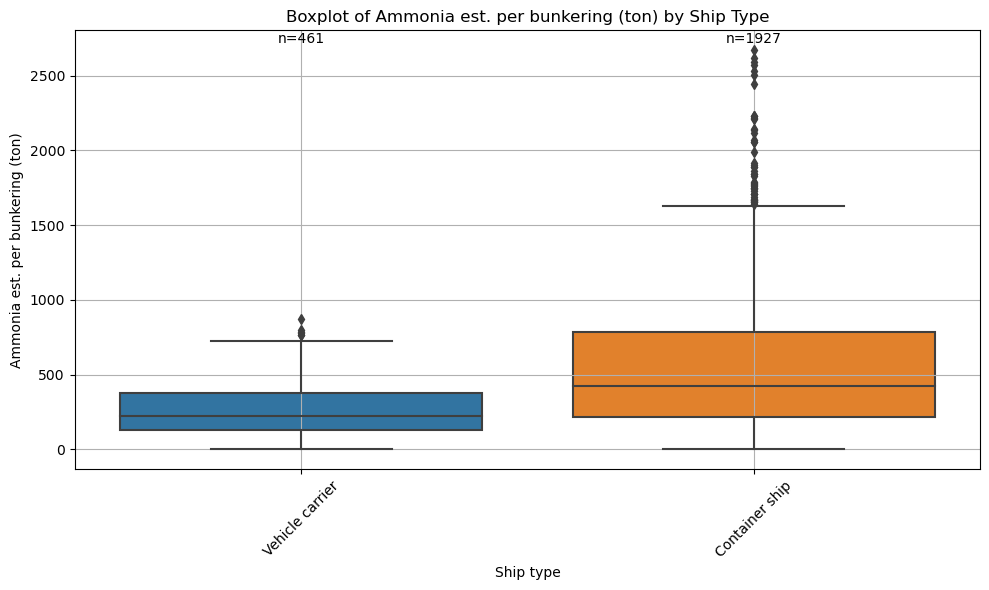

In [ ]:
# Plot boxplots for each numerical column grouped by ship type
numeric_columns = [
    'Total fuel consumption [m tonnes]',
    'Fuel use per bunkering (ton)',
    'Ammonia est. per bunkering (ton)'
]

# Plot boxplots with annotated counts for each ship type per variable
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=df_mrv_test, x='Ship type', y=col)
    
    # Add counts per box
    ship_type_counts = df_mrv_test['Ship type'].value_counts()
    for xtick in ax.get_xticks():
        ship_type = ax.get_xticklabels()[xtick].get_text()
        count = ship_type_counts.get(ship_type, 0)
        ax.text(xtick, ax.get_ylim()[1]*0.98, f'n={count}', 
                ha='center', va='center', fontsize=10, color='black')

    plt.title(f'Boxplot of {col} by Ship Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()